In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 5
DATASET_VERSION = "06"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-dart-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-dart-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
len(input_feats)

1308

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting': 'dart',
    'objective': 'binary',
    'metric': 'None',
    'num_iterations': 4350,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'max_bin': 63,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 1.0,
    'feature_fraction': 0.15,
    'lambda_l1': 5.996099571922015,
    'lambda_l2': 2.8900783163910697,
    'min_data_in_leaf': 1000,
    'path_smooth': 1.476306537276899,
    'min_gain_to_split': 0.313937968985787,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': True,
    'verbosity': -1,
    # dropout params
    'drop_rate': 0.1,
    'max_drop': 40,
    'skip_drop': 0.7,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        seed = repetition*5 + fold
        _model_params = dict(model_params)
        _model_params["seed"] = seed
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        print("seed:", seed)
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
                
        model = lgb.train(
            params=_model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/5 ################################


######################################## training model 1/5 ########################################
seed: 0


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.758699	valid_0's recall_at4: 0.614575	valid_0's norm_gini: 0.902823


[100]	valid_0's amex_metric: 0.768318	valid_0's recall_at4: 0.627619	valid_0's norm_gini: 0.909017


[150]	valid_0's amex_metric: 0.773857	valid_0's recall_at4: 0.634562	valid_0's norm_gini: 0.913151


[200]	valid_0's amex_metric: 0.779869	valid_0's recall_at4: 0.643693	valid_0's norm_gini: 0.916046


[250]	valid_0's amex_metric: 0.783549	valid_0's recall_at4: 0.649415	valid_0's norm_gini: 0.917684


[300]	valid_0's amex_metric: 0.7856	valid_0's recall_at4: 0.65236	valid_0's norm_gini: 0.91884


[350]	valid_0's amex_metric: 0.786605	valid_0's recall_at4: 0.653497	valid_0's norm_gini: 0.919714


[400]	valid_0's amex_metric: 0.789024	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.92047


[450]	valid_0's amex_metric: 0.790648	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.921361


[500]	valid_0's amex_metric: 0.79137	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.922006


[550]	valid_0's amex_metric: 0.791498	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.922473


[600]	valid_0's amex_metric: 0.792936	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.92295


[650]	valid_0's amex_metric: 0.794188	valid_0's recall_at4: 0.664941	valid_0's norm_gini: 0.923435


[700]	valid_0's amex_metric: 0.795443	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.923756


[750]	valid_0's amex_metric: 0.796301	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.924084


[800]	valid_0's amex_metric: 0.796813	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.924267


[850]	valid_0's amex_metric: 0.797472	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.924533


[900]	valid_0's amex_metric: 0.797625	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.924712


[950]	valid_0's amex_metric: 0.797872	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.924869


[1000]	valid_0's amex_metric: 0.798005	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.92501


[1050]	valid_0's amex_metric: 0.798243	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925108


[1100]	valid_0's amex_metric: 0.798276	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925172


[1150]	valid_0's amex_metric: 0.798293	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.925249


[1200]	valid_0's amex_metric: 0.79825	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925331


[1250]	valid_0's amex_metric: 0.798581	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.925404


[1300]	valid_0's amex_metric: 0.798276	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.925466


[1350]	valid_0's amex_metric: 0.798466	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925554


[1400]	valid_0's amex_metric: 0.798927	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.925634


[1450]	valid_0's amex_metric: 0.798786	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.925688


[1500]	valid_0's amex_metric: 0.798944	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.925752


[1550]	valid_0's amex_metric: 0.798898	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.925827


[1600]	valid_0's amex_metric: 0.799208	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925858


[1650]	valid_0's amex_metric: 0.799386	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.925877


[1700]	valid_0's amex_metric: 0.799548	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.925908


[1750]	valid_0's amex_metric: 0.799694	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925989


[1800]	valid_0's amex_metric: 0.799705	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926012


[1850]	valid_0's amex_metric: 0.799642	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.926053


[1900]	valid_0's amex_metric: 0.799939	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.926101


[1950]	valid_0's amex_metric: 0.800246	valid_0's recall_at4: 0.674367	valid_0's norm_gini: 0.926125


[2000]	valid_0's amex_metric: 0.800351	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.926166


[2050]	valid_0's amex_metric: 0.80038	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.926183


[2100]	valid_0's amex_metric: 0.800112	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926195


[2150]	valid_0's amex_metric: 0.800073	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.9262


[2200]	valid_0's amex_metric: 0.800448	valid_0's recall_at4: 0.674661	valid_0's norm_gini: 0.926234


[2250]	valid_0's amex_metric: 0.80068	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.926277


[2300]	valid_0's amex_metric: 0.800371	valid_0's recall_at4: 0.674451	valid_0's norm_gini: 0.926292


[2350]	valid_0's amex_metric: 0.799939	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926311


[2400]	valid_0's amex_metric: 0.800314	valid_0's recall_at4: 0.674283	valid_0's norm_gini: 0.926345


[2450]	valid_0's amex_metric: 0.800311	valid_0's recall_at4: 0.674283	valid_0's norm_gini: 0.926338


[2500]	valid_0's amex_metric: 0.80017	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.926353


[2550]	valid_0's amex_metric: 0.799885	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926372


[2600]	valid_0's amex_metric: 0.799892	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926386


[2650]	valid_0's amex_metric: 0.799955	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.926385


[2700]	valid_0's amex_metric: 0.800319	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926397


[2750]	valid_0's amex_metric: 0.800344	valid_0's recall_at4: 0.674283	valid_0's norm_gini: 0.926405


[2800]	valid_0's amex_metric: 0.800263	valid_0's recall_at4: 0.674114	valid_0's norm_gini: 0.926412


[2850]	valid_0's amex_metric: 0.799987	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926406


[2900]	valid_0's amex_metric: 0.799916	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926433


[2950]	valid_0's amex_metric: 0.80012	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.926419


[3000]	valid_0's amex_metric: 0.799894	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.926431


[3050]	valid_0's amex_metric: 0.799131	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.926419


[3100]	valid_0's amex_metric: 0.799401	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.926412


[3150]	valid_0's amex_metric: 0.799162	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.92644


[3200]	valid_0's amex_metric: 0.799789	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.926474


[3250]	valid_0's amex_metric: 0.79971	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.926485


[3300]	valid_0's amex_metric: 0.79954	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.926481


[3350]	valid_0's amex_metric: 0.799817	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926487


[3400]	valid_0's amex_metric: 0.799816	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926486


[3450]	valid_0's amex_metric: 0.79983	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926514


[3500]	valid_0's amex_metric: 0.799953	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926506


[3550]	valid_0's amex_metric: 0.800123	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.92651


[3600]	valid_0's amex_metric: 0.79981	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.926515


[3650]	valid_0's amex_metric: 0.800045	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926522


[3700]	valid_0's amex_metric: 0.799973	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926546


[3750]	valid_0's amex_metric: 0.800391	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926541


[3800]	valid_0's amex_metric: 0.799617	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.926549


[3850]	valid_0's amex_metric: 0.800143	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.92655


[3900]	valid_0's amex_metric: 0.800606	valid_0's recall_at4: 0.674661	valid_0's norm_gini: 0.926551


[3950]	valid_0's amex_metric: 0.80035	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926543


[4000]	valid_0's amex_metric: 0.800597	valid_0's recall_at4: 0.674661	valid_0's norm_gini: 0.926532


[4050]	valid_0's amex_metric: 0.800635	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.926524


[4100]	valid_0's amex_metric: 0.800606	valid_0's recall_at4: 0.674703	valid_0's norm_gini: 0.92651


[4150]	valid_0's amex_metric: 0.800522	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.92651


[4200]	valid_0's amex_metric: 0.800227	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.926508


[4250]	valid_0's amex_metric: 0.800269	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926508


[4300]	valid_0's amex_metric: 0.800369	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926497


[4350]	valid_0's amex_metric: 0.80032	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926484


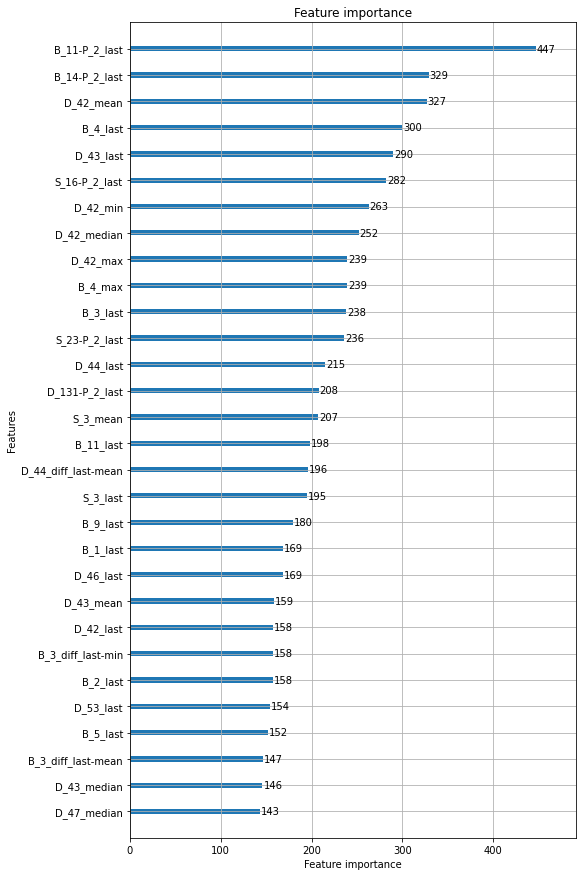

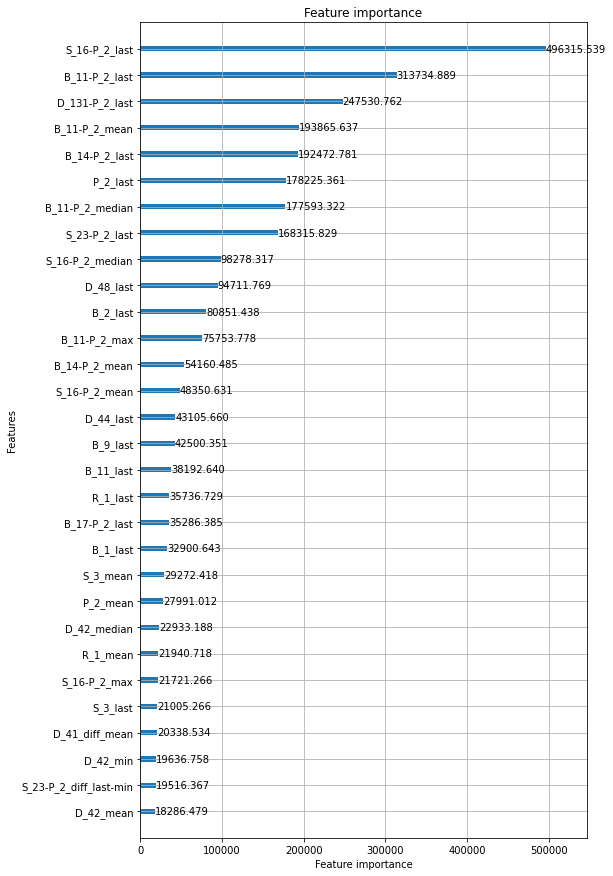

######################################## training model 2/5 ########################################
seed: 1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.749904	valid_0's recall_at4: 0.600606	valid_0's norm_gini: 0.899203


[100]	valid_0's amex_metric: 0.762517	valid_0's recall_at4: 0.618699	valid_0's norm_gini: 0.906335


[150]	valid_0's amex_metric: 0.772001	valid_0's recall_at4: 0.6325	valid_0's norm_gini: 0.911503


[200]	valid_0's amex_metric: 0.776522	valid_0's recall_at4: 0.638643	valid_0's norm_gini: 0.9144


[250]	valid_0's amex_metric: 0.779855	valid_0's recall_at4: 0.643651	valid_0's norm_gini: 0.916059


[300]	valid_0's amex_metric: 0.782672	valid_0's recall_at4: 0.6479	valid_0's norm_gini: 0.917444


[350]	valid_0's amex_metric: 0.785094	valid_0's recall_at4: 0.651519	valid_0's norm_gini: 0.918669


[400]	valid_0's amex_metric: 0.786354	valid_0's recall_at4: 0.653412	valid_0's norm_gini: 0.919295


[450]	valid_0's amex_metric: 0.787638	valid_0's recall_at4: 0.65518	valid_0's norm_gini: 0.920097


[500]	valid_0's amex_metric: 0.789543	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.920836


[550]	valid_0's amex_metric: 0.790514	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.921345


[600]	valid_0's amex_metric: 0.791966	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.921893


[650]	valid_0's amex_metric: 0.792727	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.922363


[700]	valid_0's amex_metric: 0.793681	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.922715


[750]	valid_0's amex_metric: 0.793554	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.922966


[800]	valid_0's amex_metric: 0.7939	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.923322


[850]	valid_0's amex_metric: 0.79464	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.92354


[900]	valid_0's amex_metric: 0.794618	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.923748


[950]	valid_0's amex_metric: 0.794852	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.923878


[1000]	valid_0's amex_metric: 0.795248	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.92404


[1050]	valid_0's amex_metric: 0.795263	valid_0's recall_at4: 0.66633	valid_0's norm_gini: 0.924195


[1100]	valid_0's amex_metric: 0.79564	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.924319


[1150]	valid_0's amex_metric: 0.796029	valid_0's recall_at4: 0.667634	valid_0's norm_gini: 0.924424


[1200]	valid_0's amex_metric: 0.796366	valid_0's recall_at4: 0.668181	valid_0's norm_gini: 0.924551


[1250]	valid_0's amex_metric: 0.796788	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.924637


[1300]	valid_0's amex_metric: 0.796665	valid_0's recall_at4: 0.66856	valid_0's norm_gini: 0.924771


[1350]	valid_0's amex_metric: 0.796446	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.924879


[1400]	valid_0's amex_metric: 0.796947	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.924955


[1450]	valid_0's amex_metric: 0.797025	valid_0's recall_at4: 0.669023	valid_0's norm_gini: 0.925027


[1500]	valid_0's amex_metric: 0.796998	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.9251


[1550]	valid_0's amex_metric: 0.796694	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.925164


[1600]	valid_0's amex_metric: 0.796725	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.925227


[1650]	valid_0's amex_metric: 0.797322	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.925285


[1700]	valid_0's amex_metric: 0.79729	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925388


[1750]	valid_0's amex_metric: 0.797535	valid_0's recall_at4: 0.669654	valid_0's norm_gini: 0.925417


[1800]	valid_0's amex_metric: 0.797436	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.925471


[1850]	valid_0's amex_metric: 0.797857	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.925512


[1900]	valid_0's amex_metric: 0.798028	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.925561


[1950]	valid_0's amex_metric: 0.798069	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.9256


[2000]	valid_0's amex_metric: 0.7985	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925622


[2050]	valid_0's amex_metric: 0.798283	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.92565


[2100]	valid_0's amex_metric: 0.798275	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925676


[2150]	valid_0's amex_metric: 0.798631	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.925715


[2200]	valid_0's amex_metric: 0.798619	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.925732


[2250]	valid_0's amex_metric: 0.79899	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.92576


[2300]	valid_0's amex_metric: 0.798743	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.92577


[2350]	valid_0's amex_metric: 0.798887	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.925806


[2400]	valid_0's amex_metric: 0.799113	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.925836


[2450]	valid_0's amex_metric: 0.79974	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.92587


[2500]	valid_0's amex_metric: 0.799792	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.925889


[2550]	valid_0's amex_metric: 0.799906	valid_0's recall_at4: 0.673904	valid_0's norm_gini: 0.925909


[2600]	valid_0's amex_metric: 0.7996	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.925928


[2650]	valid_0's amex_metric: 0.799465	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.925909


[2700]	valid_0's amex_metric: 0.7994	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.925906


[2750]	valid_0's amex_metric: 0.79878	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.925927


[2800]	valid_0's amex_metric: 0.799274	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.925948


[2850]	valid_0's amex_metric: 0.799293	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.925945


[2900]	valid_0's amex_metric: 0.799678	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925957


[2950]	valid_0's amex_metric: 0.799404	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.925957


[3000]	valid_0's amex_metric: 0.799499	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.925977


[3050]	valid_0's amex_metric: 0.799498	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.925976


[3100]	valid_0's amex_metric: 0.799567	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.925987


[3150]	valid_0's amex_metric: 0.79926	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.926004


[3200]	valid_0's amex_metric: 0.799887	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.925996


[3250]	valid_0's amex_metric: 0.799582	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926017


[3300]	valid_0's amex_metric: 0.799791	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926015


[3350]	valid_0's amex_metric: 0.799725	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.926009


[3400]	valid_0's amex_metric: 0.799756	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.926028


[3450]	valid_0's amex_metric: 0.800145	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926049


[3500]	valid_0's amex_metric: 0.800173	valid_0's recall_at4: 0.674283	valid_0's norm_gini: 0.926064


[3550]	valid_0's amex_metric: 0.799674	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.926033


[3600]	valid_0's amex_metric: 0.800255	valid_0's recall_at4: 0.674451	valid_0's norm_gini: 0.926059


[3650]	valid_0's amex_metric: 0.800326	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.926075


[3700]	valid_0's amex_metric: 0.799643	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926097


[3750]	valid_0's amex_metric: 0.79942	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.926114


[3800]	valid_0's amex_metric: 0.799346	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926134


[3850]	valid_0's amex_metric: 0.799945	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.926154


[3900]	valid_0's amex_metric: 0.79999	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.92616


[3950]	valid_0's amex_metric: 0.800032	valid_0's recall_at4: 0.673904	valid_0's norm_gini: 0.926161


[4000]	valid_0's amex_metric: 0.800323	valid_0's recall_at4: 0.674493	valid_0's norm_gini: 0.926154


[4050]	valid_0's amex_metric: 0.799778	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926156


[4100]	valid_0's amex_metric: 0.799719	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.926165


[4150]	valid_0's amex_metric: 0.799527	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.926161


[4200]	valid_0's amex_metric: 0.799621	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.92618


[4250]	valid_0's amex_metric: 0.799525	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.926198


[4300]	valid_0's amex_metric: 0.799383	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926209


[4350]	valid_0's amex_metric: 0.799297	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.926204


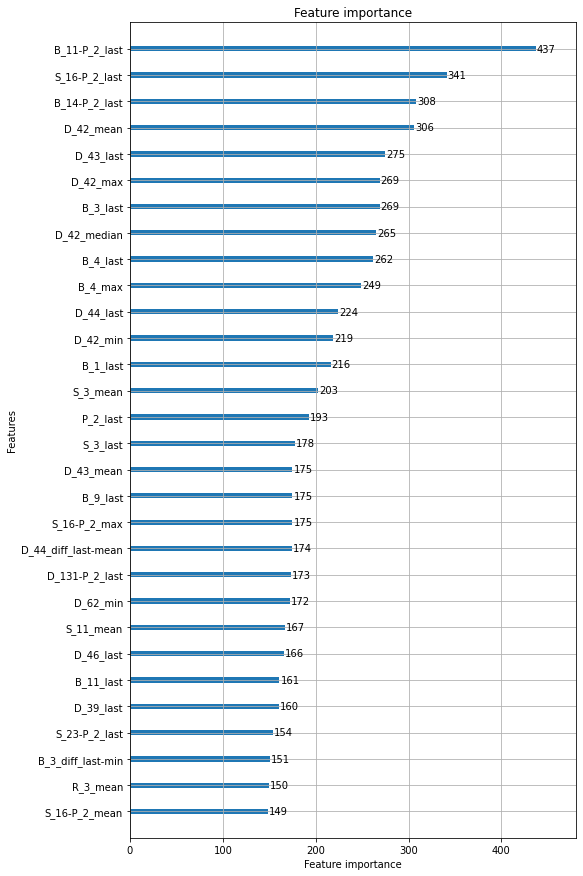

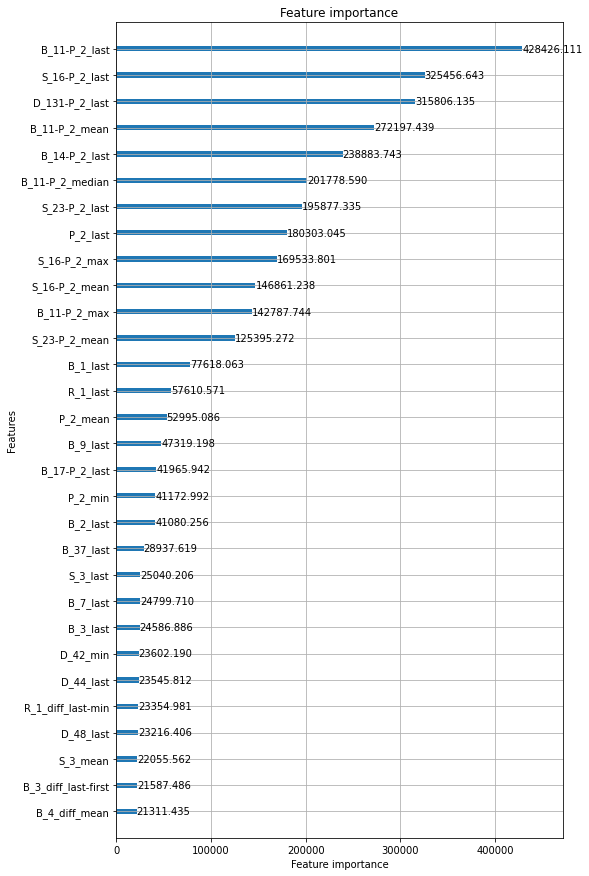

######################################## training model 3/5 ########################################
seed: 2


[50]	valid_0's amex_metric: 0.749233	valid_0's recall_at4: 0.598965	valid_0's norm_gini: 0.899501


[100]	valid_0's amex_metric: 0.760164	valid_0's recall_at4: 0.613776	valid_0's norm_gini: 0.906551


[150]	valid_0's amex_metric: 0.766653	valid_0's recall_at4: 0.62278	valid_0's norm_gini: 0.910525


[200]	valid_0's amex_metric: 0.76926	valid_0's recall_at4: 0.626273	valid_0's norm_gini: 0.912248


[250]	valid_0's amex_metric: 0.772201	valid_0's recall_at4: 0.630396	valid_0's norm_gini: 0.914007


[300]	valid_0's amex_metric: 0.776062	valid_0's recall_at4: 0.636203	valid_0's norm_gini: 0.915922


[350]	valid_0's amex_metric: 0.779031	valid_0's recall_at4: 0.640705	valid_0's norm_gini: 0.917357


[400]	valid_0's amex_metric: 0.78042	valid_0's recall_at4: 0.642893	valid_0's norm_gini: 0.917946


[450]	valid_0's amex_metric: 0.781856	valid_0's recall_at4: 0.645039	valid_0's norm_gini: 0.918673


[500]	valid_0's amex_metric: 0.784934	valid_0's recall_at4: 0.650341	valid_0's norm_gini: 0.919527


[550]	valid_0's amex_metric: 0.786309	valid_0's recall_at4: 0.652487	valid_0's norm_gini: 0.920131


[600]	valid_0's amex_metric: 0.786632	valid_0's recall_at4: 0.652781	valid_0's norm_gini: 0.920483


[650]	valid_0's amex_metric: 0.787151	valid_0's recall_at4: 0.653412	valid_0's norm_gini: 0.92089


[700]	valid_0's amex_metric: 0.788359	valid_0's recall_at4: 0.655474	valid_0's norm_gini: 0.921243


[750]	valid_0's amex_metric: 0.788629	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.921531


[800]	valid_0's amex_metric: 0.789583	valid_0's recall_at4: 0.657368	valid_0's norm_gini: 0.921799


[850]	valid_0's amex_metric: 0.789809	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.921997


[900]	valid_0's amex_metric: 0.789741	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.922156


[950]	valid_0's amex_metric: 0.78995	valid_0's recall_at4: 0.657536	valid_0's norm_gini: 0.922364


[1000]	valid_0's amex_metric: 0.79023	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.922545


[1050]	valid_0's amex_metric: 0.790783	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.922725


[1100]	valid_0's amex_metric: 0.790885	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.922888


[1150]	valid_0's amex_metric: 0.79116	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.922976


[1200]	valid_0's amex_metric: 0.79098	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.923078


[1250]	valid_0's amex_metric: 0.791592	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.923166


[1300]	valid_0's amex_metric: 0.79116	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.923227


[1350]	valid_0's amex_metric: 0.791862	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.923326


[1400]	valid_0's amex_metric: 0.791662	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.923389


[1450]	valid_0's amex_metric: 0.792198	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.923493


[1500]	valid_0's amex_metric: 0.792148	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.923562


[1550]	valid_0's amex_metric: 0.792263	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.923625


[1600]	valid_0's amex_metric: 0.792356	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.923683


[1650]	valid_0's amex_metric: 0.792907	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.923776


[1700]	valid_0's amex_metric: 0.793017	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.923827


[1750]	valid_0's amex_metric: 0.793194	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.923887


[1800]	valid_0's amex_metric: 0.793538	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.923901


[1850]	valid_0's amex_metric: 0.793287	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.923947


[1900]	valid_0's amex_metric: 0.793531	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.923971


[1950]	valid_0's amex_metric: 0.792901	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.924015


[2000]	valid_0's amex_metric: 0.792835	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924052


[2050]	valid_0's amex_metric: 0.793291	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.92408


[2100]	valid_0's amex_metric: 0.793102	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.924081


[2150]	valid_0's amex_metric: 0.79337	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.924114


[2200]	valid_0's amex_metric: 0.792962	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.924139


[2250]	valid_0's amex_metric: 0.792894	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924171


[2300]	valid_0's amex_metric: 0.792851	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.924212


[2350]	valid_0's amex_metric: 0.792904	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.924233


[2400]	valid_0's amex_metric: 0.792823	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.924239


[2450]	valid_0's amex_metric: 0.792589	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.924234


[2500]	valid_0's amex_metric: 0.792754	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.92427


[2550]	valid_0's amex_metric: 0.792527	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.924277


[2600]	valid_0's amex_metric: 0.792902	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.924313


[2650]	valid_0's amex_metric: 0.79308	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.924332


[2700]	valid_0's amex_metric: 0.793477	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.924369


[2750]	valid_0's amex_metric: 0.793459	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.924375


[2800]	valid_0's amex_metric: 0.793734	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.924419


[2850]	valid_0's amex_metric: 0.794148	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.924449


[2900]	valid_0's amex_metric: 0.794229	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.924441


[2950]	valid_0's amex_metric: 0.794305	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924468


[3000]	valid_0's amex_metric: 0.794456	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.924474


[3050]	valid_0's amex_metric: 0.794322	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924501


[3100]	valid_0's amex_metric: 0.793978	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.924488


[3150]	valid_0's amex_metric: 0.794051	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.924508


[3200]	valid_0's amex_metric: 0.794226	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.92452


[3250]	valid_0's amex_metric: 0.794124	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.924526


[3300]	valid_0's amex_metric: 0.794105	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.924531


[3350]	valid_0's amex_metric: 0.79442	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.92453


[3400]	valid_0's amex_metric: 0.794273	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.92453


[3450]	valid_0's amex_metric: 0.79453	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.92454


[3500]	valid_0's amex_metric: 0.794178	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.924551


[3550]	valid_0's amex_metric: 0.794554	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.924544


[3600]	valid_0's amex_metric: 0.794769	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924555


[3650]	valid_0's amex_metric: 0.794349	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924556


[3700]	valid_0's amex_metric: 0.794316	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.924573


[3750]	valid_0's amex_metric: 0.794293	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.92457


[3800]	valid_0's amex_metric: 0.793725	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.924571


[3850]	valid_0's amex_metric: 0.793913	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.924567


[3900]	valid_0's amex_metric: 0.793456	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.92458


[3950]	valid_0's amex_metric: 0.793948	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924596


[4000]	valid_0's amex_metric: 0.79428	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.924586


[4050]	valid_0's amex_metric: 0.793946	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924592


[4100]	valid_0's amex_metric: 0.794369	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924596


[4150]	valid_0's amex_metric: 0.794367	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924592


[4200]	valid_0's amex_metric: 0.794175	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.924587


[4250]	valid_0's amex_metric: 0.794358	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924573


[4300]	valid_0's amex_metric: 0.794779	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924574


[4350]	valid_0's amex_metric: 0.794554	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.924587


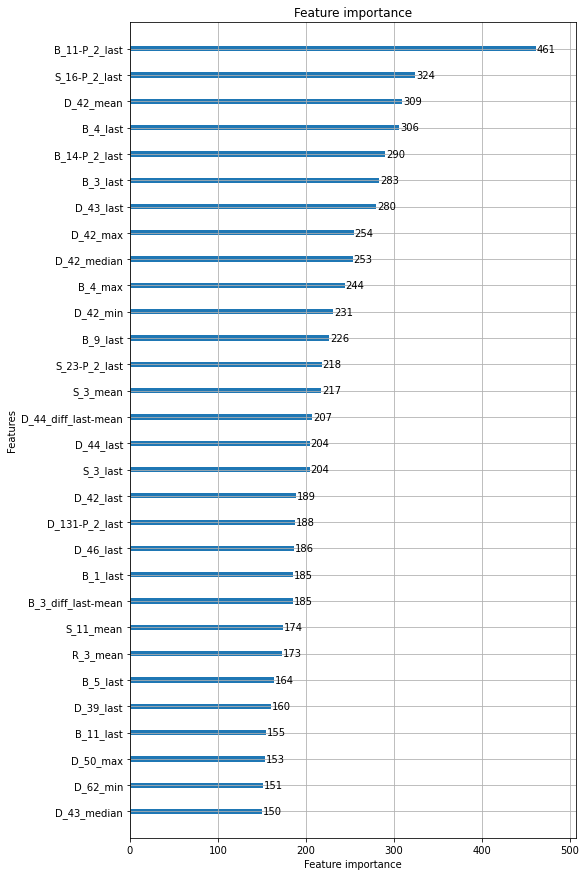

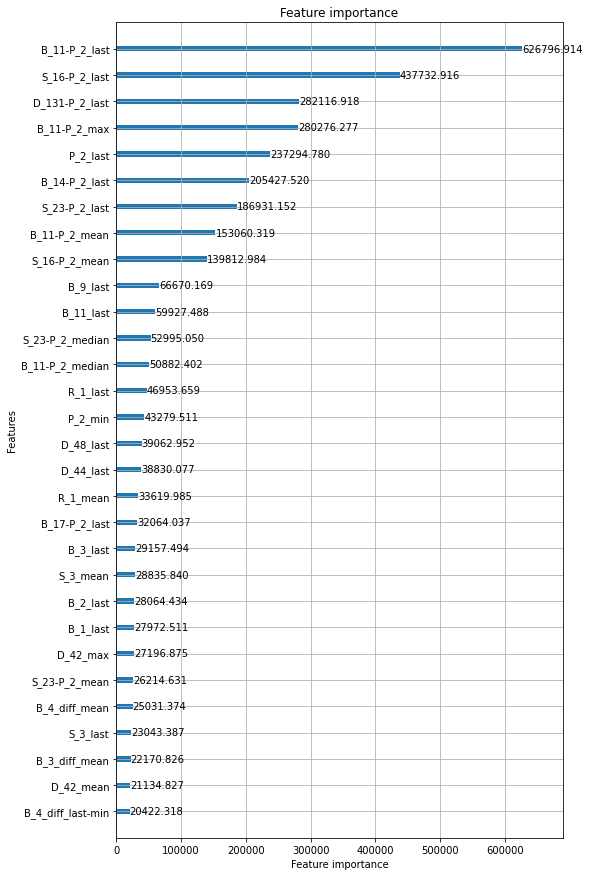

######################################## training model 4/5 ########################################
seed: 3


[50]	valid_0's amex_metric: 0.747693	valid_0's recall_at4: 0.596844	valid_0's norm_gini: 0.898542


[100]	valid_0's amex_metric: 0.75883	valid_0's recall_at4: 0.612329	valid_0's norm_gini: 0.905332


[150]	valid_0's amex_metric: 0.767379	valid_0's recall_at4: 0.624237	valid_0's norm_gini: 0.910521


[200]	valid_0's amex_metric: 0.773221	valid_0's recall_at4: 0.632863	valid_0's norm_gini: 0.913578


[250]	valid_0's amex_metric: 0.776135	valid_0's recall_at4: 0.636903	valid_0's norm_gini: 0.915367


[300]	valid_0's amex_metric: 0.777784	valid_0's recall_at4: 0.638923	valid_0's norm_gini: 0.916644


[350]	valid_0's amex_metric: 0.780102	valid_0's recall_at4: 0.642289	valid_0's norm_gini: 0.917914


[400]	valid_0's amex_metric: 0.781371	valid_0's recall_at4: 0.643888	valid_0's norm_gini: 0.918853


[450]	valid_0's amex_metric: 0.782224	valid_0's recall_at4: 0.645066	valid_0's norm_gini: 0.919382


[500]	valid_0's amex_metric: 0.783282	valid_0's recall_at4: 0.646497	valid_0's norm_gini: 0.920068


[550]	valid_0's amex_metric: 0.784593	valid_0's recall_at4: 0.648601	valid_0's norm_gini: 0.920586


[600]	valid_0's amex_metric: 0.784764	valid_0's recall_at4: 0.648517	valid_0's norm_gini: 0.921011


[650]	valid_0's amex_metric: 0.785531	valid_0's recall_at4: 0.649695	valid_0's norm_gini: 0.921368


[700]	valid_0's amex_metric: 0.78664	valid_0's recall_at4: 0.651673	valid_0's norm_gini: 0.921607


[750]	valid_0's amex_metric: 0.787202	valid_0's recall_at4: 0.652472	valid_0's norm_gini: 0.921931


[800]	valid_0's amex_metric: 0.78738	valid_0's recall_at4: 0.652598	valid_0's norm_gini: 0.922162


[850]	valid_0's amex_metric: 0.788593	valid_0's recall_at4: 0.65466	valid_0's norm_gini: 0.922525


[900]	valid_0's amex_metric: 0.788324	valid_0's recall_at4: 0.653903	valid_0's norm_gini: 0.922746


[950]	valid_0's amex_metric: 0.788615	valid_0's recall_at4: 0.654281	valid_0's norm_gini: 0.922949


[1000]	valid_0's amex_metric: 0.789109	valid_0's recall_at4: 0.655081	valid_0's norm_gini: 0.923137


[1050]	valid_0's amex_metric: 0.789744	valid_0's recall_at4: 0.656217	valid_0's norm_gini: 0.92327


[1100]	valid_0's amex_metric: 0.789886	valid_0's recall_at4: 0.656385	valid_0's norm_gini: 0.923387


[1150]	valid_0's amex_metric: 0.790873	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.923467


[1200]	valid_0's amex_metric: 0.791352	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.923582


[1250]	valid_0's amex_metric: 0.791699	valid_0's recall_at4: 0.65971	valid_0's norm_gini: 0.923688


[1300]	valid_0's amex_metric: 0.792317	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.923829


[1350]	valid_0's amex_metric: 0.792127	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.923912


[1400]	valid_0's amex_metric: 0.791451	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.923992


[1450]	valid_0's amex_metric: 0.792002	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924042


[1500]	valid_0's amex_metric: 0.792336	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.924078


[1550]	valid_0's amex_metric: 0.792337	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.924164


[1600]	valid_0's amex_metric: 0.792569	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.924249


[1650]	valid_0's amex_metric: 0.792544	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924283


[1700]	valid_0's amex_metric: 0.79329	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.924345


[1750]	valid_0's amex_metric: 0.793341	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924406


[1800]	valid_0's amex_metric: 0.793402	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.924443


[1850]	valid_0's amex_metric: 0.793481	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.924474


[1900]	valid_0's amex_metric: 0.793334	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.924517


[1950]	valid_0's amex_metric: 0.794006	valid_0's recall_at4: 0.663413	valid_0's norm_gini: 0.924599


[2000]	valid_0's amex_metric: 0.794049	valid_0's recall_at4: 0.663455	valid_0's norm_gini: 0.924643


[2050]	valid_0's amex_metric: 0.793966	valid_0's recall_at4: 0.663244	valid_0's norm_gini: 0.924687


[2100]	valid_0's amex_metric: 0.793602	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.924717


[2150]	valid_0's amex_metric: 0.793489	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.924744


[2200]	valid_0's amex_metric: 0.793657	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.924785


[2250]	valid_0's amex_metric: 0.793714	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.924814


[2300]	valid_0's amex_metric: 0.793944	valid_0's recall_at4: 0.663076	valid_0's norm_gini: 0.924811


[2350]	valid_0's amex_metric: 0.793803	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.924825


[2400]	valid_0's amex_metric: 0.793232	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.924818


[2450]	valid_0's amex_metric: 0.793061	valid_0's recall_at4: 0.661267	valid_0's norm_gini: 0.924855


[2500]	valid_0's amex_metric: 0.793041	valid_0's recall_at4: 0.661224	valid_0's norm_gini: 0.924857


[2550]	valid_0's amex_metric: 0.7934	valid_0's recall_at4: 0.66194	valid_0's norm_gini: 0.924861


[2600]	valid_0's amex_metric: 0.79396	valid_0's recall_at4: 0.663076	valid_0's norm_gini: 0.924844


[2650]	valid_0's amex_metric: 0.793948	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.924862


[2700]	valid_0's amex_metric: 0.793549	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.924863


[2750]	valid_0's amex_metric: 0.793643	valid_0's recall_at4: 0.662403	valid_0's norm_gini: 0.924883


[2800]	valid_0's amex_metric: 0.793699	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.924911


[2850]	valid_0's amex_metric: 0.794123	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924917


[2900]	valid_0's amex_metric: 0.794427	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.924936


[2950]	valid_0's amex_metric: 0.793863	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.924945


[3000]	valid_0's amex_metric: 0.794107	valid_0's recall_at4: 0.663244	valid_0's norm_gini: 0.924969


[3050]	valid_0's amex_metric: 0.794033	valid_0's recall_at4: 0.663076	valid_0's norm_gini: 0.92499


[3100]	valid_0's amex_metric: 0.793738	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.92499


[3150]	valid_0's amex_metric: 0.794499	valid_0's recall_at4: 0.664002	valid_0's norm_gini: 0.924996


[3200]	valid_0's amex_metric: 0.794142	valid_0's recall_at4: 0.663286	valid_0's norm_gini: 0.924997


[3250]	valid_0's amex_metric: 0.794467	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.925016


[3300]	valid_0's amex_metric: 0.794123	valid_0's recall_at4: 0.663244	valid_0's norm_gini: 0.925001


[3350]	valid_0's amex_metric: 0.793896	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.925011


[3400]	valid_0's amex_metric: 0.793816	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.925019


[3450]	valid_0's amex_metric: 0.79376	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.925033


[3500]	valid_0's amex_metric: 0.793698	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.925036


[3550]	valid_0's amex_metric: 0.793639	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.925043


[3600]	valid_0's amex_metric: 0.793892	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.925044


[3650]	valid_0's amex_metric: 0.794193	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.925058


[3700]	valid_0's amex_metric: 0.793838	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.925062


[3750]	valid_0's amex_metric: 0.79404	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.925046


[3800]	valid_0's amex_metric: 0.794139	valid_0's recall_at4: 0.663244	valid_0's norm_gini: 0.925033


[3850]	valid_0's amex_metric: 0.794124	valid_0's recall_at4: 0.663202	valid_0's norm_gini: 0.925046


[3900]	valid_0's amex_metric: 0.794258	valid_0's recall_at4: 0.663455	valid_0's norm_gini: 0.925062


[3950]	valid_0's amex_metric: 0.793866	valid_0's recall_at4: 0.662655	valid_0's norm_gini: 0.925076


[4000]	valid_0's amex_metric: 0.793724	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.925087


[4050]	valid_0's amex_metric: 0.793802	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.925118


[4100]	valid_0's amex_metric: 0.793826	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.925123


[4150]	valid_0's amex_metric: 0.793971	valid_0's recall_at4: 0.662823	valid_0's norm_gini: 0.925118


[4200]	valid_0's amex_metric: 0.794239	valid_0's recall_at4: 0.66337	valid_0's norm_gini: 0.925107


[4250]	valid_0's amex_metric: 0.794218	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.925107


[4300]	valid_0's amex_metric: 0.793861	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.925109


[4350]	valid_0's amex_metric: 0.793985	valid_0's recall_at4: 0.662866	valid_0's norm_gini: 0.925104


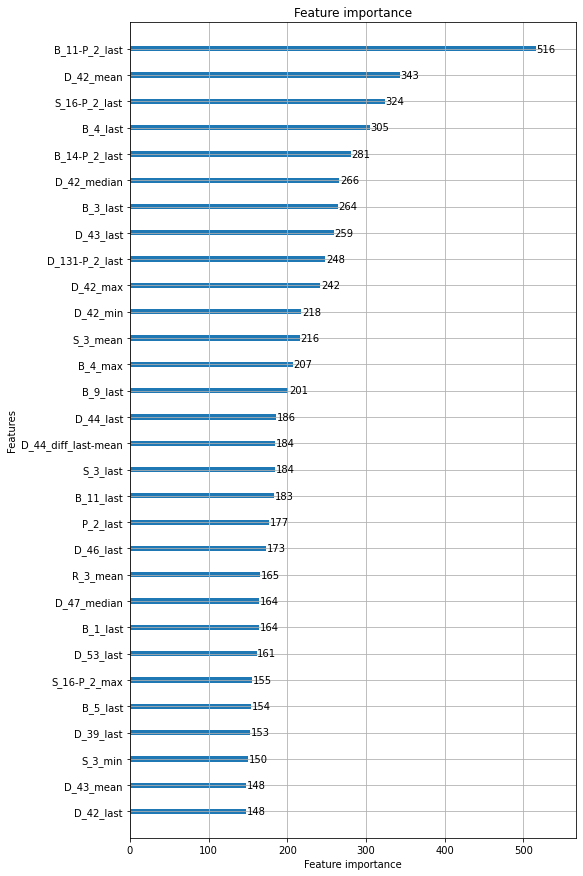

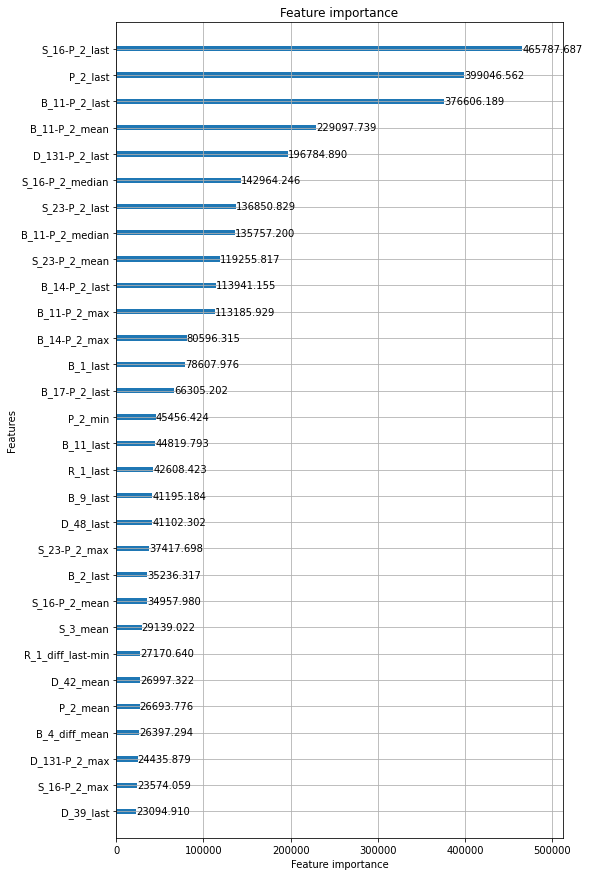

######################################## training model 5/5 ########################################
seed: 4


[50]	valid_0's amex_metric: 0.753614	valid_0's recall_at4: 0.605134	valid_0's norm_gini: 0.902095


[100]	valid_0's amex_metric: 0.765183	valid_0's recall_at4: 0.622344	valid_0's norm_gini: 0.908023


[150]	valid_0's amex_metric: 0.77422	valid_0's recall_at4: 0.635514	valid_0's norm_gini: 0.912925


[200]	valid_0's amex_metric: 0.780617	valid_0's recall_at4: 0.644856	valid_0's norm_gini: 0.916379


[250]	valid_0's amex_metric: 0.78346	valid_0's recall_at4: 0.648517	valid_0's norm_gini: 0.918402


[300]	valid_0's amex_metric: 0.785592	valid_0's recall_at4: 0.651378	valid_0's norm_gini: 0.919806


[350]	valid_0's amex_metric: 0.787316	valid_0's recall_at4: 0.653692	valid_0's norm_gini: 0.92094


[400]	valid_0's amex_metric: 0.789441	valid_0's recall_at4: 0.656764	valid_0's norm_gini: 0.922117


[450]	valid_0's amex_metric: 0.791083	valid_0's recall_at4: 0.659583	valid_0's norm_gini: 0.922583


[500]	valid_0's amex_metric: 0.792231	valid_0's recall_at4: 0.661351	valid_0's norm_gini: 0.923112


[550]	valid_0's amex_metric: 0.793009	valid_0's recall_at4: 0.662403	valid_0's norm_gini: 0.923615


[600]	valid_0's amex_metric: 0.793678	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924027


[650]	valid_0's amex_metric: 0.793851	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924374


[700]	valid_0's amex_metric: 0.793978	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924627


[750]	valid_0's amex_metric: 0.795696	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.924992


[800]	valid_0's amex_metric: 0.796501	valid_0's recall_at4: 0.667789	valid_0's norm_gini: 0.925214


[850]	valid_0's amex_metric: 0.796468	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.9254


[900]	valid_0's amex_metric: 0.797133	valid_0's recall_at4: 0.668672	valid_0's norm_gini: 0.925594


[950]	valid_0's amex_metric: 0.797488	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925757


[1000]	valid_0's amex_metric: 0.797692	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.925913


[1050]	valid_0's amex_metric: 0.797712	valid_0's recall_at4: 0.669304	valid_0's norm_gini: 0.926121


[1100]	valid_0's amex_metric: 0.798186	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.926268


[1150]	valid_0's amex_metric: 0.798719	valid_0's recall_at4: 0.671029	valid_0's norm_gini: 0.926408


[1200]	valid_0's amex_metric: 0.798972	valid_0's recall_at4: 0.671408	valid_0's norm_gini: 0.926536


[1250]	valid_0's amex_metric: 0.798756	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.926609


[1300]	valid_0's amex_metric: 0.79916	valid_0's recall_at4: 0.671576	valid_0's norm_gini: 0.926744


[1350]	valid_0's amex_metric: 0.800069	valid_0's recall_at4: 0.673301	valid_0's norm_gini: 0.926836


[1400]	valid_0's amex_metric: 0.800435	valid_0's recall_at4: 0.673932	valid_0's norm_gini: 0.926938


[1450]	valid_0's amex_metric: 0.800603	valid_0's recall_at4: 0.674185	valid_0's norm_gini: 0.927022


[1500]	valid_0's amex_metric: 0.800054	valid_0's recall_at4: 0.673007	valid_0's norm_gini: 0.927102


[1550]	valid_0's amex_metric: 0.800305	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.927183


[1600]	valid_0's amex_metric: 0.80054	valid_0's recall_at4: 0.673806	valid_0's norm_gini: 0.927274


[1650]	valid_0's amex_metric: 0.800914	valid_0's recall_at4: 0.674479	valid_0's norm_gini: 0.927349


[1700]	valid_0's amex_metric: 0.801075	valid_0's recall_at4: 0.674732	valid_0's norm_gini: 0.927418


[1750]	valid_0's amex_metric: 0.800734	valid_0's recall_at4: 0.674016	valid_0's norm_gini: 0.927451


[1800]	valid_0's amex_metric: 0.801098	valid_0's recall_at4: 0.67469	valid_0's norm_gini: 0.927507


[1850]	valid_0's amex_metric: 0.80135	valid_0's recall_at4: 0.675153	valid_0's norm_gini: 0.927547


[1900]	valid_0's amex_metric: 0.801373	valid_0's recall_at4: 0.675153	valid_0's norm_gini: 0.927594


[1950]	valid_0's amex_metric: 0.801831	valid_0's recall_at4: 0.676036	valid_0's norm_gini: 0.927625


[2000]	valid_0's amex_metric: 0.801992	valid_0's recall_at4: 0.676331	valid_0's norm_gini: 0.927654


[2050]	valid_0's amex_metric: 0.801934	valid_0's recall_at4: 0.676162	valid_0's norm_gini: 0.927705


[2100]	valid_0's amex_metric: 0.802386	valid_0's recall_at4: 0.677046	valid_0's norm_gini: 0.927726


[2150]	valid_0's amex_metric: 0.802636	valid_0's recall_at4: 0.677509	valid_0's norm_gini: 0.927763


[2200]	valid_0's amex_metric: 0.802926	valid_0's recall_at4: 0.678056	valid_0's norm_gini: 0.927796


[2250]	valid_0's amex_metric: 0.802785	valid_0's recall_at4: 0.677719	valid_0's norm_gini: 0.92785


[2300]	valid_0's amex_metric: 0.802376	valid_0's recall_at4: 0.676878	valid_0's norm_gini: 0.927875


[2350]	valid_0's amex_metric: 0.802217	valid_0's recall_at4: 0.676541	valid_0's norm_gini: 0.927893


[2400]	valid_0's amex_metric: 0.802618	valid_0's recall_at4: 0.677299	valid_0's norm_gini: 0.927937


[2450]	valid_0's amex_metric: 0.802368	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927942


[2500]	valid_0's amex_metric: 0.802243	valid_0's recall_at4: 0.676541	valid_0's norm_gini: 0.927945


[2550]	valid_0's amex_metric: 0.802111	valid_0's recall_at4: 0.676247	valid_0's norm_gini: 0.927975


[2600]	valid_0's amex_metric: 0.802524	valid_0's recall_at4: 0.677046	valid_0's norm_gini: 0.928001


[2650]	valid_0's amex_metric: 0.801989	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.928025


[2700]	valid_0's amex_metric: 0.802427	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.928061


[2750]	valid_0's amex_metric: 0.802765	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.928106


[2800]	valid_0's amex_metric: 0.803033	valid_0's recall_at4: 0.677972	valid_0's norm_gini: 0.928094


[2850]	valid_0's amex_metric: 0.802684	valid_0's recall_at4: 0.677256	valid_0's norm_gini: 0.928112


[2900]	valid_0's amex_metric: 0.80299	valid_0's recall_at4: 0.677846	valid_0's norm_gini: 0.928135


[2950]	valid_0's amex_metric: 0.802823	valid_0's recall_at4: 0.677509	valid_0's norm_gini: 0.928137


[3000]	valid_0's amex_metric: 0.802309	valid_0's recall_at4: 0.676457	valid_0's norm_gini: 0.928161


[3050]	valid_0's amex_metric: 0.803073	valid_0's recall_at4: 0.677972	valid_0's norm_gini: 0.928175


[3100]	valid_0's amex_metric: 0.802491	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.928188


[3150]	valid_0's amex_metric: 0.802497	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.928201


[3200]	valid_0's amex_metric: 0.802959	valid_0's recall_at4: 0.677719	valid_0's norm_gini: 0.928199


[3250]	valid_0's amex_metric: 0.803342	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.928207


[3300]	valid_0's amex_metric: 0.803473	valid_0's recall_at4: 0.678729	valid_0's norm_gini: 0.928217


[3350]	valid_0's amex_metric: 0.803467	valid_0's recall_at4: 0.678729	valid_0's norm_gini: 0.928204


[3400]	valid_0's amex_metric: 0.803377	valid_0's recall_at4: 0.678561	valid_0's norm_gini: 0.928192


[3450]	valid_0's amex_metric: 0.803458	valid_0's recall_at4: 0.678729	valid_0's norm_gini: 0.928186


[3500]	valid_0's amex_metric: 0.803737	valid_0's recall_at4: 0.679276	valid_0's norm_gini: 0.928198


[3550]	valid_0's amex_metric: 0.803482	valid_0's recall_at4: 0.678771	valid_0's norm_gini: 0.928193


[3600]	valid_0's amex_metric: 0.803337	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.928197


[3650]	valid_0's amex_metric: 0.802892	valid_0's recall_at4: 0.677593	valid_0's norm_gini: 0.92819


[3700]	valid_0's amex_metric: 0.802702	valid_0's recall_at4: 0.677214	valid_0's norm_gini: 0.928189


[3750]	valid_0's amex_metric: 0.802507	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.928221


[3800]	valid_0's amex_metric: 0.803023	valid_0's recall_at4: 0.677804	valid_0's norm_gini: 0.928242


[3850]	valid_0's amex_metric: 0.803107	valid_0's recall_at4: 0.677972	valid_0's norm_gini: 0.928242


[3900]	valid_0's amex_metric: 0.80275	valid_0's recall_at4: 0.677256	valid_0's norm_gini: 0.928243


[3950]	valid_0's amex_metric: 0.802796	valid_0's recall_at4: 0.677341	valid_0's norm_gini: 0.928251


[4000]	valid_0's amex_metric: 0.802909	valid_0's recall_at4: 0.677551	valid_0's norm_gini: 0.928266


[4050]	valid_0's amex_metric: 0.802846	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.928267


[4100]	valid_0's amex_metric: 0.80337	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.928264


[4150]	valid_0's amex_metric: 0.803518	valid_0's recall_at4: 0.678771	valid_0's norm_gini: 0.928264


[4200]	valid_0's amex_metric: 0.803243	valid_0's recall_at4: 0.678224	valid_0's norm_gini: 0.928262


[4250]	valid_0's amex_metric: 0.803466	valid_0's recall_at4: 0.678645	valid_0's norm_gini: 0.928287


[4300]	valid_0's amex_metric: 0.803617	valid_0's recall_at4: 0.67894	valid_0's norm_gini: 0.928295


[4350]	valid_0's amex_metric: 0.803402	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.928327


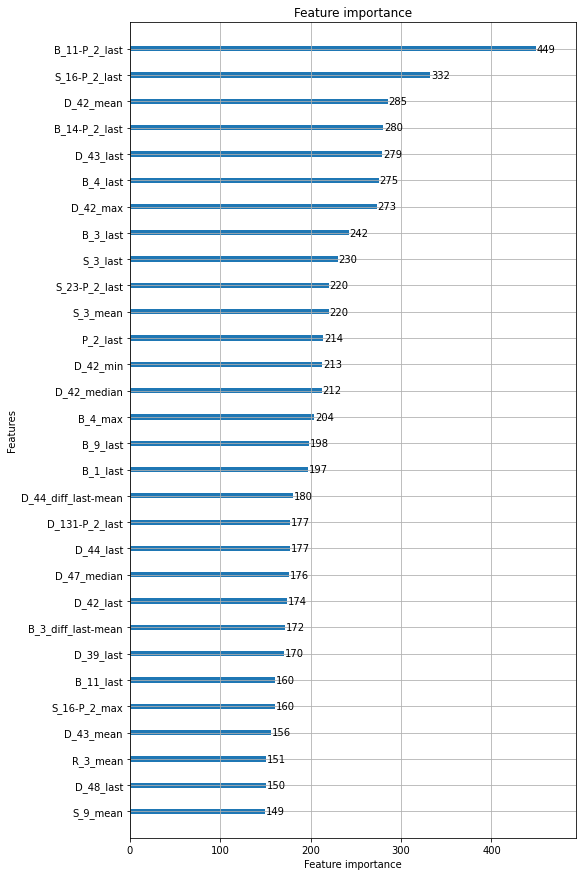

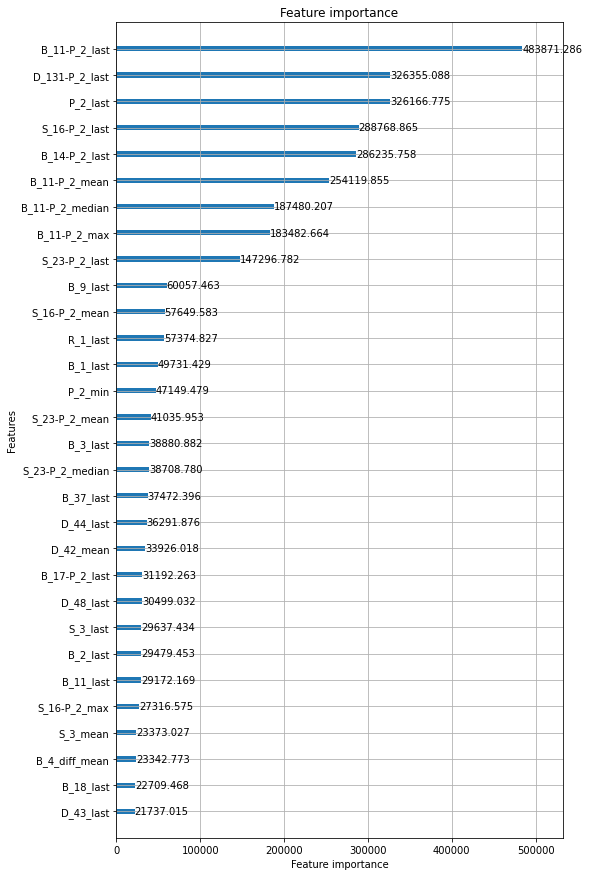

Training time: 39.317754010359444 min.


OOF recall_at4: 0.6699683576261487


OOF normalized_gini: 0.9260117459129162


OOF competition metric: 0.7979900517695324


############################### repeated cross-validation step: 2/5 ################################


######################################## training model 1/5 ########################################
seed: 5


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.752229	valid_0's recall_at4: 0.604898	valid_0's norm_gini: 0.899561


[100]	valid_0's amex_metric: 0.762553	valid_0's recall_at4: 0.619372	valid_0's norm_gini: 0.905734


[150]	valid_0's amex_metric: 0.770591	valid_0's recall_at4: 0.630943	valid_0's norm_gini: 0.910239


[200]	valid_0's amex_metric: 0.775932	valid_0's recall_at4: 0.638601	valid_0's norm_gini: 0.913263


[250]	valid_0's amex_metric: 0.778954	valid_0's recall_at4: 0.642767	valid_0's norm_gini: 0.915141


[300]	valid_0's amex_metric: 0.781884	valid_0's recall_at4: 0.646512	valid_0's norm_gini: 0.917255


[350]	valid_0's amex_metric: 0.785701	valid_0's recall_at4: 0.652655	valid_0's norm_gini: 0.918747


[400]	valid_0's amex_metric: 0.788909	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.920029


[450]	valid_0's amex_metric: 0.789941	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.920873


[500]	valid_0's amex_metric: 0.791047	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.921359


[550]	valid_0's amex_metric: 0.791841	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.921728


[600]	valid_0's amex_metric: 0.792503	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.922337


[650]	valid_0's amex_metric: 0.793546	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.922907


[700]	valid_0's amex_metric: 0.794151	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.923318


[750]	valid_0's amex_metric: 0.794669	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.923682


[800]	valid_0's amex_metric: 0.795551	valid_0's recall_at4: 0.667045	valid_0's norm_gini: 0.924056


[850]	valid_0's amex_metric: 0.795986	valid_0's recall_at4: 0.667634	valid_0's norm_gini: 0.924338


[900]	valid_0's amex_metric: 0.796448	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924547


[950]	valid_0's amex_metric: 0.797054	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.924748


[1000]	valid_0's amex_metric: 0.79785	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.92491


[1050]	valid_0's amex_metric: 0.797806	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.925075


[1100]	valid_0's amex_metric: 0.798332	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.925242


[1150]	valid_0's amex_metric: 0.798246	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.925365


[1200]	valid_0's amex_metric: 0.798486	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.925509


[1250]	valid_0's amex_metric: 0.798925	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.925587


[1300]	valid_0's amex_metric: 0.798652	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.925672


[1350]	valid_0's amex_metric: 0.799169	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.925739


[1400]	valid_0's amex_metric: 0.799787	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.925838


[1450]	valid_0's amex_metric: 0.800236	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.925938


[1500]	valid_0's amex_metric: 0.800547	valid_0's recall_at4: 0.67504	valid_0's norm_gini: 0.926055


[1550]	valid_0's amex_metric: 0.800441	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.926136


[1600]	valid_0's amex_metric: 0.800883	valid_0's recall_at4: 0.675587	valid_0's norm_gini: 0.92618


[1650]	valid_0's amex_metric: 0.801076	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926228


[1700]	valid_0's amex_metric: 0.801117	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926309


[1750]	valid_0's amex_metric: 0.801414	valid_0's recall_at4: 0.676471	valid_0's norm_gini: 0.926357


[1800]	valid_0's amex_metric: 0.801507	valid_0's recall_at4: 0.676597	valid_0's norm_gini: 0.926417


[1850]	valid_0's amex_metric: 0.800999	valid_0's recall_at4: 0.675545	valid_0's norm_gini: 0.926454


[1900]	valid_0's amex_metric: 0.800988	valid_0's recall_at4: 0.675503	valid_0's norm_gini: 0.926473


[1950]	valid_0's amex_metric: 0.801057	valid_0's recall_at4: 0.675587	valid_0's norm_gini: 0.926527


[2000]	valid_0's amex_metric: 0.801043	valid_0's recall_at4: 0.675503	valid_0's norm_gini: 0.926584


[2050]	valid_0's amex_metric: 0.801117	valid_0's recall_at4: 0.675629	valid_0's norm_gini: 0.926605


[2100]	valid_0's amex_metric: 0.801012	valid_0's recall_at4: 0.675377	valid_0's norm_gini: 0.926648


[2150]	valid_0's amex_metric: 0.800895	valid_0's recall_at4: 0.675124	valid_0's norm_gini: 0.926666


[2200]	valid_0's amex_metric: 0.800917	valid_0's recall_at4: 0.675124	valid_0's norm_gini: 0.92671


[2250]	valid_0's amex_metric: 0.801227	valid_0's recall_at4: 0.675713	valid_0's norm_gini: 0.926741


[2300]	valid_0's amex_metric: 0.801343	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926762


[2350]	valid_0's amex_metric: 0.800825	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.926778


[2400]	valid_0's amex_metric: 0.800919	valid_0's recall_at4: 0.674998	valid_0's norm_gini: 0.92684


[2450]	valid_0's amex_metric: 0.801376	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926829


[2500]	valid_0's amex_metric: 0.801816	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.926866


[2550]	valid_0's amex_metric: 0.801564	valid_0's recall_at4: 0.67626	valid_0's norm_gini: 0.926867


[2600]	valid_0's amex_metric: 0.801656	valid_0's recall_at4: 0.676428	valid_0's norm_gini: 0.926883


[2650]	valid_0's amex_metric: 0.801805	valid_0's recall_at4: 0.676723	valid_0's norm_gini: 0.926887


[2700]	valid_0's amex_metric: 0.801825	valid_0's recall_at4: 0.676723	valid_0's norm_gini: 0.926928


[2750]	valid_0's amex_metric: 0.801865	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.926964


[2800]	valid_0's amex_metric: 0.802037	valid_0's recall_at4: 0.677102	valid_0's norm_gini: 0.926971


[2850]	valid_0's amex_metric: 0.802222	valid_0's recall_at4: 0.67748	valid_0's norm_gini: 0.926964


[2900]	valid_0's amex_metric: 0.801947	valid_0's recall_at4: 0.676933	valid_0's norm_gini: 0.92696


[2950]	valid_0's amex_metric: 0.801729	valid_0's recall_at4: 0.676471	valid_0's norm_gini: 0.926987


[3000]	valid_0's amex_metric: 0.802123	valid_0's recall_at4: 0.67727	valid_0's norm_gini: 0.926975


[3050]	valid_0's amex_metric: 0.801822	valid_0's recall_at4: 0.676639	valid_0's norm_gini: 0.927005


[3100]	valid_0's amex_metric: 0.801835	valid_0's recall_at4: 0.676681	valid_0's norm_gini: 0.92699


[3150]	valid_0's amex_metric: 0.801453	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926982


[3200]	valid_0's amex_metric: 0.801879	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.926992


[3250]	valid_0's amex_metric: 0.801953	valid_0's recall_at4: 0.676891	valid_0's norm_gini: 0.927014


[3300]	valid_0's amex_metric: 0.802008	valid_0's recall_at4: 0.676975	valid_0's norm_gini: 0.927041


[3350]	valid_0's amex_metric: 0.801925	valid_0's recall_at4: 0.676807	valid_0's norm_gini: 0.927042


[3400]	valid_0's amex_metric: 0.802008	valid_0's recall_at4: 0.676933	valid_0's norm_gini: 0.927082


[3450]	valid_0's amex_metric: 0.801577	valid_0's recall_at4: 0.67605	valid_0's norm_gini: 0.927104


[3500]	valid_0's amex_metric: 0.801691	valid_0's recall_at4: 0.67626	valid_0's norm_gini: 0.927122


[3550]	valid_0's amex_metric: 0.801943	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.92712


[3600]	valid_0's amex_metric: 0.802135	valid_0's recall_at4: 0.677144	valid_0's norm_gini: 0.927126


[3650]	valid_0's amex_metric: 0.802536	valid_0's recall_at4: 0.677943	valid_0's norm_gini: 0.927129


[3700]	valid_0's amex_metric: 0.802186	valid_0's recall_at4: 0.677228	valid_0's norm_gini: 0.927144


[3750]	valid_0's amex_metric: 0.801866	valid_0's recall_at4: 0.676597	valid_0's norm_gini: 0.927135


[3800]	valid_0's amex_metric: 0.802367	valid_0's recall_at4: 0.677607	valid_0's norm_gini: 0.927127


[3850]	valid_0's amex_metric: 0.802345	valid_0's recall_at4: 0.677565	valid_0's norm_gini: 0.927125


[3900]	valid_0's amex_metric: 0.802711	valid_0's recall_at4: 0.67828	valid_0's norm_gini: 0.927141


[3950]	valid_0's amex_metric: 0.802824	valid_0's recall_at4: 0.67849	valid_0's norm_gini: 0.927158


[4000]	valid_0's amex_metric: 0.802474	valid_0's recall_at4: 0.677775	valid_0's norm_gini: 0.927173


[4050]	valid_0's amex_metric: 0.802664	valid_0's recall_at4: 0.678154	valid_0's norm_gini: 0.927175


[4100]	valid_0's amex_metric: 0.802873	valid_0's recall_at4: 0.678574	valid_0's norm_gini: 0.927171


[4150]	valid_0's amex_metric: 0.802874	valid_0's recall_at4: 0.678574	valid_0's norm_gini: 0.927174


[4200]	valid_0's amex_metric: 0.802684	valid_0's recall_at4: 0.678196	valid_0's norm_gini: 0.927172


[4250]	valid_0's amex_metric: 0.802863	valid_0's recall_at4: 0.678574	valid_0's norm_gini: 0.927152


[4300]	valid_0's amex_metric: 0.802847	valid_0's recall_at4: 0.678532	valid_0's norm_gini: 0.927161


[4350]	valid_0's amex_metric: 0.802819	valid_0's recall_at4: 0.678448	valid_0's norm_gini: 0.92719


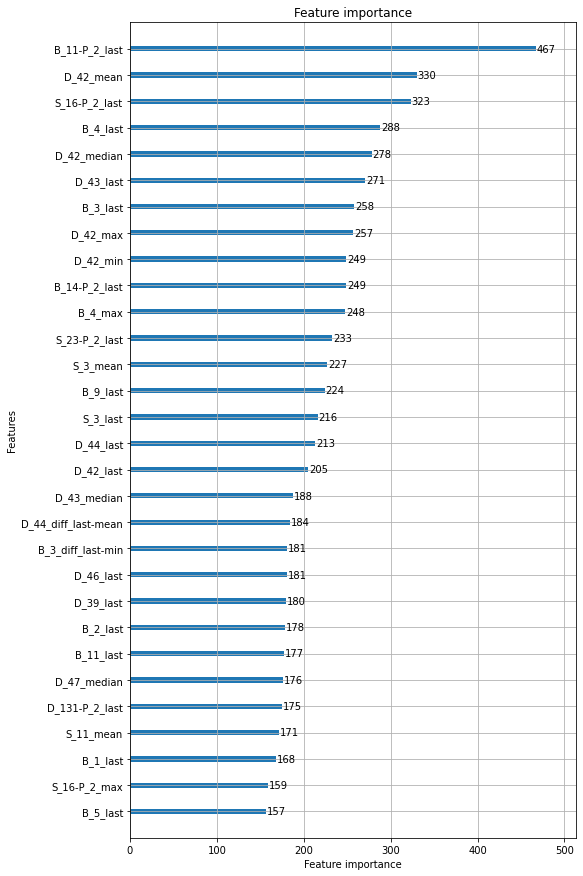

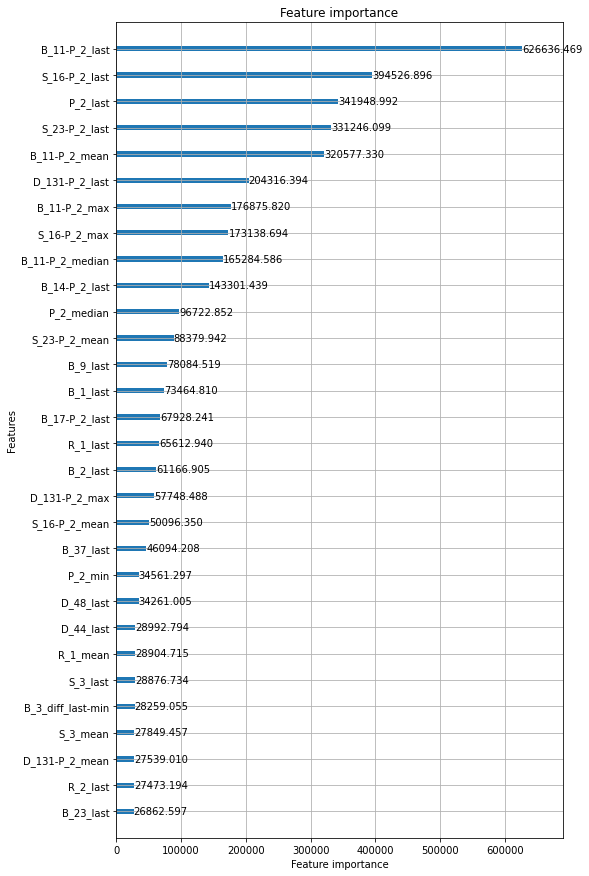

######################################## training model 2/5 ########################################
seed: 6


[50]	valid_0's amex_metric: 0.749962	valid_0's recall_at4: 0.600059	valid_0's norm_gini: 0.899865


[100]	valid_0's amex_metric: 0.761192	valid_0's recall_at4: 0.615585	valid_0's norm_gini: 0.906799


[150]	valid_0's amex_metric: 0.766929	valid_0's recall_at4: 0.623664	valid_0's norm_gini: 0.910193


[200]	valid_0's amex_metric: 0.770314	valid_0's recall_at4: 0.627577	valid_0's norm_gini: 0.913052


[250]	valid_0's amex_metric: 0.775102	valid_0's recall_at4: 0.635025	valid_0's norm_gini: 0.91518


[300]	valid_0's amex_metric: 0.77711	valid_0's recall_at4: 0.637423	valid_0's norm_gini: 0.916797


[350]	valid_0's amex_metric: 0.778716	valid_0's recall_at4: 0.639737	valid_0's norm_gini: 0.917696


[400]	valid_0's amex_metric: 0.781502	valid_0's recall_at4: 0.644198	valid_0's norm_gini: 0.918807


[450]	valid_0's amex_metric: 0.782694	valid_0's recall_at4: 0.645754	valid_0's norm_gini: 0.919634


[500]	valid_0's amex_metric: 0.784078	valid_0's recall_at4: 0.6479	valid_0's norm_gini: 0.920256


[550]	valid_0's amex_metric: 0.785866	valid_0's recall_at4: 0.650888	valid_0's norm_gini: 0.920845


[600]	valid_0's amex_metric: 0.787027	valid_0's recall_at4: 0.652781	valid_0's norm_gini: 0.921273


[650]	valid_0's amex_metric: 0.78767	valid_0's recall_at4: 0.653623	valid_0's norm_gini: 0.921717


[700]	valid_0's amex_metric: 0.788596	valid_0's recall_at4: 0.65518	valid_0's norm_gini: 0.922012


[750]	valid_0's amex_metric: 0.788902	valid_0's recall_at4: 0.655474	valid_0's norm_gini: 0.922329


[800]	valid_0's amex_metric: 0.789615	valid_0's recall_at4: 0.656652	valid_0's norm_gini: 0.922578


[850]	valid_0's amex_metric: 0.789751	valid_0's recall_at4: 0.656736	valid_0's norm_gini: 0.922766


[900]	valid_0's amex_metric: 0.790637	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.922981


[950]	valid_0's amex_metric: 0.791235	valid_0's recall_at4: 0.659261	valid_0's norm_gini: 0.923208


[1000]	valid_0's amex_metric: 0.7917	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.923382


[1050]	valid_0's amex_metric: 0.792021	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.923561


[1100]	valid_0's amex_metric: 0.792604	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.923718


[1150]	valid_0's amex_metric: 0.792603	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.92384


[1200]	valid_0's amex_metric: 0.792565	valid_0's recall_at4: 0.661197	valid_0's norm_gini: 0.923933


[1250]	valid_0's amex_metric: 0.793296	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.924091


[1300]	valid_0's amex_metric: 0.792983	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.924223


[1350]	valid_0's amex_metric: 0.792821	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.924319


[1400]	valid_0's amex_metric: 0.793349	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.924407


[1450]	valid_0's amex_metric: 0.793456	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.924496


[1500]	valid_0's amex_metric: 0.793936	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924572


[1550]	valid_0's amex_metric: 0.794404	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.924624


[1600]	valid_0's amex_metric: 0.794715	valid_0's recall_at4: 0.664731	valid_0's norm_gini: 0.924699


[1650]	valid_0's amex_metric: 0.794918	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.924768


[1700]	valid_0's amex_metric: 0.794888	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924792


[1750]	valid_0's amex_metric: 0.79502	valid_0's recall_at4: 0.665194	valid_0's norm_gini: 0.924846


[1800]	valid_0's amex_metric: 0.795369	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924912


[1850]	valid_0's amex_metric: 0.794665	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.924977


[1900]	valid_0's amex_metric: 0.794533	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.925008


[1950]	valid_0's amex_metric: 0.794846	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.925045


[2000]	valid_0's amex_metric: 0.794786	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.925094


[2050]	valid_0's amex_metric: 0.794529	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.925127


[2100]	valid_0's amex_metric: 0.795134	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.925159


[2150]	valid_0's amex_metric: 0.794894	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.925183


[2200]	valid_0's amex_metric: 0.79648	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.925199


[2250]	valid_0's amex_metric: 0.795522	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.92522


[2300]	valid_0's amex_metric: 0.795438	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.925219


[2350]	valid_0's amex_metric: 0.79533	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.925256


[2400]	valid_0's amex_metric: 0.795849	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.925241


[2450]	valid_0's amex_metric: 0.795704	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.925246


[2500]	valid_0's amex_metric: 0.795669	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.92526


[2550]	valid_0's amex_metric: 0.795428	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.925283


[2600]	valid_0's amex_metric: 0.795411	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.925291


[2650]	valid_0's amex_metric: 0.795718	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.925317


[2700]	valid_0's amex_metric: 0.79587	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.925327


[2750]	valid_0's amex_metric: 0.795679	valid_0's recall_at4: 0.665993	valid_0's norm_gini: 0.925364


[2800]	valid_0's amex_metric: 0.795889	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.925363


[2850]	valid_0's amex_metric: 0.795729	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.92538


[2900]	valid_0's amex_metric: 0.796027	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.925387


[2950]	valid_0's amex_metric: 0.795739	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.925401


[3000]	valid_0's amex_metric: 0.796275	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.92542


[3050]	valid_0's amex_metric: 0.796533	valid_0's recall_at4: 0.667634	valid_0's norm_gini: 0.925431


[3100]	valid_0's amex_metric: 0.796467	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.925426


[3150]	valid_0's amex_metric: 0.796324	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.925435


[3200]	valid_0's amex_metric: 0.796671	valid_0's recall_at4: 0.667887	valid_0's norm_gini: 0.925456


[3250]	valid_0's amex_metric: 0.796035	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.925487


[3300]	valid_0's amex_metric: 0.796529	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.925507


[3350]	valid_0's amex_metric: 0.795816	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.925513


[3400]	valid_0's amex_metric: 0.795815	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.925511


[3450]	valid_0's amex_metric: 0.795818	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.925516


[3500]	valid_0's amex_metric: 0.796242	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.925523


[3550]	valid_0's amex_metric: 0.796418	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.925537


[3600]	valid_0's amex_metric: 0.796064	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.925546


[3650]	valid_0's amex_metric: 0.796242	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.925564


[3700]	valid_0's amex_metric: 0.796371	valid_0's recall_at4: 0.667172	valid_0's norm_gini: 0.925571


[3750]	valid_0's amex_metric: 0.796587	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.925583


[3800]	valid_0's amex_metric: 0.796535	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.925562


[3850]	valid_0's amex_metric: 0.796812	valid_0's recall_at4: 0.668055	valid_0's norm_gini: 0.925569


[3900]	valid_0's amex_metric: 0.796349	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.925569


[3950]	valid_0's amex_metric: 0.796541	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.925573


[4000]	valid_0's amex_metric: 0.796338	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.925589


[4050]	valid_0's amex_metric: 0.796232	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.925586


[4100]	valid_0's amex_metric: 0.796534	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.925601


[4150]	valid_0's amex_metric: 0.796583	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.925616


[4200]	valid_0's amex_metric: 0.796638	valid_0's recall_at4: 0.667634	valid_0's norm_gini: 0.925641


[4250]	valid_0's amex_metric: 0.796581	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.925655


[4300]	valid_0's amex_metric: 0.796715	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.925669


[4350]	valid_0's amex_metric: 0.796588	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.925668


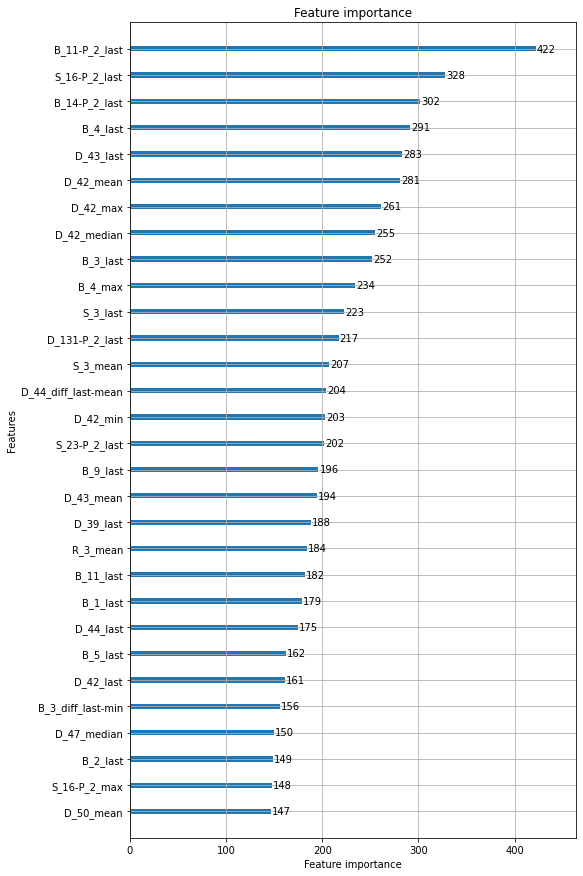

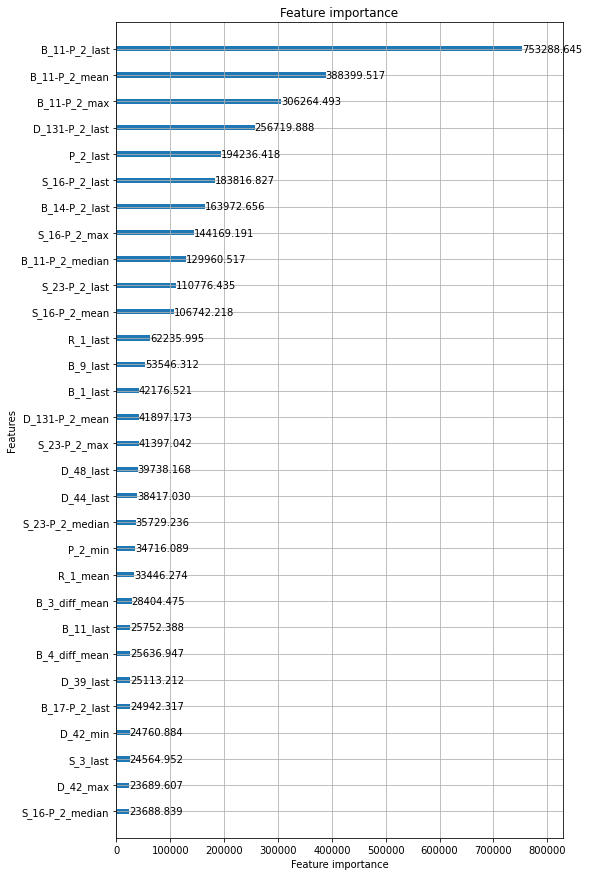

######################################## training model 3/5 ########################################
seed: 7


[50]	valid_0's amex_metric: 0.745777	valid_0's recall_at4: 0.593579	valid_0's norm_gini: 0.897976


[100]	valid_0's amex_metric: 0.75787	valid_0's recall_at4: 0.611083	valid_0's norm_gini: 0.904657


[150]	valid_0's amex_metric: 0.762393	valid_0's recall_at4: 0.616805	valid_0's norm_gini: 0.907981


[200]	valid_0's amex_metric: 0.76607	valid_0's recall_at4: 0.621897	valid_0's norm_gini: 0.910243


[250]	valid_0's amex_metric: 0.769541	valid_0's recall_at4: 0.626609	valid_0's norm_gini: 0.912473


[300]	valid_0's amex_metric: 0.774779	valid_0's recall_at4: 0.634478	valid_0's norm_gini: 0.915081


[350]	valid_0's amex_metric: 0.777777	valid_0's recall_at4: 0.638812	valid_0's norm_gini: 0.916742


[400]	valid_0's amex_metric: 0.780227	valid_0's recall_at4: 0.642725	valid_0's norm_gini: 0.917729


[450]	valid_0's amex_metric: 0.781966	valid_0's recall_at4: 0.645334	valid_0's norm_gini: 0.918599


[500]	valid_0's amex_metric: 0.783541	valid_0's recall_at4: 0.647648	valid_0's norm_gini: 0.919433


[550]	valid_0's amex_metric: 0.784831	valid_0's recall_at4: 0.649499	valid_0's norm_gini: 0.920163


[600]	valid_0's amex_metric: 0.78583	valid_0's recall_at4: 0.651056	valid_0's norm_gini: 0.920604


[650]	valid_0's amex_metric: 0.787014	valid_0's recall_at4: 0.652992	valid_0's norm_gini: 0.921035


[700]	valid_0's amex_metric: 0.787346	valid_0's recall_at4: 0.653244	valid_0's norm_gini: 0.921447


[750]	valid_0's amex_metric: 0.78812	valid_0's recall_at4: 0.654506	valid_0's norm_gini: 0.921733


[800]	valid_0's amex_metric: 0.788553	valid_0's recall_at4: 0.655096	valid_0's norm_gini: 0.92201


[850]	valid_0's amex_metric: 0.78958	valid_0's recall_at4: 0.656863	valid_0's norm_gini: 0.922297


[900]	valid_0's amex_metric: 0.789892	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.922458


[950]	valid_0's amex_metric: 0.790033	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.922613


[1000]	valid_0's amex_metric: 0.790424	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.922849


[1050]	valid_0's amex_metric: 0.790469	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.923023


[1100]	valid_0's amex_metric: 0.791213	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.923249


[1150]	valid_0's amex_metric: 0.791271	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.923407


[1200]	valid_0's amex_metric: 0.79131	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.923528


[1250]	valid_0's amex_metric: 0.792025	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.923654


[1300]	valid_0's amex_metric: 0.792894	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.923791


[1350]	valid_0's amex_metric: 0.792688	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.923926


[1400]	valid_0's amex_metric: 0.792486	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.924027


[1450]	valid_0's amex_metric: 0.792693	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.924104


[1500]	valid_0's amex_metric: 0.79309	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.924183


[1550]	valid_0's amex_metric: 0.793174	valid_0's recall_at4: 0.66208	valid_0's norm_gini: 0.924267


[1600]	valid_0's amex_metric: 0.793211	valid_0's recall_at4: 0.66208	valid_0's norm_gini: 0.924341


[1650]	valid_0's amex_metric: 0.79325	valid_0's recall_at4: 0.66208	valid_0's norm_gini: 0.924419


[1700]	valid_0's amex_metric: 0.793419	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.924464


[1750]	valid_0's amex_metric: 0.793799	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924508


[1800]	valid_0's amex_metric: 0.793496	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924534


[1850]	valid_0's amex_metric: 0.793918	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.924578


[1900]	valid_0's amex_metric: 0.793922	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.924628


[1950]	valid_0's amex_metric: 0.79394	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.924664


[2000]	valid_0's amex_metric: 0.793887	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924683


[2050]	valid_0's amex_metric: 0.794598	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.924718


[2100]	valid_0's amex_metric: 0.79379	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.924742


[2150]	valid_0's amex_metric: 0.793973	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.924772


[2200]	valid_0's amex_metric: 0.793869	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.924817


[2250]	valid_0's amex_metric: 0.794418	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.924862


[2300]	valid_0's amex_metric: 0.794004	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924917


[2350]	valid_0's amex_metric: 0.794044	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.924956


[2400]	valid_0's amex_metric: 0.794563	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924983


[2450]	valid_0's amex_metric: 0.794655	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.924999


[2500]	valid_0's amex_metric: 0.7946	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.925016


[2550]	valid_0's amex_metric: 0.794822	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.925038


[2600]	valid_0's amex_metric: 0.794595	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.925047


[2650]	valid_0's amex_metric: 0.794979	valid_0's recall_at4: 0.664899	valid_0's norm_gini: 0.925059


[2700]	valid_0's amex_metric: 0.794736	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.925077


[2750]	valid_0's amex_metric: 0.794782	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.925085


[2800]	valid_0's amex_metric: 0.795056	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.925087


[2850]	valid_0's amex_metric: 0.795034	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.925085


[2900]	valid_0's amex_metric: 0.794765	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.925094


[2950]	valid_0's amex_metric: 0.794761	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.925127


[3000]	valid_0's amex_metric: 0.794416	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.925153


[3050]	valid_0's amex_metric: 0.794426	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.925131


[3100]	valid_0's amex_metric: 0.794344	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.925136


[3150]	valid_0's amex_metric: 0.794251	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.925118


[3200]	valid_0's amex_metric: 0.794212	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925124


[3250]	valid_0's amex_metric: 0.794636	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.92513


[3300]	valid_0's amex_metric: 0.794398	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.925158


[3350]	valid_0's amex_metric: 0.794193	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.92517


[3400]	valid_0's amex_metric: 0.794262	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.925182


[3450]	valid_0's amex_metric: 0.794391	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.925187


[3500]	valid_0's amex_metric: 0.794556	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.92518


[3550]	valid_0's amex_metric: 0.793965	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.925176


[3600]	valid_0's amex_metric: 0.79417	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.925208


[3650]	valid_0's amex_metric: 0.794105	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.925203


[3700]	valid_0's amex_metric: 0.794113	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.925221


[3750]	valid_0's amex_metric: 0.793942	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.925215


[3800]	valid_0's amex_metric: 0.794237	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.925215


[3850]	valid_0's amex_metric: 0.794489	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.925215


[3900]	valid_0's amex_metric: 0.794236	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.925214


[3950]	valid_0's amex_metric: 0.794375	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.925198


[4000]	valid_0's amex_metric: 0.794328	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.925187


[4050]	valid_0's amex_metric: 0.794544	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.925198


[4100]	valid_0's amex_metric: 0.794484	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.925206


[4150]	valid_0's amex_metric: 0.794418	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.925199


[4200]	valid_0's amex_metric: 0.794689	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.925194


[4250]	valid_0's amex_metric: 0.79487	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.925218


[4300]	valid_0's amex_metric: 0.794933	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.925218


[4350]	valid_0's amex_metric: 0.79549	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.925197


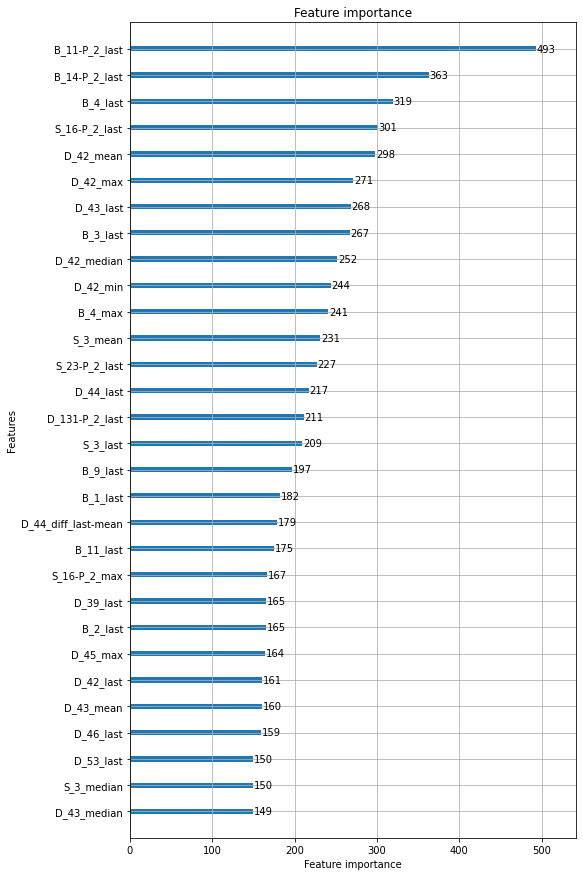

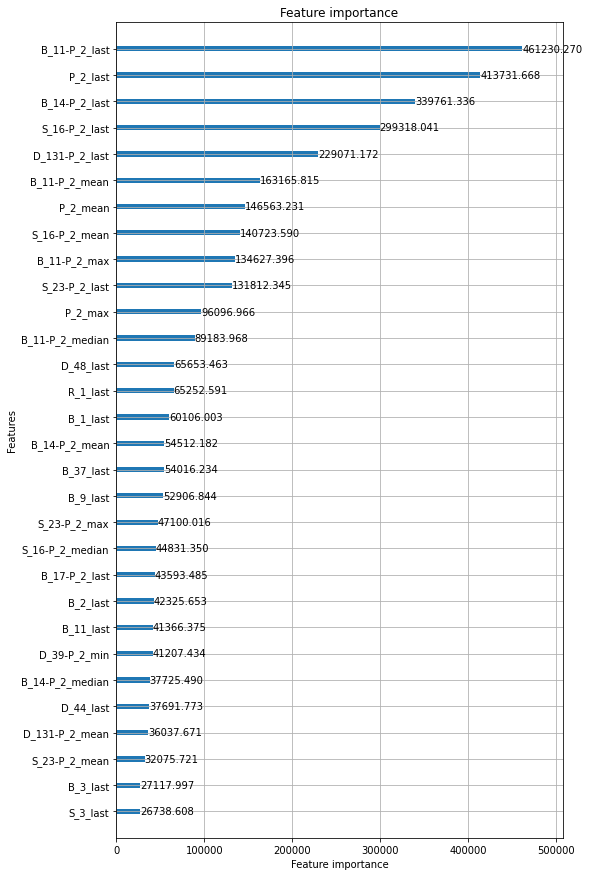

######################################## training model 4/5 ########################################
seed: 8


[50]	valid_0's amex_metric: 0.753459	valid_0's recall_at4: 0.605891	valid_0's norm_gini: 0.901028


[100]	valid_0's amex_metric: 0.764271	valid_0's recall_at4: 0.621586	valid_0's norm_gini: 0.906955


[150]	valid_0's amex_metric: 0.769433	valid_0's recall_at4: 0.627646	valid_0's norm_gini: 0.911221


[200]	valid_0's amex_metric: 0.775036	valid_0's recall_at4: 0.636735	valid_0's norm_gini: 0.913337


[250]	valid_0's amex_metric: 0.778305	valid_0's recall_at4: 0.641321	valid_0's norm_gini: 0.915288


[300]	valid_0's amex_metric: 0.781542	valid_0's recall_at4: 0.646118	valid_0's norm_gini: 0.916965


[350]	valid_0's amex_metric: 0.784663	valid_0's recall_at4: 0.651252	valid_0's norm_gini: 0.918075


[400]	valid_0's amex_metric: 0.786245	valid_0's recall_at4: 0.653356	valid_0's norm_gini: 0.919134


[450]	valid_0's amex_metric: 0.788068	valid_0's recall_at4: 0.656175	valid_0's norm_gini: 0.919961


[500]	valid_0's amex_metric: 0.789372	valid_0's recall_at4: 0.6579	valid_0's norm_gini: 0.920844


[550]	valid_0's amex_metric: 0.791379	valid_0's recall_at4: 0.661267	valid_0's norm_gini: 0.921491


[600]	valid_0's amex_metric: 0.791316	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.921912


[650]	valid_0's amex_metric: 0.7927	valid_0's recall_at4: 0.663076	valid_0's norm_gini: 0.922324


[700]	valid_0's amex_metric: 0.793465	valid_0's recall_at4: 0.664296	valid_0's norm_gini: 0.922634


[750]	valid_0's amex_metric: 0.794195	valid_0's recall_at4: 0.665474	valid_0's norm_gini: 0.922915


[800]	valid_0's amex_metric: 0.794577	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.923133


[850]	valid_0's amex_metric: 0.794914	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.923302


[900]	valid_0's amex_metric: 0.795517	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.923498


[950]	valid_0's amex_metric: 0.795396	valid_0's recall_at4: 0.667116	valid_0's norm_gini: 0.923676


[1000]	valid_0's amex_metric: 0.795818	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.92389


[1050]	valid_0's amex_metric: 0.796269	valid_0's recall_at4: 0.668504	valid_0's norm_gini: 0.924034


[1100]	valid_0's amex_metric: 0.796726	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.924232


[1150]	valid_0's amex_metric: 0.796956	valid_0's recall_at4: 0.669514	valid_0's norm_gini: 0.924398


[1200]	valid_0's amex_metric: 0.797322	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.92454


[1250]	valid_0's amex_metric: 0.797225	valid_0's recall_at4: 0.669766	valid_0's norm_gini: 0.924684


[1300]	valid_0's amex_metric: 0.79758	valid_0's recall_at4: 0.670356	valid_0's norm_gini: 0.924804


[1350]	valid_0's amex_metric: 0.797544	valid_0's recall_at4: 0.670187	valid_0's norm_gini: 0.9249


[1400]	valid_0's amex_metric: 0.797406	valid_0's recall_at4: 0.669851	valid_0's norm_gini: 0.924961


[1450]	valid_0's amex_metric: 0.797621	valid_0's recall_at4: 0.670229	valid_0's norm_gini: 0.925013


[1500]	valid_0's amex_metric: 0.797528	valid_0's recall_at4: 0.669977	valid_0's norm_gini: 0.925078


[1550]	valid_0's amex_metric: 0.797767	valid_0's recall_at4: 0.67044	valid_0's norm_gini: 0.925094


[1600]	valid_0's amex_metric: 0.798246	valid_0's recall_at4: 0.671281	valid_0's norm_gini: 0.925211


[1650]	valid_0's amex_metric: 0.798536	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.925327


[1700]	valid_0's amex_metric: 0.798223	valid_0's recall_at4: 0.671071	valid_0's norm_gini: 0.925374


[1750]	valid_0's amex_metric: 0.798948	valid_0's recall_at4: 0.672459	valid_0's norm_gini: 0.925436


[1800]	valid_0's amex_metric: 0.799384	valid_0's recall_at4: 0.673259	valid_0's norm_gini: 0.925509


[1850]	valid_0's amex_metric: 0.799234	valid_0's recall_at4: 0.672922	valid_0's norm_gini: 0.925546


[1900]	valid_0's amex_metric: 0.798994	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.925571


[1950]	valid_0's amex_metric: 0.798936	valid_0's recall_at4: 0.672249	valid_0's norm_gini: 0.925623


[2000]	valid_0's amex_metric: 0.799259	valid_0's recall_at4: 0.672838	valid_0's norm_gini: 0.92568


[2050]	valid_0's amex_metric: 0.799397	valid_0's recall_at4: 0.673091	valid_0's norm_gini: 0.925702


[2100]	valid_0's amex_metric: 0.79955	valid_0's recall_at4: 0.673385	valid_0's norm_gini: 0.925714


[2150]	valid_0's amex_metric: 0.799569	valid_0's recall_at4: 0.673385	valid_0's norm_gini: 0.925753


[2200]	valid_0's amex_metric: 0.799867	valid_0's recall_at4: 0.673974	valid_0's norm_gini: 0.92576


[2250]	valid_0's amex_metric: 0.799612	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.925796


[2300]	valid_0's amex_metric: 0.799957	valid_0's recall_at4: 0.674101	valid_0's norm_gini: 0.925813


[2350]	valid_0's amex_metric: 0.799597	valid_0's recall_at4: 0.673343	valid_0's norm_gini: 0.925852


[2400]	valid_0's amex_metric: 0.799704	valid_0's recall_at4: 0.673554	valid_0's norm_gini: 0.925855


[2450]	valid_0's amex_metric: 0.800117	valid_0's recall_at4: 0.674353	valid_0's norm_gini: 0.925881


[2500]	valid_0's amex_metric: 0.800082	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.925895


[2550]	valid_0's amex_metric: 0.800579	valid_0's recall_at4: 0.675237	valid_0's norm_gini: 0.925922


[2600]	valid_0's amex_metric: 0.800336	valid_0's recall_at4: 0.674732	valid_0's norm_gini: 0.925941


[2650]	valid_0's amex_metric: 0.800772	valid_0's recall_at4: 0.675573	valid_0's norm_gini: 0.925971


[2700]	valid_0's amex_metric: 0.800863	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.925985


[2750]	valid_0's amex_metric: 0.801085	valid_0's recall_at4: 0.676162	valid_0's norm_gini: 0.926008


[2800]	valid_0's amex_metric: 0.800712	valid_0's recall_at4: 0.675405	valid_0's norm_gini: 0.926018


[2850]	valid_0's amex_metric: 0.801061	valid_0's recall_at4: 0.676078	valid_0's norm_gini: 0.926043


[2900]	valid_0's amex_metric: 0.801013	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.926074


[2950]	valid_0's amex_metric: 0.801388	valid_0's recall_at4: 0.676667	valid_0's norm_gini: 0.92611


[3000]	valid_0's amex_metric: 0.801655	valid_0's recall_at4: 0.677172	valid_0's norm_gini: 0.926138


[3050]	valid_0's amex_metric: 0.801749	valid_0's recall_at4: 0.677341	valid_0's norm_gini: 0.926158


[3100]	valid_0's amex_metric: 0.801594	valid_0's recall_at4: 0.677046	valid_0's norm_gini: 0.926141


[3150]	valid_0's amex_metric: 0.801049	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.926147


[3200]	valid_0's amex_metric: 0.80147	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.926146


[3250]	valid_0's amex_metric: 0.801331	valid_0's recall_at4: 0.676499	valid_0's norm_gini: 0.926162


[3300]	valid_0's amex_metric: 0.801338	valid_0's recall_at4: 0.676499	valid_0's norm_gini: 0.926177


[3350]	valid_0's amex_metric: 0.801025	valid_0's recall_at4: 0.675868	valid_0's norm_gini: 0.926181


[3400]	valid_0's amex_metric: 0.800892	valid_0's recall_at4: 0.675615	valid_0's norm_gini: 0.926169


[3450]	valid_0's amex_metric: 0.801207	valid_0's recall_at4: 0.676247	valid_0's norm_gini: 0.926168


[3500]	valid_0's amex_metric: 0.801394	valid_0's recall_at4: 0.676625	valid_0's norm_gini: 0.926162


[3550]	valid_0's amex_metric: 0.801438	valid_0's recall_at4: 0.676709	valid_0's norm_gini: 0.926166


[3600]	valid_0's amex_metric: 0.801277	valid_0's recall_at4: 0.676373	valid_0's norm_gini: 0.926182


[3650]	valid_0's amex_metric: 0.801442	valid_0's recall_at4: 0.676709	valid_0's norm_gini: 0.926175


[3700]	valid_0's amex_metric: 0.801386	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.926189


[3750]	valid_0's amex_metric: 0.801134	valid_0's recall_at4: 0.676078	valid_0's norm_gini: 0.926191


[3800]	valid_0's amex_metric: 0.800995	valid_0's recall_at4: 0.675784	valid_0's norm_gini: 0.926206


[3850]	valid_0's amex_metric: 0.801505	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.926216


[3900]	valid_0's amex_metric: 0.801165	valid_0's recall_at4: 0.67612	valid_0's norm_gini: 0.926211


[3950]	valid_0's amex_metric: 0.801021	valid_0's recall_at4: 0.675826	valid_0's norm_gini: 0.926217


[4000]	valid_0's amex_metric: 0.801228	valid_0's recall_at4: 0.676247	valid_0's norm_gini: 0.92621


[4050]	valid_0's amex_metric: 0.801361	valid_0's recall_at4: 0.676499	valid_0's norm_gini: 0.926222


[4100]	valid_0's amex_metric: 0.801241	valid_0's recall_at4: 0.676247	valid_0's norm_gini: 0.926235


[4150]	valid_0's amex_metric: 0.800981	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.926221


[4200]	valid_0's amex_metric: 0.800988	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.926234


[4250]	valid_0's amex_metric: 0.801168	valid_0's recall_at4: 0.67612	valid_0's norm_gini: 0.926216


[4300]	valid_0's amex_metric: 0.800939	valid_0's recall_at4: 0.675657	valid_0's norm_gini: 0.92622


[4350]	valid_0's amex_metric: 0.801201	valid_0's recall_at4: 0.676162	valid_0's norm_gini: 0.926239


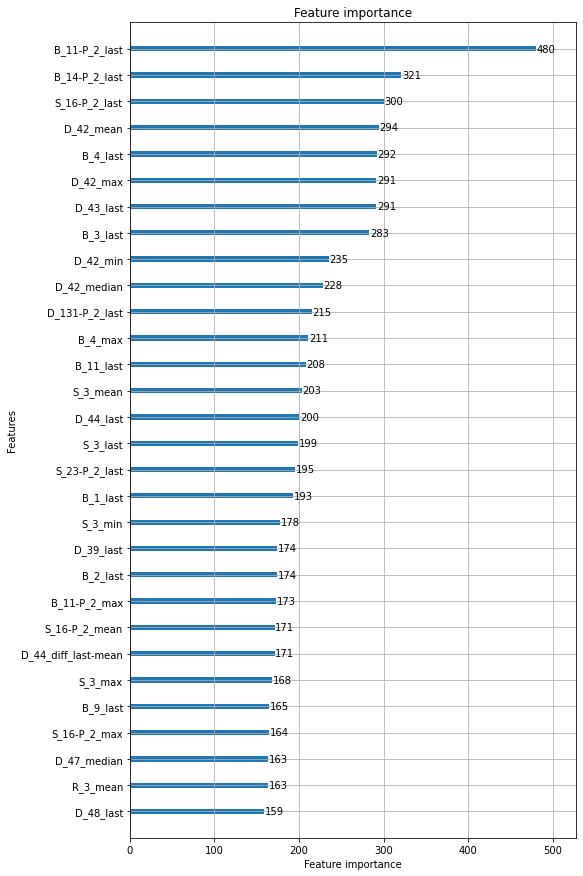

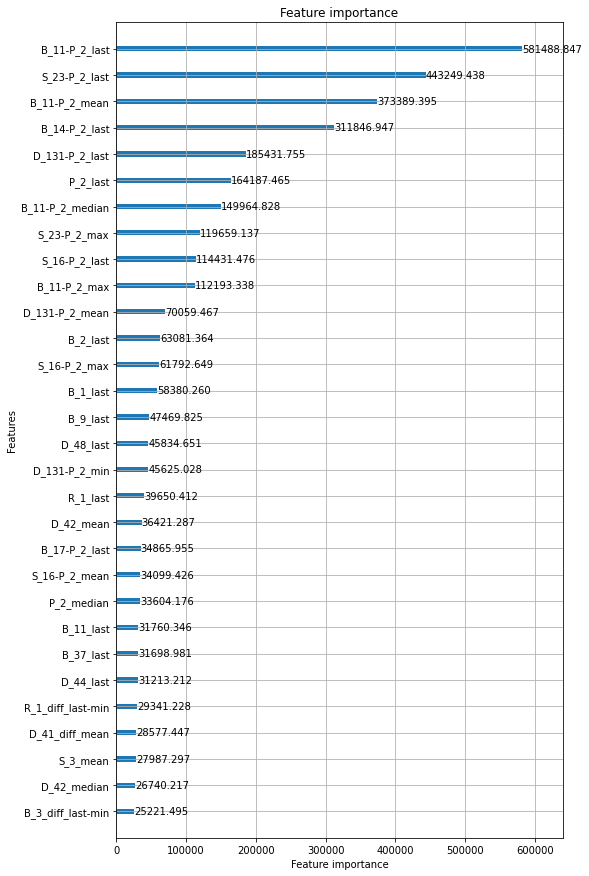

######################################## training model 5/5 ########################################
seed: 9


[50]	valid_0's amex_metric: 0.749917	valid_0's recall_at4: 0.600168	valid_0's norm_gini: 0.899665


[100]	valid_0's amex_metric: 0.761621	valid_0's recall_at4: 0.616831	valid_0's norm_gini: 0.90641


[150]	valid_0's amex_metric: 0.7684	valid_0's recall_at4: 0.627562	valid_0's norm_gini: 0.909239


[200]	valid_0's amex_metric: 0.772914	valid_0's recall_at4: 0.633116	valid_0's norm_gini: 0.912712


[250]	valid_0's amex_metric: 0.777132	valid_0's recall_at4: 0.639217	valid_0's norm_gini: 0.915047


[300]	valid_0's amex_metric: 0.781703	valid_0's recall_at4: 0.645866	valid_0's norm_gini: 0.91754


[350]	valid_0's amex_metric: 0.783408	valid_0's recall_at4: 0.648222	valid_0's norm_gini: 0.918595


[400]	valid_0's amex_metric: 0.785056	valid_0's recall_at4: 0.650705	valid_0's norm_gini: 0.919406


[450]	valid_0's amex_metric: 0.7868	valid_0's recall_at4: 0.653314	valid_0's norm_gini: 0.920286


[500]	valid_0's amex_metric: 0.788368	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.920981


[550]	valid_0's amex_metric: 0.789358	valid_0's recall_at4: 0.657185	valid_0's norm_gini: 0.921531


[600]	valid_0's amex_metric: 0.790148	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.922018


[650]	valid_0's amex_metric: 0.791171	valid_0's recall_at4: 0.660088	valid_0's norm_gini: 0.922254


[700]	valid_0's amex_metric: 0.791259	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.922513


[750]	valid_0's amex_metric: 0.792217	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.92279


[800]	valid_0's amex_metric: 0.792755	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.923024


[850]	valid_0's amex_metric: 0.793116	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.923283


[900]	valid_0's amex_metric: 0.793246	valid_0's recall_at4: 0.662866	valid_0's norm_gini: 0.923626


[950]	valid_0's amex_metric: 0.793839	valid_0's recall_at4: 0.663791	valid_0's norm_gini: 0.923886


[1000]	valid_0's amex_metric: 0.794564	valid_0's recall_at4: 0.66497	valid_0's norm_gini: 0.924159


[1050]	valid_0's amex_metric: 0.795408	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.924332


[1100]	valid_0's amex_metric: 0.795729	valid_0's recall_at4: 0.666989	valid_0's norm_gini: 0.924468


[1150]	valid_0's amex_metric: 0.795511	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.924664


[1200]	valid_0's amex_metric: 0.796096	valid_0's recall_at4: 0.667368	valid_0's norm_gini: 0.924825


[1250]	valid_0's amex_metric: 0.796322	valid_0's recall_at4: 0.667705	valid_0's norm_gini: 0.92494


[1300]	valid_0's amex_metric: 0.796684	valid_0's recall_at4: 0.668336	valid_0's norm_gini: 0.925032


[1350]	valid_0's amex_metric: 0.796455	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.925164


[1400]	valid_0's amex_metric: 0.796395	valid_0's recall_at4: 0.667494	valid_0's norm_gini: 0.925296


[1450]	valid_0's amex_metric: 0.796489	valid_0's recall_at4: 0.66762	valid_0's norm_gini: 0.925357


[1500]	valid_0's amex_metric: 0.797272	valid_0's recall_at4: 0.669093	valid_0's norm_gini: 0.92545


[1550]	valid_0's amex_metric: 0.797584	valid_0's recall_at4: 0.66964	valid_0's norm_gini: 0.925527


[1600]	valid_0's amex_metric: 0.797711	valid_0's recall_at4: 0.669851	valid_0's norm_gini: 0.925571


[1650]	valid_0's amex_metric: 0.797672	valid_0's recall_at4: 0.669724	valid_0's norm_gini: 0.925621


[1700]	valid_0's amex_metric: 0.797804	valid_0's recall_at4: 0.669935	valid_0's norm_gini: 0.925674


[1750]	valid_0's amex_metric: 0.797844	valid_0's recall_at4: 0.669977	valid_0's norm_gini: 0.925712


[1800]	valid_0's amex_metric: 0.797654	valid_0's recall_at4: 0.669556	valid_0's norm_gini: 0.925752


[1850]	valid_0's amex_metric: 0.797793	valid_0's recall_at4: 0.669809	valid_0's norm_gini: 0.925778


[1900]	valid_0's amex_metric: 0.797757	valid_0's recall_at4: 0.669682	valid_0's norm_gini: 0.925831


[1950]	valid_0's amex_metric: 0.798014	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.925925


[2000]	valid_0's amex_metric: 0.798175	valid_0's recall_at4: 0.670398	valid_0's norm_gini: 0.925952


[2050]	valid_0's amex_metric: 0.798435	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.925967


[2100]	valid_0's amex_metric: 0.798557	valid_0's recall_at4: 0.671113	valid_0's norm_gini: 0.926002


[2150]	valid_0's amex_metric: 0.798231	valid_0's recall_at4: 0.67044	valid_0's norm_gini: 0.926022


[2200]	valid_0's amex_metric: 0.798614	valid_0's recall_at4: 0.671155	valid_0's norm_gini: 0.926072


[2250]	valid_0's amex_metric: 0.798732	valid_0's recall_at4: 0.671365	valid_0's norm_gini: 0.926099


[2300]	valid_0's amex_metric: 0.798781	valid_0's recall_at4: 0.671408	valid_0's norm_gini: 0.926155


[2350]	valid_0's amex_metric: 0.798448	valid_0's recall_at4: 0.670734	valid_0's norm_gini: 0.926161


[2400]	valid_0's amex_metric: 0.799028	valid_0's recall_at4: 0.67187	valid_0's norm_gini: 0.926185


[2450]	valid_0's amex_metric: 0.799397	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.926208


[2500]	valid_0's amex_metric: 0.799139	valid_0's recall_at4: 0.672039	valid_0's norm_gini: 0.92624


[2550]	valid_0's amex_metric: 0.799341	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.926264


[2600]	valid_0's amex_metric: 0.798793	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.926263


[2650]	valid_0's amex_metric: 0.799093	valid_0's recall_at4: 0.671912	valid_0's norm_gini: 0.926274


[2700]	valid_0's amex_metric: 0.798685	valid_0's recall_at4: 0.671071	valid_0's norm_gini: 0.926299


[2750]	valid_0's amex_metric: 0.798612	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.926322


[2800]	valid_0's amex_metric: 0.799171	valid_0's recall_at4: 0.671997	valid_0's norm_gini: 0.926345


[2850]	valid_0's amex_metric: 0.798724	valid_0's recall_at4: 0.671071	valid_0's norm_gini: 0.926377


[2900]	valid_0's amex_metric: 0.798537	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.926382


[2950]	valid_0's amex_metric: 0.798814	valid_0's recall_at4: 0.671239	valid_0's norm_gini: 0.926388


[3000]	valid_0's amex_metric: 0.798693	valid_0's recall_at4: 0.670987	valid_0's norm_gini: 0.9264


[3050]	valid_0's amex_metric: 0.79891	valid_0's recall_at4: 0.671408	valid_0's norm_gini: 0.926412


[3100]	valid_0's amex_metric: 0.79937	valid_0's recall_at4: 0.672291	valid_0's norm_gini: 0.926449


[3150]	valid_0's amex_metric: 0.799344	valid_0's recall_at4: 0.672207	valid_0's norm_gini: 0.926481


[3200]	valid_0's amex_metric: 0.799662	valid_0's recall_at4: 0.672838	valid_0's norm_gini: 0.926486


[3250]	valid_0's amex_metric: 0.799842	valid_0's recall_at4: 0.673175	valid_0's norm_gini: 0.926508


[3300]	valid_0's amex_metric: 0.799734	valid_0's recall_at4: 0.672964	valid_0's norm_gini: 0.926503


[3350]	valid_0's amex_metric: 0.799974	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.926521


[3400]	valid_0's amex_metric: 0.799857	valid_0's recall_at4: 0.673175	valid_0's norm_gini: 0.926538


[3450]	valid_0's amex_metric: 0.79956	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.926535


[3500]	valid_0's amex_metric: 0.800028	valid_0's recall_at4: 0.673511	valid_0's norm_gini: 0.926545


[3550]	valid_0's amex_metric: 0.799983	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.926539


[3600]	valid_0's amex_metric: 0.799884	valid_0's recall_at4: 0.673217	valid_0's norm_gini: 0.926551


[3650]	valid_0's amex_metric: 0.799634	valid_0's recall_at4: 0.672712	valid_0's norm_gini: 0.926556


[3700]	valid_0's amex_metric: 0.79944	valid_0's recall_at4: 0.672333	valid_0's norm_gini: 0.926547


[3750]	valid_0's amex_metric: 0.799676	valid_0's recall_at4: 0.672796	valid_0's norm_gini: 0.926556


[3800]	valid_0's amex_metric: 0.799689	valid_0's recall_at4: 0.672796	valid_0's norm_gini: 0.926582


[3850]	valid_0's amex_metric: 0.799726	valid_0's recall_at4: 0.672838	valid_0's norm_gini: 0.926613


[3900]	valid_0's amex_metric: 0.799943	valid_0's recall_at4: 0.673259	valid_0's norm_gini: 0.926627


[3950]	valid_0's amex_metric: 0.799737	valid_0's recall_at4: 0.672838	valid_0's norm_gini: 0.926636


[4000]	valid_0's amex_metric: 0.799884	valid_0's recall_at4: 0.673133	valid_0's norm_gini: 0.926636


[4050]	valid_0's amex_metric: 0.799755	valid_0's recall_at4: 0.67288	valid_0's norm_gini: 0.92663


[4100]	valid_0's amex_metric: 0.799039	valid_0's recall_at4: 0.67145	valid_0's norm_gini: 0.926628


[4150]	valid_0's amex_metric: 0.799082	valid_0's recall_at4: 0.671534	valid_0's norm_gini: 0.926631


[4200]	valid_0's amex_metric: 0.799079	valid_0's recall_at4: 0.671534	valid_0's norm_gini: 0.926624


[4250]	valid_0's amex_metric: 0.798762	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.926621


[4300]	valid_0's amex_metric: 0.799283	valid_0's recall_at4: 0.671955	valid_0's norm_gini: 0.926612


[4350]	valid_0's amex_metric: 0.799151	valid_0's recall_at4: 0.671702	valid_0's norm_gini: 0.9266


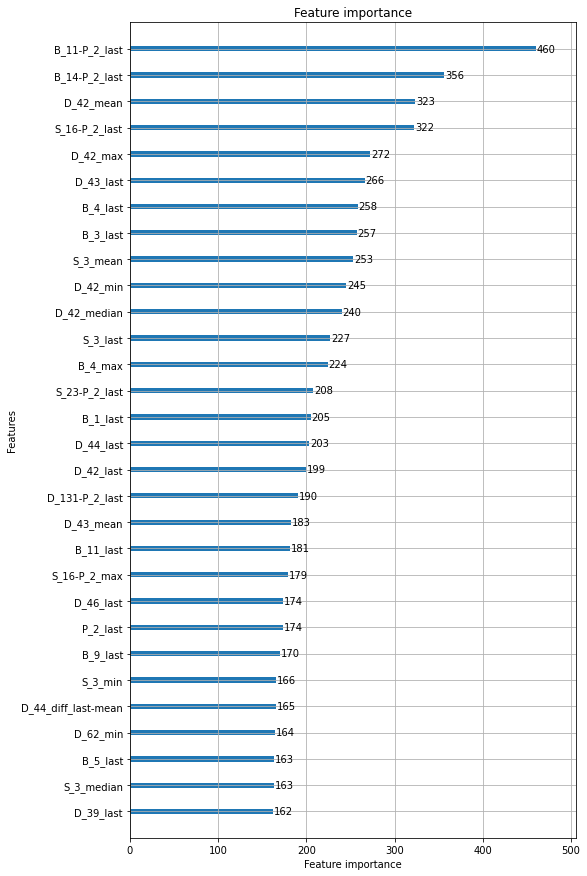

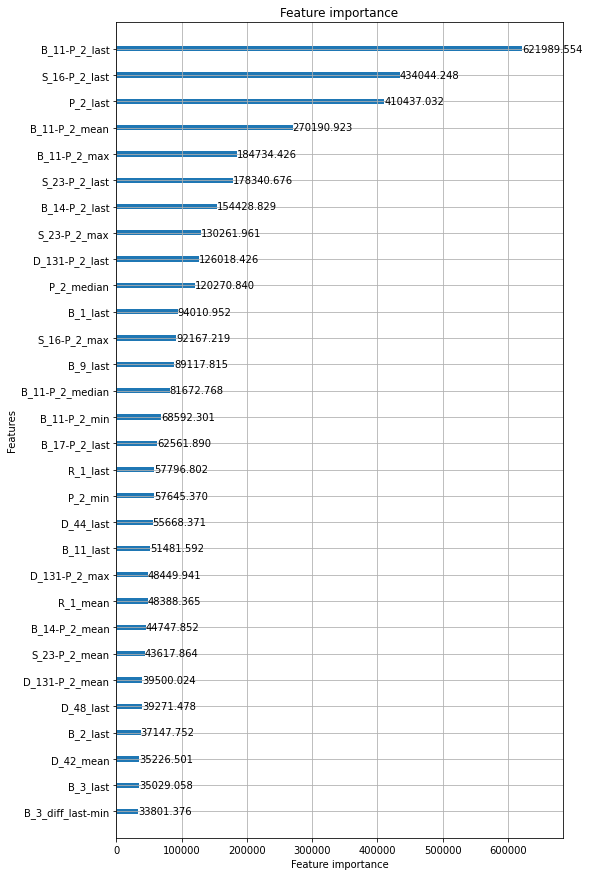

Training time: 38.94993280172348 min.
OOF recall_at4: 0.6715252297438314
OOF normalized_gini: 0.9260456386830526
OOF competition metric: 0.798785434213442


############################### repeated cross-validation step: 3/5 ################################


######################################## training model 1/5 ########################################
seed: 10


[50]	valid_0's amex_metric: 0.750499	valid_0's recall_at4: 0.601826	valid_0's norm_gini: 0.899173


[100]	valid_0's amex_metric: 0.761324	valid_0's recall_at4: 0.616048	valid_0's norm_gini: 0.906599


[150]	valid_0's amex_metric: 0.765686	valid_0's recall_at4: 0.622023	valid_0's norm_gini: 0.909348


[200]	valid_0's amex_metric: 0.768978	valid_0's recall_at4: 0.626609	valid_0's norm_gini: 0.911346


[250]	valid_0's amex_metric: 0.77097	valid_0's recall_at4: 0.62905	valid_0's norm_gini: 0.912889


[300]	valid_0's amex_metric: 0.774191	valid_0's recall_at4: 0.633805	valid_0's norm_gini: 0.914578


[350]	valid_0's amex_metric: 0.776915	valid_0's recall_at4: 0.63776	valid_0's norm_gini: 0.91607


[400]	valid_0's amex_metric: 0.780399	valid_0's recall_at4: 0.643104	valid_0's norm_gini: 0.917695


[450]	valid_0's amex_metric: 0.782903	valid_0's recall_at4: 0.647311	valid_0's norm_gini: 0.918495


[500]	valid_0's amex_metric: 0.784438	valid_0's recall_at4: 0.64971	valid_0's norm_gini: 0.919166


[550]	valid_0's amex_metric: 0.785881	valid_0's recall_at4: 0.651856	valid_0's norm_gini: 0.919906


[600]	valid_0's amex_metric: 0.787069	valid_0's recall_at4: 0.653875	valid_0's norm_gini: 0.920263


[650]	valid_0's amex_metric: 0.788628	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.920729


[700]	valid_0's amex_metric: 0.789653	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.921138


[750]	valid_0's amex_metric: 0.790206	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.921404


[800]	valid_0's amex_metric: 0.78969	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.921676


[850]	valid_0's amex_metric: 0.790332	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.921908


[900]	valid_0's amex_metric: 0.791261	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.922208


[950]	valid_0's amex_metric: 0.791766	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.92242


[1000]	valid_0's amex_metric: 0.792136	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.92257


[1050]	valid_0's amex_metric: 0.792525	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.922718


[1100]	valid_0's amex_metric: 0.792282	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.92282


[1150]	valid_0's amex_metric: 0.793121	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.922984


[1200]	valid_0's amex_metric: 0.793684	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.923059


[1250]	valid_0's amex_metric: 0.793517	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.923186


[1300]	valid_0's amex_metric: 0.792933	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.923281


[1350]	valid_0's amex_metric: 0.793396	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.923365


[1400]	valid_0's amex_metric: 0.793331	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.923446


[1450]	valid_0's amex_metric: 0.792909	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.923528


[1500]	valid_0's amex_metric: 0.792619	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.92362


[1550]	valid_0's amex_metric: 0.793098	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.923694


[1600]	valid_0's amex_metric: 0.793407	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.923766


[1650]	valid_0's amex_metric: 0.793709	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.923823


[1700]	valid_0's amex_metric: 0.793798	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.923876


[1750]	valid_0's amex_metric: 0.793687	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.923906


[1800]	valid_0's amex_metric: 0.79354	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.923947


[1850]	valid_0's amex_metric: 0.793761	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.923969


[1900]	valid_0's amex_metric: 0.794013	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.92401


[1950]	valid_0's amex_metric: 0.794451	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.924045


[2000]	valid_0's amex_metric: 0.794355	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.924063


[2050]	valid_0's amex_metric: 0.794576	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.924085


[2100]	valid_0's amex_metric: 0.794607	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.924105


[2150]	valid_0's amex_metric: 0.794619	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.924129


[2200]	valid_0's amex_metric: 0.794699	valid_0's recall_at4: 0.665236	valid_0's norm_gini: 0.924163


[2250]	valid_0's amex_metric: 0.794926	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.924195


[2300]	valid_0's amex_metric: 0.795022	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924218


[2350]	valid_0's amex_metric: 0.795053	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.924238


[2400]	valid_0's amex_metric: 0.794958	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.924259


[2450]	valid_0's amex_metric: 0.795355	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.924253


[2500]	valid_0's amex_metric: 0.794778	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.924279


[2550]	valid_0's amex_metric: 0.794886	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.924283


[2600]	valid_0's amex_metric: 0.795212	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.924304


[2650]	valid_0's amex_metric: 0.795733	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.924336


[2700]	valid_0's amex_metric: 0.796089	valid_0's recall_at4: 0.667803	valid_0's norm_gini: 0.924375


[2750]	valid_0's amex_metric: 0.79627	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.9244


[2800]	valid_0's amex_metric: 0.79609	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.924419


[2850]	valid_0's amex_metric: 0.796301	valid_0's recall_at4: 0.668181	valid_0's norm_gini: 0.92442


[2900]	valid_0's amex_metric: 0.796395	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.92444


[2950]	valid_0's amex_metric: 0.79649	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.924461


[3000]	valid_0's amex_metric: 0.796485	valid_0's recall_at4: 0.668476	valid_0's norm_gini: 0.924493


[3050]	valid_0's amex_metric: 0.796658	valid_0's recall_at4: 0.668813	valid_0's norm_gini: 0.924504


[3100]	valid_0's amex_metric: 0.796626	valid_0's recall_at4: 0.668728	valid_0's norm_gini: 0.924523


[3150]	valid_0's amex_metric: 0.796244	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.924518


[3200]	valid_0's amex_metric: 0.796584	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.924524


[3250]	valid_0's amex_metric: 0.796312	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.924526


[3300]	valid_0's amex_metric: 0.796028	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924547


[3350]	valid_0's amex_metric: 0.796419	valid_0's recall_at4: 0.668308	valid_0's norm_gini: 0.92453


[3400]	valid_0's amex_metric: 0.796862	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.924532


[3450]	valid_0's amex_metric: 0.796709	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.924521


[3500]	valid_0's amex_metric: 0.796434	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924517


[3550]	valid_0's amex_metric: 0.796606	valid_0's recall_at4: 0.668686	valid_0's norm_gini: 0.924525


[3600]	valid_0's amex_metric: 0.796883	valid_0's recall_at4: 0.669233	valid_0's norm_gini: 0.924532


[3650]	valid_0's amex_metric: 0.796624	valid_0's recall_at4: 0.668686	valid_0's norm_gini: 0.924563


[3700]	valid_0's amex_metric: 0.797152	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.924566


[3750]	valid_0's amex_metric: 0.796991	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.92458


[3800]	valid_0's amex_metric: 0.796405	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.924587


[3850]	valid_0's amex_metric: 0.796173	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.924585


[3900]	valid_0's amex_metric: 0.796403	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.924582


[3950]	valid_0's amex_metric: 0.796426	valid_0's recall_at4: 0.668266	valid_0's norm_gini: 0.924586


[4000]	valid_0's amex_metric: 0.796173	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.924585


[4050]	valid_0's amex_metric: 0.796418	valid_0's recall_at4: 0.668266	valid_0's norm_gini: 0.92457


[4100]	valid_0's amex_metric: 0.796653	valid_0's recall_at4: 0.668728	valid_0's norm_gini: 0.924578


[4150]	valid_0's amex_metric: 0.796376	valid_0's recall_at4: 0.668181	valid_0's norm_gini: 0.92457


[4200]	valid_0's amex_metric: 0.796548	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.924579


[4250]	valid_0's amex_metric: 0.7965	valid_0's recall_at4: 0.668434	valid_0's norm_gini: 0.924567


[4300]	valid_0's amex_metric: 0.795718	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.924558


[4350]	valid_0's amex_metric: 0.796017	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.924568


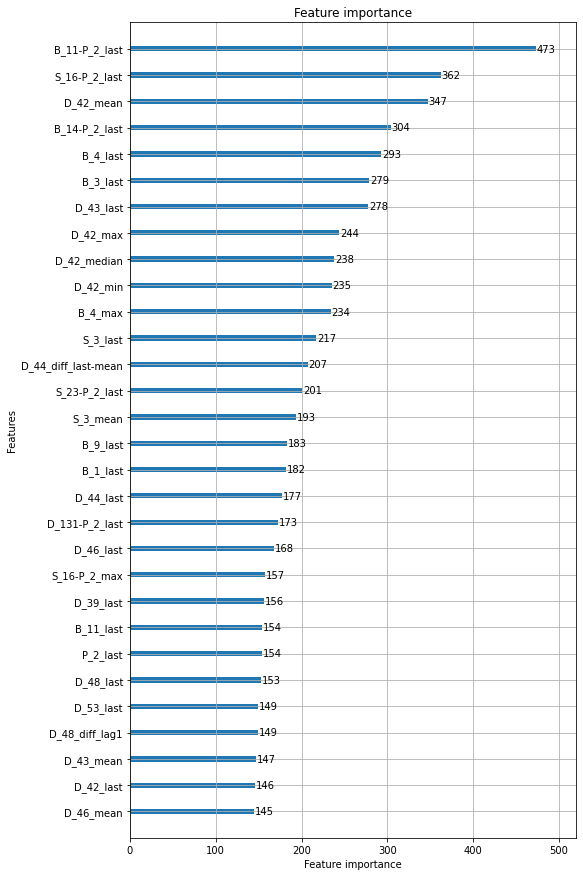

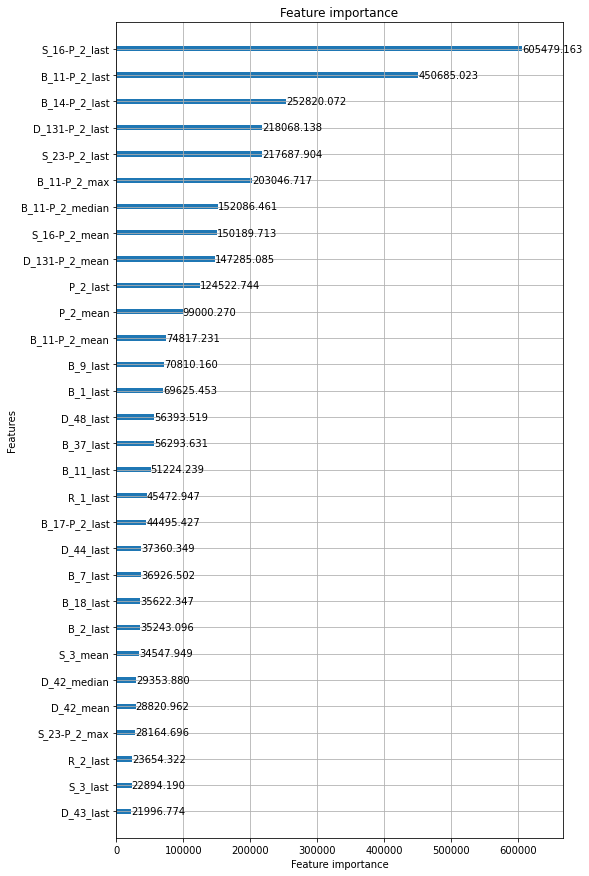

######################################## training model 2/5 ########################################
seed: 11


[50]	valid_0's amex_metric: 0.749005	valid_0's recall_at4: 0.59825	valid_0's norm_gini: 0.89976


[100]	valid_0's amex_metric: 0.760482	valid_0's recall_at4: 0.613734	valid_0's norm_gini: 0.907231


[150]	valid_0's amex_metric: 0.767198	valid_0's recall_at4: 0.623033	valid_0's norm_gini: 0.911363


[200]	valid_0's amex_metric: 0.771791	valid_0's recall_at4: 0.629639	valid_0's norm_gini: 0.913944


[250]	valid_0's amex_metric: 0.773779	valid_0's recall_at4: 0.631953	valid_0's norm_gini: 0.915605


[300]	valid_0's amex_metric: 0.7765	valid_0's recall_at4: 0.635908	valid_0's norm_gini: 0.917091


[350]	valid_0's amex_metric: 0.780016	valid_0's recall_at4: 0.64121	valid_0's norm_gini: 0.918821


[400]	valid_0's amex_metric: 0.781031	valid_0's recall_at4: 0.64243	valid_0's norm_gini: 0.919632


[450]	valid_0's amex_metric: 0.782077	valid_0's recall_at4: 0.643861	valid_0's norm_gini: 0.920292


[500]	valid_0's amex_metric: 0.783732	valid_0's recall_at4: 0.64668	valid_0's norm_gini: 0.920784


[550]	valid_0's amex_metric: 0.784785	valid_0's recall_at4: 0.648279	valid_0's norm_gini: 0.921291


[600]	valid_0's amex_metric: 0.786829	valid_0's recall_at4: 0.651856	valid_0's norm_gini: 0.921802


[650]	valid_0's amex_metric: 0.787659	valid_0's recall_at4: 0.653034	valid_0's norm_gini: 0.922284


[700]	valid_0's amex_metric: 0.788086	valid_0's recall_at4: 0.653581	valid_0's norm_gini: 0.922591


[750]	valid_0's amex_metric: 0.788702	valid_0's recall_at4: 0.654549	valid_0's norm_gini: 0.922855


[800]	valid_0's amex_metric: 0.789013	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.923141


[850]	valid_0's amex_metric: 0.789238	valid_0's recall_at4: 0.655138	valid_0's norm_gini: 0.923339


[900]	valid_0's amex_metric: 0.789545	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.923489


[950]	valid_0's amex_metric: 0.790166	valid_0's recall_at4: 0.65661	valid_0's norm_gini: 0.923722


[1000]	valid_0's amex_metric: 0.790485	valid_0's recall_at4: 0.657031	valid_0's norm_gini: 0.923939


[1050]	valid_0's amex_metric: 0.790925	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.924104


[1100]	valid_0's amex_metric: 0.791133	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.924224


[1150]	valid_0's amex_metric: 0.791665	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.924322


[1200]	valid_0's amex_metric: 0.792115	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.924422


[1250]	valid_0's amex_metric: 0.792474	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.924508


[1300]	valid_0's amex_metric: 0.792495	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.924635


[1350]	valid_0's amex_metric: 0.79296	valid_0's recall_at4: 0.661197	valid_0's norm_gini: 0.924724


[1400]	valid_0's amex_metric: 0.792803	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.924787


[1450]	valid_0's amex_metric: 0.7931	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.924877


[1500]	valid_0's amex_metric: 0.792836	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.924938


[1550]	valid_0's amex_metric: 0.792679	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.925003


[1600]	valid_0's amex_metric: 0.793118	valid_0's recall_at4: 0.661155	valid_0's norm_gini: 0.925081


[1650]	valid_0's amex_metric: 0.792587	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.925156


[1700]	valid_0's amex_metric: 0.792852	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.925223


[1750]	valid_0's amex_metric: 0.793319	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.925272


[1800]	valid_0's amex_metric: 0.793038	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.925301


[1850]	valid_0's amex_metric: 0.79378	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.925354


[1900]	valid_0's amex_metric: 0.793854	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.925375


[1950]	valid_0's amex_metric: 0.793972	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.925443


[2000]	valid_0's amex_metric: 0.793966	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.925473


[2050]	valid_0's amex_metric: 0.79398	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.925501


[2100]	valid_0's amex_metric: 0.794077	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.925527


[2150]	valid_0's amex_metric: 0.79403	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.925517


[2200]	valid_0's amex_metric: 0.794148	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.925542


[2250]	valid_0's amex_metric: 0.794335	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.92558


[2300]	valid_0's amex_metric: 0.794393	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.925612


[2350]	valid_0's amex_metric: 0.79419	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.925668


[2400]	valid_0's amex_metric: 0.794346	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.925686


[2450]	valid_0's amex_metric: 0.794498	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925695


[2500]	valid_0's amex_metric: 0.794518	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925735


[2550]	valid_0's amex_metric: 0.795212	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.925735


[2600]	valid_0's amex_metric: 0.79514	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.925759


[2650]	valid_0's amex_metric: 0.795184	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.925763


[2700]	valid_0's amex_metric: 0.795372	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.92576


[2750]	valid_0's amex_metric: 0.795088	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.925781


[2800]	valid_0's amex_metric: 0.794947	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.925794


[2850]	valid_0's amex_metric: 0.795289	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.925805


[2900]	valid_0's amex_metric: 0.795064	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.925818


[2950]	valid_0's amex_metric: 0.794518	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.92582


[3000]	valid_0's amex_metric: 0.794813	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.92582


[3050]	valid_0's amex_metric: 0.795003	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.925822


[3100]	valid_0's amex_metric: 0.794671	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.925831


[3150]	valid_0's amex_metric: 0.794516	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.925815


[3200]	valid_0's amex_metric: 0.794569	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925837


[3250]	valid_0's amex_metric: 0.794223	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.925861


[3300]	valid_0's amex_metric: 0.794465	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.925883


[3350]	valid_0's amex_metric: 0.793913	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.925914


[3400]	valid_0's amex_metric: 0.794618	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925936


[3450]	valid_0's amex_metric: 0.794387	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.925935


[3500]	valid_0's amex_metric: 0.794048	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.925931


[3550]	valid_0's amex_metric: 0.794621	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925942


[3600]	valid_0's amex_metric: 0.794914	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.925939


[3650]	valid_0's amex_metric: 0.794959	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.925944


[3700]	valid_0's amex_metric: 0.795222	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.925965


[3750]	valid_0's amex_metric: 0.79474	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.92597


[3800]	valid_0's amex_metric: 0.794431	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.925982


[3850]	valid_0's amex_metric: 0.794467	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.925969


[3900]	valid_0's amex_metric: 0.794202	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.925987


[3950]	valid_0's amex_metric: 0.794362	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.92597


[4000]	valid_0's amex_metric: 0.794429	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.925978


[4050]	valid_0's amex_metric: 0.794349	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.925986


[4100]	valid_0's amex_metric: 0.794247	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.925993


[4150]	valid_0's amex_metric: 0.794221	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.925983


[4200]	valid_0's amex_metric: 0.795021	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.925984


[4250]	valid_0's amex_metric: 0.795031	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.926003


[4300]	valid_0's amex_metric: 0.794867	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.926012


[4350]	valid_0's amex_metric: 0.794973	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.926013


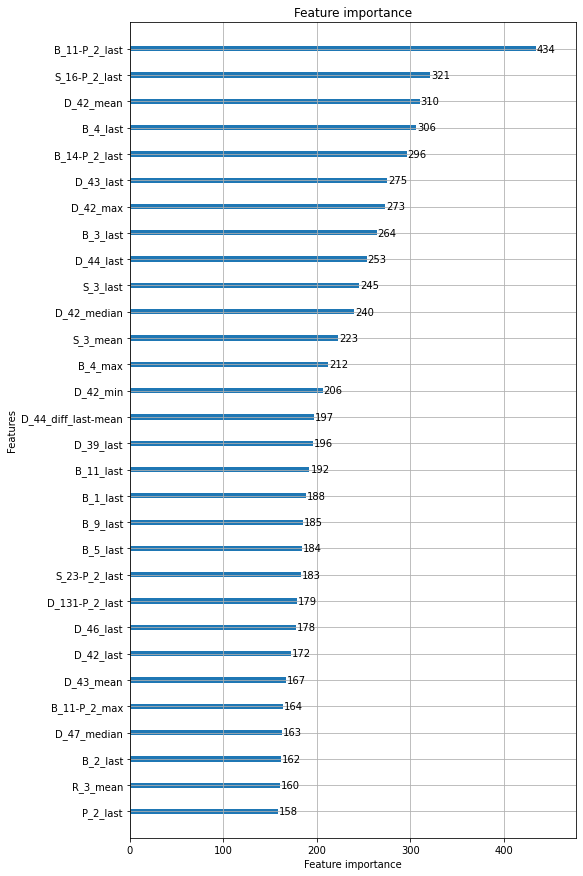

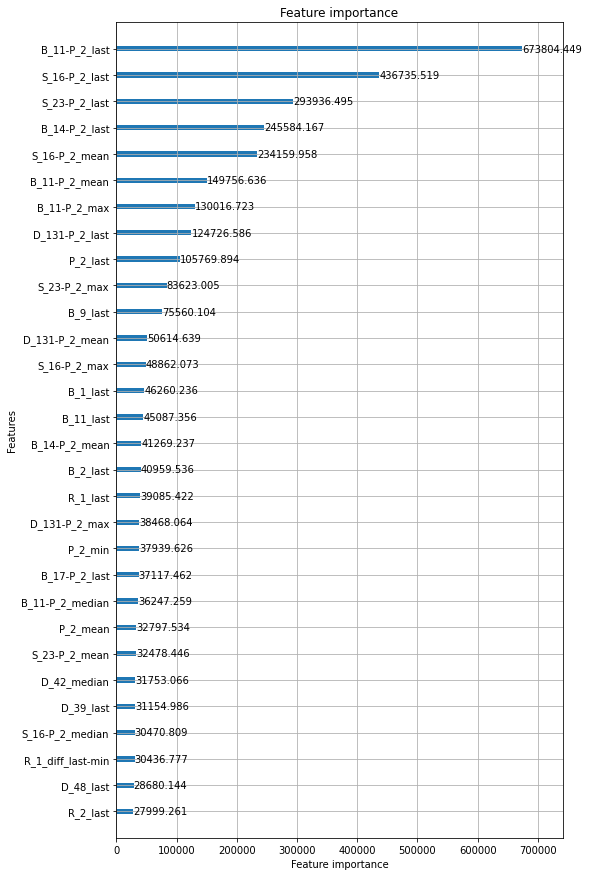

######################################## training model 3/5 ########################################
seed: 12


[50]	valid_0's amex_metric: 0.754266	valid_0's recall_at4: 0.607633	valid_0's norm_gini: 0.900898


[100]	valid_0's amex_metric: 0.766604	valid_0's recall_at4: 0.625936	valid_0's norm_gini: 0.907271


[150]	valid_0's amex_metric: 0.773998	valid_0's recall_at4: 0.636834	valid_0's norm_gini: 0.911162


[200]	valid_0's amex_metric: 0.777593	valid_0's recall_at4: 0.641084	valid_0's norm_gini: 0.914102


[250]	valid_0's amex_metric: 0.78146	valid_0's recall_at4: 0.646554	valid_0's norm_gini: 0.916367


[300]	valid_0's amex_metric: 0.785367	valid_0's recall_at4: 0.65236	valid_0's norm_gini: 0.918373


[350]	valid_0's amex_metric: 0.787189	valid_0's recall_at4: 0.655306	valid_0's norm_gini: 0.919072


[400]	valid_0's amex_metric: 0.787905	valid_0's recall_at4: 0.655979	valid_0's norm_gini: 0.91983


[450]	valid_0's amex_metric: 0.790481	valid_0's recall_at4: 0.660271	valid_0's norm_gini: 0.92069


[500]	valid_0's amex_metric: 0.791941	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.921466


[550]	valid_0's amex_metric: 0.793123	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.922061


[600]	valid_0's amex_metric: 0.793648	valid_0's recall_at4: 0.664731	valid_0's norm_gini: 0.922564


[650]	valid_0's amex_metric: 0.794692	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.922928


[700]	valid_0's amex_metric: 0.795145	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.923161


[750]	valid_0's amex_metric: 0.79589	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.923431


[800]	valid_0's amex_metric: 0.796231	valid_0's recall_at4: 0.668813	valid_0's norm_gini: 0.92365


[850]	valid_0's amex_metric: 0.796689	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.923893


[900]	valid_0's amex_metric: 0.797047	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.924061


[950]	valid_0's amex_metric: 0.797556	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.924237


[1000]	valid_0's amex_metric: 0.797721	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.924315


[1050]	valid_0's amex_metric: 0.798228	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.924403


[1100]	valid_0's amex_metric: 0.797686	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.924498


[1150]	valid_0's amex_metric: 0.798222	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.924686


[1200]	valid_0's amex_metric: 0.798179	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.92481


[1250]	valid_0's amex_metric: 0.79851	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.924925


[1300]	valid_0's amex_metric: 0.79849	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.92497


[1350]	valid_0's amex_metric: 0.798686	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.925025


[1400]	valid_0's amex_metric: 0.799156	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.925124


[1450]	valid_0's amex_metric: 0.799465	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.925194


[1500]	valid_0's amex_metric: 0.799265	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.925257


[1550]	valid_0's amex_metric: 0.799358	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925317


[1600]	valid_0's amex_metric: 0.799174	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.925369


[1650]	valid_0's amex_metric: 0.798977	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925396


[1700]	valid_0's amex_metric: 0.799088	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.92545


[1750]	valid_0's amex_metric: 0.799731	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.925516


[1800]	valid_0's amex_metric: 0.799897	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.925554


[1850]	valid_0's amex_metric: 0.799468	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.92558


[1900]	valid_0's amex_metric: 0.799844	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.925616


[1950]	valid_0's amex_metric: 0.799854	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.925635


[2000]	valid_0's amex_metric: 0.799665	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.925678


[2050]	valid_0's amex_metric: 0.799761	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.925703


[2100]	valid_0's amex_metric: 0.799187	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.925733


[2150]	valid_0's amex_metric: 0.799436	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.925768


[2200]	valid_0's amex_metric: 0.799589	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.92578


[2250]	valid_0's amex_metric: 0.799584	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.925812


[2300]	valid_0's amex_metric: 0.799381	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.925825


[2350]	valid_0's amex_metric: 0.799089	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.925831


[2400]	valid_0's amex_metric: 0.799394	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.925851


[2450]	valid_0's amex_metric: 0.799154	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.925877


[2500]	valid_0's amex_metric: 0.799177	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.92588


[2550]	valid_0's amex_metric: 0.799673	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.925904


[2600]	valid_0's amex_metric: 0.799512	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.92592


[2650]	valid_0's amex_metric: 0.79965	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.925943


[2700]	valid_0's amex_metric: 0.799971	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.925954


[2750]	valid_0's amex_metric: 0.799727	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.925971


[2800]	valid_0's amex_metric: 0.800028	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.925985


[2850]	valid_0's amex_metric: 0.799844	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.925994


[2900]	valid_0's amex_metric: 0.800014	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.925998


[2950]	valid_0's amex_metric: 0.7996	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926012


[3000]	valid_0's amex_metric: 0.799879	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.926022


[3050]	valid_0's amex_metric: 0.79956	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.926015


[3100]	valid_0's amex_metric: 0.800084	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926011


[3150]	valid_0's amex_metric: 0.800112	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.926025


[3200]	valid_0's amex_metric: 0.800372	valid_0's recall_at4: 0.674703	valid_0's norm_gini: 0.926041


[3250]	valid_0's amex_metric: 0.800043	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926055


[3300]	valid_0's amex_metric: 0.800512	valid_0's recall_at4: 0.674956	valid_0's norm_gini: 0.926068


[3350]	valid_0's amex_metric: 0.800157	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926073


[3400]	valid_0's amex_metric: 0.799612	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926078


[3450]	valid_0's amex_metric: 0.799331	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926105


[3500]	valid_0's amex_metric: 0.799888	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.926125


[3550]	valid_0's amex_metric: 0.799702	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.92613


[3600]	valid_0's amex_metric: 0.79969	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.926149


[3650]	valid_0's amex_metric: 0.799785	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926171


[3700]	valid_0's amex_metric: 0.799626	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.92619


[3750]	valid_0's amex_metric: 0.799495	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.926181


[3800]	valid_0's amex_metric: 0.7998	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.9262


[3850]	valid_0's amex_metric: 0.79974	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.926207


[3900]	valid_0's amex_metric: 0.799845	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.926207


[3950]	valid_0's amex_metric: 0.800091	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.926193


[4000]	valid_0's amex_metric: 0.800099	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926167


[4050]	valid_0's amex_metric: 0.80018	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.926162


[4100]	valid_0's amex_metric: 0.799717	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.926162


[4150]	valid_0's amex_metric: 0.799865	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926163


[4200]	valid_0's amex_metric: 0.800018	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.926173


[4250]	valid_0's amex_metric: 0.800205	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926169


[4300]	valid_0's amex_metric: 0.800073	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.926157


[4350]	valid_0's amex_metric: 0.799946	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.926156


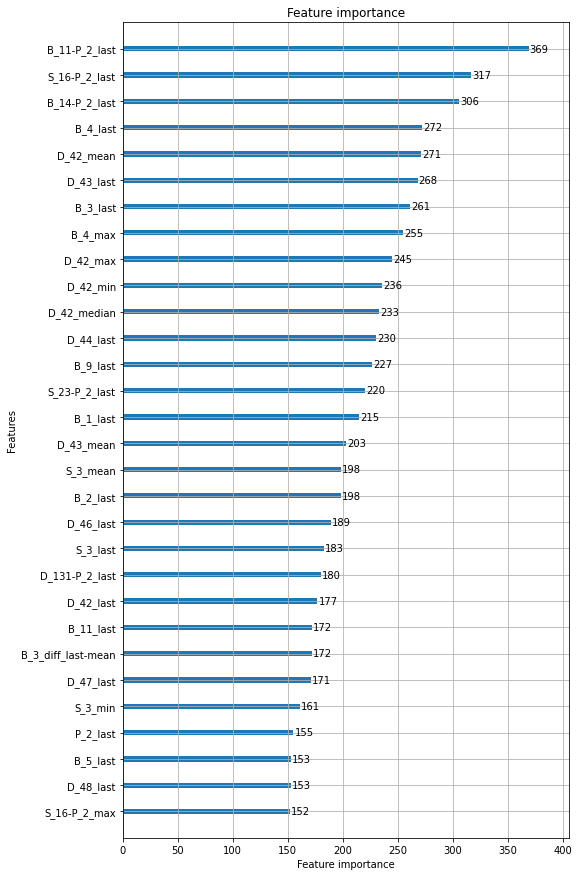

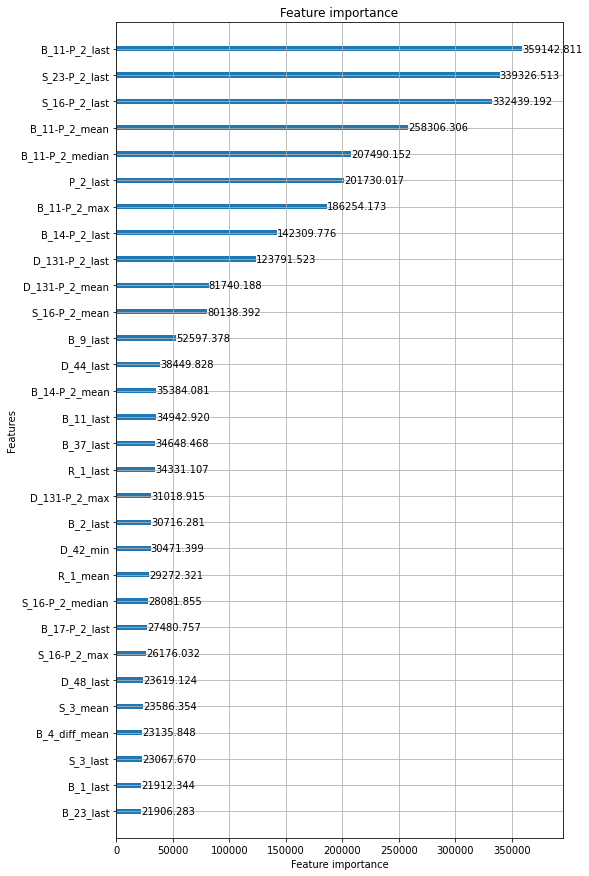

######################################## training model 4/5 ########################################
seed: 13


[50]	valid_0's amex_metric: 0.755785	valid_0's recall_at4: 0.608416	valid_0's norm_gini: 0.903155


[100]	valid_0's amex_metric: 0.768203	valid_0's recall_at4: 0.626131	valid_0's norm_gini: 0.910276


[150]	valid_0's amex_metric: 0.776467	valid_0's recall_at4: 0.638628	valid_0's norm_gini: 0.914305


[200]	valid_0's amex_metric: 0.780374	valid_0's recall_at4: 0.643804	valid_0's norm_gini: 0.916945


[250]	valid_0's amex_metric: 0.782495	valid_0's recall_at4: 0.646792	valid_0's norm_gini: 0.918199


[300]	valid_0's amex_metric: 0.784385	valid_0's recall_at4: 0.649106	valid_0's norm_gini: 0.919665


[350]	valid_0's amex_metric: 0.785499	valid_0's recall_at4: 0.650705	valid_0's norm_gini: 0.920294


[400]	valid_0's amex_metric: 0.787907	valid_0's recall_at4: 0.65445	valid_0's norm_gini: 0.921364


[450]	valid_0's amex_metric: 0.790754	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.922387


[500]	valid_0's amex_metric: 0.791931	valid_0's recall_at4: 0.660846	valid_0's norm_gini: 0.923016


[550]	valid_0's amex_metric: 0.792501	valid_0's recall_at4: 0.661519	valid_0's norm_gini: 0.923483


[600]	valid_0's amex_metric: 0.794319	valid_0's recall_at4: 0.664717	valid_0's norm_gini: 0.923921


[650]	valid_0's amex_metric: 0.794975	valid_0's recall_at4: 0.665516	valid_0's norm_gini: 0.924434


[700]	valid_0's amex_metric: 0.796722	valid_0's recall_at4: 0.66842	valid_0's norm_gini: 0.925024


[750]	valid_0's amex_metric: 0.797314	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925409


[800]	valid_0's amex_metric: 0.797786	valid_0's recall_at4: 0.669851	valid_0's norm_gini: 0.925721


[850]	valid_0's amex_metric: 0.798064	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.926068


[900]	valid_0's amex_metric: 0.798473	valid_0's recall_at4: 0.670608	valid_0's norm_gini: 0.926339


[950]	valid_0's amex_metric: 0.799686	valid_0's recall_at4: 0.672838	valid_0's norm_gini: 0.926535


[1000]	valid_0's amex_metric: 0.800249	valid_0's recall_at4: 0.673764	valid_0's norm_gini: 0.926734


[1050]	valid_0's amex_metric: 0.800079	valid_0's recall_at4: 0.673301	valid_0's norm_gini: 0.926857


[1100]	valid_0's amex_metric: 0.800516	valid_0's recall_at4: 0.673974	valid_0's norm_gini: 0.927058


[1150]	valid_0's amex_metric: 0.800629	valid_0's recall_at4: 0.674058	valid_0's norm_gini: 0.927199


[1200]	valid_0's amex_metric: 0.800797	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.927325


[1250]	valid_0's amex_metric: 0.801206	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.927512


[1300]	valid_0's amex_metric: 0.801797	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.927643


[1350]	valid_0's amex_metric: 0.801981	valid_0's recall_at4: 0.676247	valid_0's norm_gini: 0.927714


[1400]	valid_0's amex_metric: 0.80193	valid_0's recall_at4: 0.676036	valid_0's norm_gini: 0.927824


[1450]	valid_0's amex_metric: 0.802687	valid_0's recall_at4: 0.677467	valid_0's norm_gini: 0.927906


[1500]	valid_0's amex_metric: 0.802937	valid_0's recall_at4: 0.677888	valid_0's norm_gini: 0.927986


[1550]	valid_0's amex_metric: 0.803393	valid_0's recall_at4: 0.678687	valid_0's norm_gini: 0.928098


[1600]	valid_0's amex_metric: 0.803471	valid_0's recall_at4: 0.678771	valid_0's norm_gini: 0.928171


[1650]	valid_0's amex_metric: 0.803163	valid_0's recall_at4: 0.678098	valid_0's norm_gini: 0.928227


[1700]	valid_0's amex_metric: 0.803315	valid_0's recall_at4: 0.678308	valid_0's norm_gini: 0.928322


[1750]	valid_0's amex_metric: 0.803285	valid_0's recall_at4: 0.678182	valid_0's norm_gini: 0.928387


[1800]	valid_0's amex_metric: 0.803423	valid_0's recall_at4: 0.678435	valid_0's norm_gini: 0.928411


[1850]	valid_0's amex_metric: 0.803471	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.928465


[1900]	valid_0's amex_metric: 0.803924	valid_0's recall_at4: 0.679318	valid_0's norm_gini: 0.928529


[1950]	valid_0's amex_metric: 0.804309	valid_0's recall_at4: 0.680034	valid_0's norm_gini: 0.928584


[2000]	valid_0's amex_metric: 0.804893	valid_0's recall_at4: 0.681128	valid_0's norm_gini: 0.928658


[2050]	valid_0's amex_metric: 0.80498	valid_0's recall_at4: 0.681254	valid_0's norm_gini: 0.928707


[2100]	valid_0's amex_metric: 0.804821	valid_0's recall_at4: 0.680917	valid_0's norm_gini: 0.928725


[2150]	valid_0's amex_metric: 0.804467	valid_0's recall_at4: 0.68016	valid_0's norm_gini: 0.928775


[2200]	valid_0's amex_metric: 0.804206	valid_0's recall_at4: 0.679613	valid_0's norm_gini: 0.9288


[2250]	valid_0's amex_metric: 0.804538	valid_0's recall_at4: 0.680244	valid_0's norm_gini: 0.928832


[2300]	valid_0's amex_metric: 0.804898	valid_0's recall_at4: 0.680959	valid_0's norm_gini: 0.928836


[2350]	valid_0's amex_metric: 0.804825	valid_0's recall_at4: 0.680791	valid_0's norm_gini: 0.92886


[2400]	valid_0's amex_metric: 0.804335	valid_0's recall_at4: 0.679781	valid_0's norm_gini: 0.928888


[2450]	valid_0's amex_metric: 0.804578	valid_0's recall_at4: 0.680244	valid_0's norm_gini: 0.928912


[2500]	valid_0's amex_metric: 0.804291	valid_0's recall_at4: 0.679655	valid_0's norm_gini: 0.928926


[2550]	valid_0's amex_metric: 0.80382	valid_0's recall_at4: 0.678687	valid_0's norm_gini: 0.928952


[2600]	valid_0's amex_metric: 0.804136	valid_0's recall_at4: 0.679318	valid_0's norm_gini: 0.928953


[2650]	valid_0's amex_metric: 0.80413	valid_0's recall_at4: 0.679234	valid_0's norm_gini: 0.929027


[2700]	valid_0's amex_metric: 0.804424	valid_0's recall_at4: 0.679781	valid_0's norm_gini: 0.929068


[2750]	valid_0's amex_metric: 0.80407	valid_0's recall_at4: 0.679066	valid_0's norm_gini: 0.929074


[2800]	valid_0's amex_metric: 0.804985	valid_0's recall_at4: 0.680875	valid_0's norm_gini: 0.929095


[2850]	valid_0's amex_metric: 0.804695	valid_0's recall_at4: 0.680286	valid_0's norm_gini: 0.929103


[2900]	valid_0's amex_metric: 0.80467	valid_0's recall_at4: 0.680244	valid_0's norm_gini: 0.929096


[2950]	valid_0's amex_metric: 0.804898	valid_0's recall_at4: 0.680665	valid_0's norm_gini: 0.92913


[3000]	valid_0's amex_metric: 0.805022	valid_0's recall_at4: 0.680917	valid_0's norm_gini: 0.929126


[3050]	valid_0's amex_metric: 0.804666	valid_0's recall_at4: 0.680202	valid_0's norm_gini: 0.92913


[3100]	valid_0's amex_metric: 0.805795	valid_0's recall_at4: 0.682432	valid_0's norm_gini: 0.929158


[3150]	valid_0's amex_metric: 0.805077	valid_0's recall_at4: 0.681001	valid_0's norm_gini: 0.929152


[3200]	valid_0's amex_metric: 0.804569	valid_0's recall_at4: 0.679992	valid_0's norm_gini: 0.929146


[3250]	valid_0's amex_metric: 0.804575	valid_0's recall_at4: 0.679992	valid_0's norm_gini: 0.929159


[3300]	valid_0's amex_metric: 0.804887	valid_0's recall_at4: 0.680623	valid_0's norm_gini: 0.929151


[3350]	valid_0's amex_metric: 0.804654	valid_0's recall_at4: 0.68016	valid_0's norm_gini: 0.929148


[3400]	valid_0's amex_metric: 0.804762	valid_0's recall_at4: 0.68037	valid_0's norm_gini: 0.929154


[3450]	valid_0's amex_metric: 0.80462	valid_0's recall_at4: 0.680076	valid_0's norm_gini: 0.929164


[3500]	valid_0's amex_metric: 0.804834	valid_0's recall_at4: 0.680497	valid_0's norm_gini: 0.929171


[3550]	valid_0's amex_metric: 0.805077	valid_0's recall_at4: 0.681001	valid_0's norm_gini: 0.929152


[3600]	valid_0's amex_metric: 0.804854	valid_0's recall_at4: 0.680539	valid_0's norm_gini: 0.929169


[3650]	valid_0's amex_metric: 0.805578	valid_0's recall_at4: 0.681969	valid_0's norm_gini: 0.929186


[3700]	valid_0's amex_metric: 0.80552	valid_0's recall_at4: 0.681843	valid_0's norm_gini: 0.929196


[3750]	valid_0's amex_metric: 0.805184	valid_0's recall_at4: 0.68117	valid_0's norm_gini: 0.929198


[3800]	valid_0's amex_metric: 0.805264	valid_0's recall_at4: 0.681338	valid_0's norm_gini: 0.92919


[3850]	valid_0's amex_metric: 0.804658	valid_0's recall_at4: 0.680118	valid_0's norm_gini: 0.929198


[3900]	valid_0's amex_metric: 0.804999	valid_0's recall_at4: 0.680791	valid_0's norm_gini: 0.929207


[3950]	valid_0's amex_metric: 0.805104	valid_0's recall_at4: 0.681001	valid_0's norm_gini: 0.929206


[4000]	valid_0's amex_metric: 0.805338	valid_0's recall_at4: 0.681464	valid_0's norm_gini: 0.929211


[4050]	valid_0's amex_metric: 0.805382	valid_0's recall_at4: 0.681548	valid_0's norm_gini: 0.929215


[4100]	valid_0's amex_metric: 0.805764	valid_0's recall_at4: 0.682306	valid_0's norm_gini: 0.929221


[4150]	valid_0's amex_metric: 0.805782	valid_0's recall_at4: 0.682348	valid_0's norm_gini: 0.929217


[4200]	valid_0's amex_metric: 0.805509	valid_0's recall_at4: 0.681801	valid_0's norm_gini: 0.929217


[4250]	valid_0's amex_metric: 0.80583	valid_0's recall_at4: 0.682432	valid_0's norm_gini: 0.929229


[4300]	valid_0's amex_metric: 0.805576	valid_0's recall_at4: 0.681927	valid_0's norm_gini: 0.929224


[4350]	valid_0's amex_metric: 0.805987	valid_0's recall_at4: 0.682769	valid_0's norm_gini: 0.929205


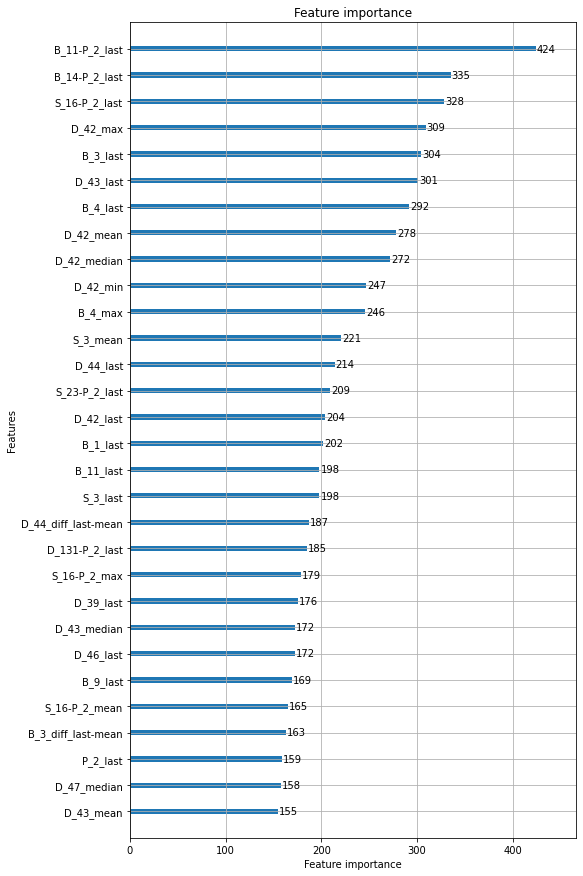

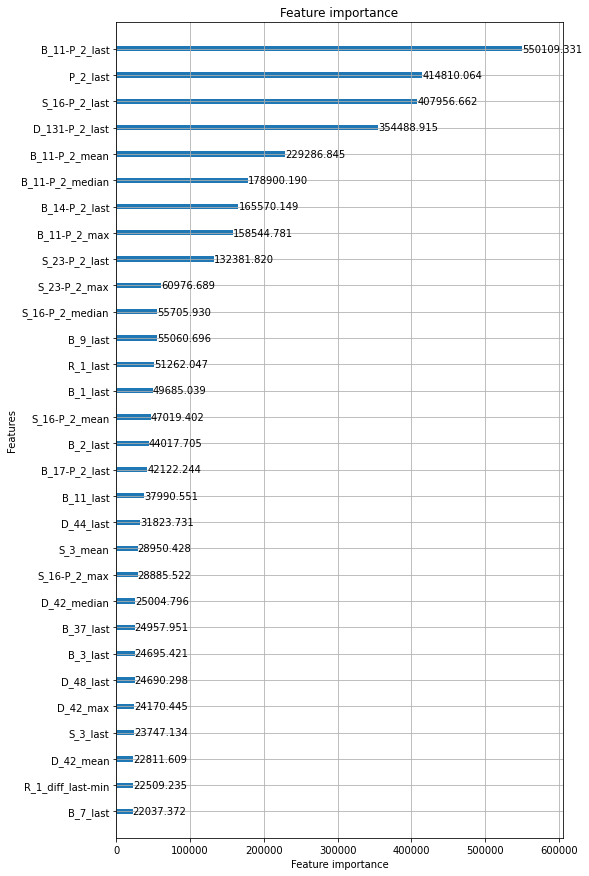

######################################## training model 5/5 ########################################
seed: 14


[50]	valid_0's amex_metric: 0.75225	valid_0's recall_at4: 0.605134	valid_0's norm_gini: 0.899366


[100]	valid_0's amex_metric: 0.762833	valid_0's recall_at4: 0.619609	valid_0's norm_gini: 0.906058


[150]	valid_0's amex_metric: 0.768071	valid_0's recall_at4: 0.627183	valid_0's norm_gini: 0.90896


[200]	valid_0's amex_metric: 0.773477	valid_0's recall_at4: 0.635009	valid_0's norm_gini: 0.911944


[250]	valid_0's amex_metric: 0.776735	valid_0's recall_at4: 0.639428	valid_0's norm_gini: 0.914043


[300]	valid_0's amex_metric: 0.778899	valid_0's recall_at4: 0.642205	valid_0's norm_gini: 0.915594


[350]	valid_0's amex_metric: 0.782077	valid_0's recall_at4: 0.646918	valid_0's norm_gini: 0.917236


[400]	valid_0's amex_metric: 0.784236	valid_0's recall_at4: 0.650032	valid_0's norm_gini: 0.918441


[450]	valid_0's amex_metric: 0.785176	valid_0's recall_at4: 0.651252	valid_0's norm_gini: 0.919099


[500]	valid_0's amex_metric: 0.78592	valid_0's recall_at4: 0.652178	valid_0's norm_gini: 0.919663


[550]	valid_0's amex_metric: 0.787267	valid_0's recall_at4: 0.654155	valid_0's norm_gini: 0.920378


[600]	valid_0's amex_metric: 0.788626	valid_0's recall_at4: 0.656428	valid_0's norm_gini: 0.920825


[650]	valid_0's amex_metric: 0.788807	valid_0's recall_at4: 0.656385	valid_0's norm_gini: 0.921229


[700]	valid_0's amex_metric: 0.789209	valid_0's recall_at4: 0.65668	valid_0's norm_gini: 0.921739


[750]	valid_0's amex_metric: 0.790004	valid_0's recall_at4: 0.658027	valid_0's norm_gini: 0.921982


[800]	valid_0's amex_metric: 0.789947	valid_0's recall_at4: 0.657648	valid_0's norm_gini: 0.922247


[850]	valid_0's amex_metric: 0.78998	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.922522


[900]	valid_0's amex_metric: 0.789713	valid_0's recall_at4: 0.65668	valid_0's norm_gini: 0.922745


[950]	valid_0's amex_metric: 0.791029	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.922895


[1000]	valid_0's amex_metric: 0.791363	valid_0's recall_at4: 0.659625	valid_0's norm_gini: 0.9231


[1050]	valid_0's amex_metric: 0.791395	valid_0's recall_at4: 0.659583	valid_0's norm_gini: 0.923207


[1100]	valid_0's amex_metric: 0.79135	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.923327


[1150]	valid_0's amex_metric: 0.792044	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.923494


[1200]	valid_0's amex_metric: 0.792267	valid_0's recall_at4: 0.660972	valid_0's norm_gini: 0.923561


[1250]	valid_0's amex_metric: 0.791809	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923656


[1300]	valid_0's amex_metric: 0.792615	valid_0's recall_at4: 0.661477	valid_0's norm_gini: 0.923752


[1350]	valid_0's amex_metric: 0.792656	valid_0's recall_at4: 0.661477	valid_0's norm_gini: 0.923834


[1400]	valid_0's amex_metric: 0.792964	valid_0's recall_at4: 0.662066	valid_0's norm_gini: 0.923863


[1450]	valid_0's amex_metric: 0.79322	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.923952


[1500]	valid_0's amex_metric: 0.793677	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924025


[1550]	valid_0's amex_metric: 0.79399	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.924105


[1600]	valid_0's amex_metric: 0.79425	valid_0's recall_at4: 0.664338	valid_0's norm_gini: 0.924161


[1650]	valid_0's amex_metric: 0.794415	valid_0's recall_at4: 0.664591	valid_0's norm_gini: 0.924239


[1700]	valid_0's amex_metric: 0.794221	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.924315


[1750]	valid_0's amex_metric: 0.79436	valid_0's recall_at4: 0.664338	valid_0's norm_gini: 0.924382


[1800]	valid_0's amex_metric: 0.794563	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.924452


[1850]	valid_0's amex_metric: 0.794255	valid_0's recall_at4: 0.664002	valid_0's norm_gini: 0.924508


[1900]	valid_0's amex_metric: 0.794423	valid_0's recall_at4: 0.664296	valid_0's norm_gini: 0.924549


[1950]	valid_0's amex_metric: 0.794376	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924582


[2000]	valid_0's amex_metric: 0.794686	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.924613


[2050]	valid_0's amex_metric: 0.794915	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.92465


[2100]	valid_0's amex_metric: 0.795076	valid_0's recall_at4: 0.665474	valid_0's norm_gini: 0.924677


[2150]	valid_0's amex_metric: 0.794863	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924715


[2200]	valid_0's amex_metric: 0.795353	valid_0's recall_at4: 0.665937	valid_0's norm_gini: 0.924769


[2250]	valid_0's amex_metric: 0.795754	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.924814


[2300]	valid_0's amex_metric: 0.79558	valid_0's recall_at4: 0.666316	valid_0's norm_gini: 0.924845


[2350]	valid_0's amex_metric: 0.795595	valid_0's recall_at4: 0.666316	valid_0's norm_gini: 0.924875


[2400]	valid_0's amex_metric: 0.795531	valid_0's recall_at4: 0.666148	valid_0's norm_gini: 0.924914


[2450]	valid_0's amex_metric: 0.795835	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.924976


[2500]	valid_0's amex_metric: 0.795503	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.924985


[2550]	valid_0's amex_metric: 0.795103	valid_0's recall_at4: 0.665222	valid_0's norm_gini: 0.924984


[2600]	valid_0's amex_metric: 0.795584	valid_0's recall_at4: 0.666148	valid_0's norm_gini: 0.925021


[2650]	valid_0's amex_metric: 0.795887	valid_0's recall_at4: 0.666737	valid_0's norm_gini: 0.925037


[2700]	valid_0's amex_metric: 0.795791	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.925056


[2750]	valid_0's amex_metric: 0.79585	valid_0's recall_at4: 0.666653	valid_0's norm_gini: 0.925048


[2800]	valid_0's amex_metric: 0.795883	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.925071


[2850]	valid_0's amex_metric: 0.795442	valid_0's recall_at4: 0.665811	valid_0's norm_gini: 0.925074


[2900]	valid_0's amex_metric: 0.795239	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.925088


[2950]	valid_0's amex_metric: 0.794924	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.925089


[3000]	valid_0's amex_metric: 0.795077	valid_0's recall_at4: 0.665054	valid_0's norm_gini: 0.925101


[3050]	valid_0's amex_metric: 0.795222	valid_0's recall_at4: 0.665348	valid_0's norm_gini: 0.925095


[3100]	valid_0's amex_metric: 0.795119	valid_0's recall_at4: 0.665138	valid_0's norm_gini: 0.9251


[3150]	valid_0's amex_metric: 0.794921	valid_0's recall_at4: 0.664717	valid_0's norm_gini: 0.925126


[3200]	valid_0's amex_metric: 0.794876	valid_0's recall_at4: 0.664591	valid_0's norm_gini: 0.925161


[3250]	valid_0's amex_metric: 0.794892	valid_0's recall_at4: 0.664591	valid_0's norm_gini: 0.925193


[3300]	valid_0's amex_metric: 0.794786	valid_0's recall_at4: 0.66438	valid_0's norm_gini: 0.925192


[3350]	valid_0's amex_metric: 0.794724	valid_0's recall_at4: 0.664254	valid_0's norm_gini: 0.925195


[3400]	valid_0's amex_metric: 0.794858	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.92521


[3450]	valid_0's amex_metric: 0.795413	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.925182


[3500]	valid_0's amex_metric: 0.795311	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.925189


[3550]	valid_0's amex_metric: 0.795104	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.925196


[3600]	valid_0's amex_metric: 0.795518	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.925182


[3650]	valid_0's amex_metric: 0.795514	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.925174


[3700]	valid_0's amex_metric: 0.795955	valid_0's recall_at4: 0.666737	valid_0's norm_gini: 0.925174


[3750]	valid_0's amex_metric: 0.795572	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.925165


[3800]	valid_0's amex_metric: 0.795622	valid_0's recall_at4: 0.666064	valid_0's norm_gini: 0.925179


[3850]	valid_0's amex_metric: 0.795649	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.925193


[3900]	valid_0's amex_metric: 0.795569	valid_0's recall_at4: 0.665937	valid_0's norm_gini: 0.9252


[3950]	valid_0's amex_metric: 0.795294	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.925197


[4000]	valid_0's amex_metric: 0.795228	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.925192


[4050]	valid_0's amex_metric: 0.794983	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.925207


[4100]	valid_0's amex_metric: 0.795113	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.925215


[4150]	valid_0's amex_metric: 0.795192	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.925204


[4200]	valid_0's amex_metric: 0.795408	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.925215


[4250]	valid_0's amex_metric: 0.795635	valid_0's recall_at4: 0.666064	valid_0's norm_gini: 0.925207


[4300]	valid_0's amex_metric: 0.795678	valid_0's recall_at4: 0.666148	valid_0's norm_gini: 0.925208


[4350]	valid_0's amex_metric: 0.795406	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.925212


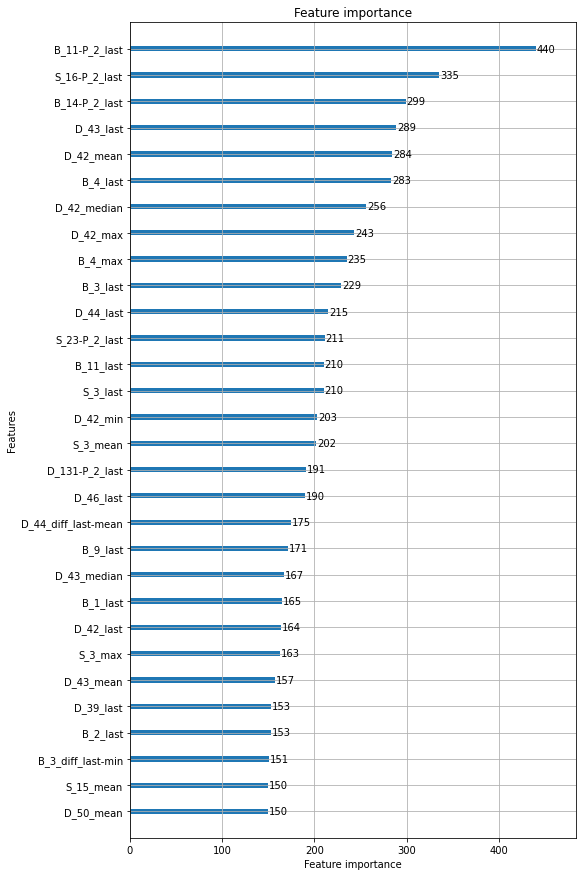

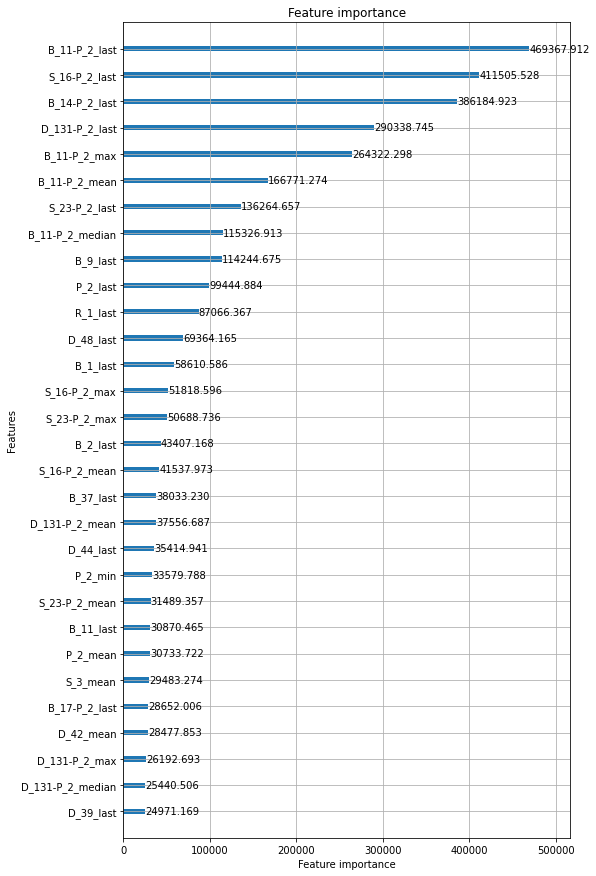

Training time: 38.647523033618924 min.
OOF recall_at4: 0.670784663547312
OOF normalized_gini: 0.9260903088284004
OOF competition metric: 0.7984374861878563


############################### repeated cross-validation step: 4/5 ################################


######################################## training model 1/5 ########################################
seed: 15


[50]	valid_0's amex_metric: 0.749652	valid_0's recall_at4: 0.600648	valid_0's norm_gini: 0.898656


[100]	valid_0's amex_metric: 0.759875	valid_0's recall_at4: 0.614954	valid_0's norm_gini: 0.904796


[150]	valid_0's amex_metric: 0.766679	valid_0's recall_at4: 0.624295	valid_0's norm_gini: 0.909063


[200]	valid_0's amex_metric: 0.770418	valid_0's recall_at4: 0.629429	valid_0's norm_gini: 0.911407


[250]	valid_0's amex_metric: 0.774327	valid_0's recall_at4: 0.63473	valid_0's norm_gini: 0.913924


[300]	valid_0's amex_metric: 0.777917	valid_0's recall_at4: 0.640284	valid_0's norm_gini: 0.91555


[350]	valid_0's amex_metric: 0.780302	valid_0's recall_at4: 0.643861	valid_0's norm_gini: 0.916743


[400]	valid_0's amex_metric: 0.782736	valid_0's recall_at4: 0.647311	valid_0's norm_gini: 0.91816


[450]	valid_0's amex_metric: 0.783217	valid_0's recall_at4: 0.647648	valid_0's norm_gini: 0.918787


[500]	valid_0's amex_metric: 0.784268	valid_0's recall_at4: 0.649163	valid_0's norm_gini: 0.919374


[550]	valid_0's amex_metric: 0.785262	valid_0's recall_at4: 0.650635	valid_0's norm_gini: 0.919889


[600]	valid_0's amex_metric: 0.786032	valid_0's recall_at4: 0.651687	valid_0's norm_gini: 0.920377


[650]	valid_0's amex_metric: 0.787358	valid_0's recall_at4: 0.653917	valid_0's norm_gini: 0.920798


[700]	valid_0's amex_metric: 0.787252	valid_0's recall_at4: 0.653455	valid_0's norm_gini: 0.92105


[750]	valid_0's amex_metric: 0.788201	valid_0's recall_at4: 0.655053	valid_0's norm_gini: 0.921348


[800]	valid_0's amex_metric: 0.788377	valid_0's recall_at4: 0.65518	valid_0's norm_gini: 0.921575


[850]	valid_0's amex_metric: 0.788732	valid_0's recall_at4: 0.655685	valid_0's norm_gini: 0.921779


[900]	valid_0's amex_metric: 0.789781	valid_0's recall_at4: 0.657536	valid_0's norm_gini: 0.922026


[950]	valid_0's amex_metric: 0.789625	valid_0's recall_at4: 0.657115	valid_0's norm_gini: 0.922135


[1000]	valid_0's amex_metric: 0.789879	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.922305


[1050]	valid_0's amex_metric: 0.790586	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.922457


[1100]	valid_0's amex_metric: 0.790427	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.922604


[1150]	valid_0's amex_metric: 0.790917	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.9227


[1200]	valid_0's amex_metric: 0.790983	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.922832


[1250]	valid_0's amex_metric: 0.790884	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.922969


[1300]	valid_0's amex_metric: 0.791117	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.923058


[1350]	valid_0's amex_metric: 0.791093	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.923094


[1400]	valid_0's amex_metric: 0.791875	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.923142


[1450]	valid_0's amex_metric: 0.791837	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.923192


[1500]	valid_0's amex_metric: 0.792451	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923285


[1550]	valid_0's amex_metric: 0.792357	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.923349


[1600]	valid_0's amex_metric: 0.792926	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.923392


[1650]	valid_0's amex_metric: 0.793135	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.923432


[1700]	valid_0's amex_metric: 0.792712	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.923511


[1750]	valid_0's amex_metric: 0.792685	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.923542


[1800]	valid_0's amex_metric: 0.792578	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.923582


[1850]	valid_0's amex_metric: 0.792503	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.923642


[1900]	valid_0's amex_metric: 0.792688	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.923673


[1950]	valid_0's amex_metric: 0.792309	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.923675


[2000]	valid_0's amex_metric: 0.792432	valid_0's recall_at4: 0.661155	valid_0's norm_gini: 0.923709


[2050]	valid_0's amex_metric: 0.792227	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.92372


[2100]	valid_0's amex_metric: 0.792251	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.923767


[2150]	valid_0's amex_metric: 0.792314	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.923811


[2200]	valid_0's amex_metric: 0.79228	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.923826


[2250]	valid_0's amex_metric: 0.791928	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.923838


[2300]	valid_0's amex_metric: 0.792331	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923886


[2350]	valid_0's amex_metric: 0.792338	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.9239


[2400]	valid_0's amex_metric: 0.792666	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.923925


[2450]	valid_0's amex_metric: 0.792784	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923951


[2500]	valid_0's amex_metric: 0.793299	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.92397


[2550]	valid_0's amex_metric: 0.792852	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.924003


[2600]	valid_0's amex_metric: 0.792402	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.924028


[2650]	valid_0's amex_metric: 0.792517	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.924047


[2700]	valid_0's amex_metric: 0.792716	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.924067


[2750]	valid_0's amex_metric: 0.792372	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.924094


[2800]	valid_0's amex_metric: 0.792342	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.924118


[2850]	valid_0's amex_metric: 0.792762	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.924116


[2900]	valid_0's amex_metric: 0.793013	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.924157


[2950]	valid_0's amex_metric: 0.793024	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.924135


[3000]	valid_0's amex_metric: 0.793301	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924144


[3050]	valid_0's amex_metric: 0.792882	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924147


[3100]	valid_0's amex_metric: 0.793031	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.924149


[3150]	valid_0's amex_metric: 0.79329	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.924162


[3200]	valid_0's amex_metric: 0.79291	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.92416


[3250]	valid_0's amex_metric: 0.792879	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.924184


[3300]	valid_0's amex_metric: 0.792846	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.9242


[3350]	valid_0's amex_metric: 0.793203	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.9242


[3400]	valid_0's amex_metric: 0.793045	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.92422


[3450]	valid_0's amex_metric: 0.793215	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.924223


[3500]	valid_0's amex_metric: 0.793349	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924238


[3550]	valid_0's amex_metric: 0.793373	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.924246


[3600]	valid_0's amex_metric: 0.793041	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.924253


[3650]	valid_0's amex_metric: 0.793048	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.924268


[3700]	valid_0's amex_metric: 0.792771	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.924262


[3750]	valid_0's amex_metric: 0.79308	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.924248


[3800]	valid_0's amex_metric: 0.793183	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.924243


[3850]	valid_0's amex_metric: 0.793222	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.924237


[3900]	valid_0's amex_metric: 0.793329	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.924241


[3950]	valid_0's amex_metric: 0.793121	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.924247


[4000]	valid_0's amex_metric: 0.79297	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.924238


[4050]	valid_0's amex_metric: 0.793243	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.924238


[4100]	valid_0's amex_metric: 0.792614	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.924242


[4150]	valid_0's amex_metric: 0.793343	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924227


[4200]	valid_0's amex_metric: 0.79312	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.924243


[4250]	valid_0's amex_metric: 0.793173	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.924224


[4300]	valid_0's amex_metric: 0.79292	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924222


[4350]	valid_0's amex_metric: 0.792831	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.924213


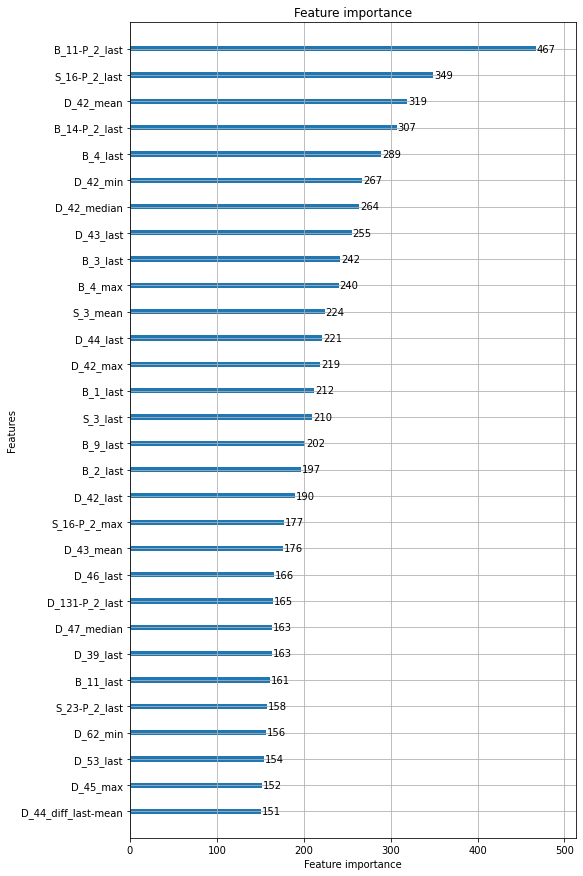

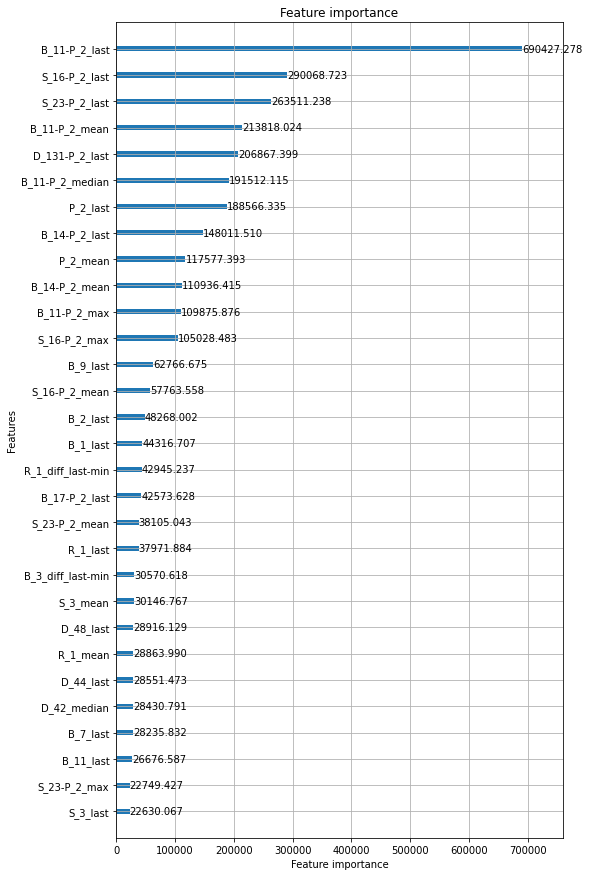

######################################## training model 2/5 ########################################
seed: 16


[50]	valid_0's amex_metric: 0.757406	valid_0's recall_at4: 0.612009	valid_0's norm_gini: 0.902803


[100]	valid_0's amex_metric: 0.76534	valid_0's recall_at4: 0.622065	valid_0's norm_gini: 0.908614


[150]	valid_0's amex_metric: 0.773111	valid_0's recall_at4: 0.633216	valid_0's norm_gini: 0.913007


[200]	valid_0's amex_metric: 0.777644	valid_0's recall_at4: 0.639737	valid_0's norm_gini: 0.91555


[250]	valid_0's amex_metric: 0.780023	valid_0's recall_at4: 0.642893	valid_0's norm_gini: 0.917152


[300]	valid_0's amex_metric: 0.782387	valid_0's recall_at4: 0.64647	valid_0's norm_gini: 0.918304


[350]	valid_0's amex_metric: 0.785582	valid_0's recall_at4: 0.651351	valid_0's norm_gini: 0.919813


[400]	valid_0's amex_metric: 0.787264	valid_0's recall_at4: 0.653875	valid_0's norm_gini: 0.920652


[450]	valid_0's amex_metric: 0.788659	valid_0's recall_at4: 0.656063	valid_0's norm_gini: 0.921254


[500]	valid_0's amex_metric: 0.789976	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.921869


[550]	valid_0's amex_metric: 0.791066	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.922407


[600]	valid_0's amex_metric: 0.79186	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.922775


[650]	valid_0's amex_metric: 0.79245	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.923157


[700]	valid_0's amex_metric: 0.792222	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.923541


[750]	valid_0's amex_metric: 0.792858	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.923803


[800]	valid_0's amex_metric: 0.793068	valid_0's recall_at4: 0.66208	valid_0's norm_gini: 0.924056


[850]	valid_0's amex_metric: 0.793604	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924245


[900]	valid_0's amex_metric: 0.79492	valid_0's recall_at4: 0.665362	valid_0's norm_gini: 0.924477


[950]	valid_0's amex_metric: 0.794868	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.924625


[1000]	valid_0's amex_metric: 0.795225	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.924793


[1050]	valid_0's amex_metric: 0.79556	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.924958


[1100]	valid_0's amex_metric: 0.795464	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.925104


[1150]	valid_0's amex_metric: 0.796861	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.925204


[1200]	valid_0's amex_metric: 0.796819	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925288


[1250]	valid_0's amex_metric: 0.797527	valid_0's recall_at4: 0.669654	valid_0's norm_gini: 0.9254


[1300]	valid_0's amex_metric: 0.797403	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.925488


[1350]	valid_0's amex_metric: 0.797758	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.925567


[1400]	valid_0's amex_metric: 0.797646	valid_0's recall_at4: 0.669612	valid_0's norm_gini: 0.925679


[1450]	valid_0's amex_metric: 0.798222	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.925738


[1500]	valid_0's amex_metric: 0.798078	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.925829


[1550]	valid_0's amex_metric: 0.79772	valid_0's recall_at4: 0.66957	valid_0's norm_gini: 0.925871


[1600]	valid_0's amex_metric: 0.798115	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.925944


[1650]	valid_0's amex_metric: 0.797851	valid_0's recall_at4: 0.669696	valid_0's norm_gini: 0.926007


[1700]	valid_0's amex_metric: 0.798426	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.926063


[1750]	valid_0's amex_metric: 0.798679	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.926105


[1800]	valid_0's amex_metric: 0.798897	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.926163


[1850]	valid_0's amex_metric: 0.799036	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.926189


[1900]	valid_0's amex_metric: 0.79878	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.926222


[1950]	valid_0's amex_metric: 0.798647	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.926251


[2000]	valid_0's amex_metric: 0.799106	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926286


[2050]	valid_0's amex_metric: 0.798784	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.926272


[2100]	valid_0's amex_metric: 0.799134	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.9263


[2150]	valid_0's amex_metric: 0.799229	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926322


[2200]	valid_0's amex_metric: 0.798981	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.92633


[2250]	valid_0's amex_metric: 0.799236	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926336


[2300]	valid_0's amex_metric: 0.799189	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.926326


[2350]	valid_0's amex_metric: 0.799548	valid_0's recall_at4: 0.672768	valid_0's norm_gini: 0.926328


[2400]	valid_0's amex_metric: 0.799081	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926361


[2450]	valid_0's amex_metric: 0.799584	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.926358


[2500]	valid_0's amex_metric: 0.799498	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.926397


[2550]	valid_0's amex_metric: 0.799572	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.926419


[2600]	valid_0's amex_metric: 0.79949	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926423


[2650]	valid_0's amex_metric: 0.799278	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926418


[2700]	valid_0's amex_metric: 0.799087	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.926416


[2750]	valid_0's amex_metric: 0.799282	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926428


[2800]	valid_0's amex_metric: 0.799156	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.926427


[2850]	valid_0's amex_metric: 0.799394	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.92644


[2900]	valid_0's amex_metric: 0.798802	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.926477


[2950]	valid_0's amex_metric: 0.798844	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.926478


[3000]	valid_0's amex_metric: 0.799057	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.926483


[3050]	valid_0's amex_metric: 0.798926	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.926514


[3100]	valid_0's amex_metric: 0.79859	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.926516


[3150]	valid_0's amex_metric: 0.799034	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.92652


[3200]	valid_0's amex_metric: 0.798681	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.926529


[3250]	valid_0's amex_metric: 0.799118	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.92652


[3300]	valid_0's amex_metric: 0.798708	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926541


[3350]	valid_0's amex_metric: 0.799162	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926524


[3400]	valid_0's amex_metric: 0.799037	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.926527


[3450]	valid_0's amex_metric: 0.799317	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926539


[3500]	valid_0's amex_metric: 0.799168	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926536


[3550]	valid_0's amex_metric: 0.799143	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.926528


[3600]	valid_0's amex_metric: 0.799464	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.926539


[3650]	valid_0's amex_metric: 0.799422	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926539


[3700]	valid_0's amex_metric: 0.799639	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.926552


[3750]	valid_0's amex_metric: 0.799719	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.926544


[3800]	valid_0's amex_metric: 0.799566	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926574


[3850]	valid_0's amex_metric: 0.799934	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.926596


[3900]	valid_0's amex_metric: 0.799522	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926613


[3950]	valid_0's amex_metric: 0.799404	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.92663


[4000]	valid_0's amex_metric: 0.799789	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.926641


[4050]	valid_0's amex_metric: 0.799822	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.926623


[4100]	valid_0's amex_metric: 0.799656	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.926628


[4150]	valid_0's amex_metric: 0.79943	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.926596


[4200]	valid_0's amex_metric: 0.799396	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926613


[4250]	valid_0's amex_metric: 0.799582	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926606


[4300]	valid_0's amex_metric: 0.799419	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926617


[4350]	valid_0's amex_metric: 0.799253	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.926621


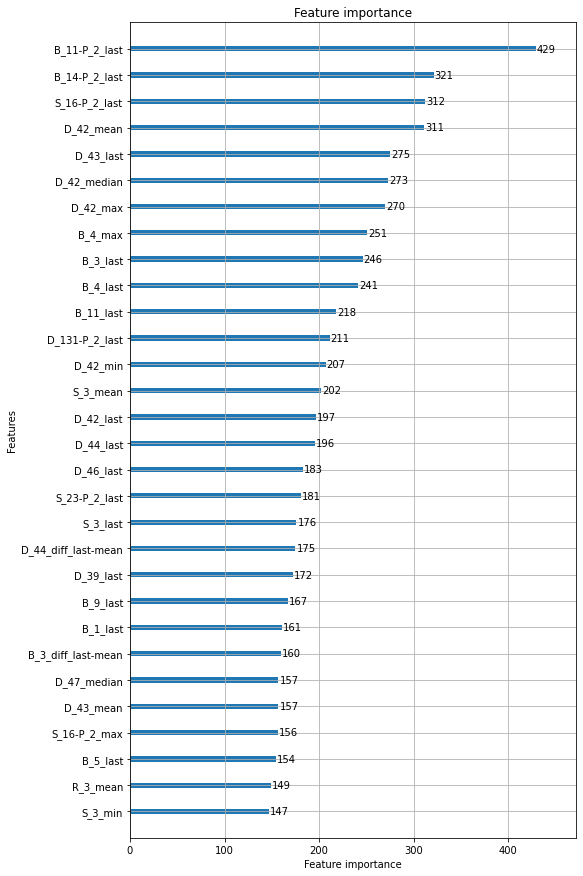

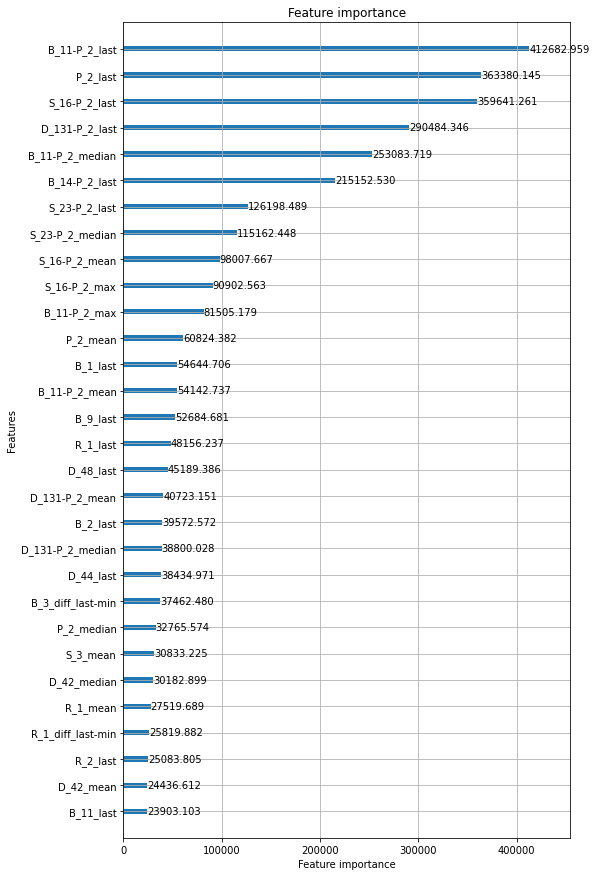

######################################## training model 3/5 ########################################
seed: 17


[50]	valid_0's amex_metric: 0.754597	valid_0's recall_at4: 0.607086	valid_0's norm_gini: 0.902108


[100]	valid_0's amex_metric: 0.764546	valid_0's recall_at4: 0.620971	valid_0's norm_gini: 0.908121


[150]	valid_0's amex_metric: 0.773512	valid_0's recall_at4: 0.633931	valid_0's norm_gini: 0.913094


[200]	valid_0's amex_metric: 0.777789	valid_0's recall_at4: 0.640032	valid_0's norm_gini: 0.915547


[250]	valid_0's amex_metric: 0.779917	valid_0's recall_at4: 0.642767	valid_0's norm_gini: 0.917067


[300]	valid_0's amex_metric: 0.784133	valid_0's recall_at4: 0.649331	valid_0's norm_gini: 0.918934


[350]	valid_0's amex_metric: 0.78594	valid_0's recall_at4: 0.651898	valid_0's norm_gini: 0.919983


[400]	valid_0's amex_metric: 0.788616	valid_0's recall_at4: 0.656021	valid_0's norm_gini: 0.921211


[450]	valid_0's amex_metric: 0.790162	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.922074


[500]	valid_0's amex_metric: 0.791664	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.922721


[550]	valid_0's amex_metric: 0.792922	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.923259


[600]	valid_0's amex_metric: 0.795032	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.923777


[650]	valid_0's amex_metric: 0.795808	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924108


[700]	valid_0's amex_metric: 0.796254	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.924368


[750]	valid_0's amex_metric: 0.796536	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.924681


[800]	valid_0's amex_metric: 0.797833	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.924961


[850]	valid_0's amex_metric: 0.797688	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.925258


[900]	valid_0's amex_metric: 0.797805	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.925535


[950]	valid_0's amex_metric: 0.798669	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.925749


[1000]	valid_0's amex_metric: 0.798394	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925913


[1050]	valid_0's amex_metric: 0.798783	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926061


[1100]	valid_0's amex_metric: 0.799584	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.92619


[1150]	valid_0's amex_metric: 0.799856	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926313


[1200]	valid_0's amex_metric: 0.799874	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.926434


[1250]	valid_0's amex_metric: 0.799937	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.926558


[1300]	valid_0's amex_metric: 0.800433	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.926668


[1350]	valid_0's amex_metric: 0.800506	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926771


[1400]	valid_0's amex_metric: 0.800703	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.926871


[1450]	valid_0's amex_metric: 0.801163	valid_0's recall_at4: 0.675335	valid_0's norm_gini: 0.926991


[1500]	valid_0's amex_metric: 0.801477	valid_0's recall_at4: 0.675882	valid_0's norm_gini: 0.927072


[1550]	valid_0's amex_metric: 0.80199	valid_0's recall_at4: 0.676807	valid_0's norm_gini: 0.927174


[1600]	valid_0's amex_metric: 0.802412	valid_0's recall_at4: 0.677565	valid_0's norm_gini: 0.927259


[1650]	valid_0's amex_metric: 0.802437	valid_0's recall_at4: 0.677565	valid_0's norm_gini: 0.927309


[1700]	valid_0's amex_metric: 0.802536	valid_0's recall_at4: 0.677691	valid_0's norm_gini: 0.927382


[1750]	valid_0's amex_metric: 0.802432	valid_0's recall_at4: 0.677438	valid_0's norm_gini: 0.927426


[1800]	valid_0's amex_metric: 0.80247	valid_0's recall_at4: 0.67748	valid_0's norm_gini: 0.92746


[1850]	valid_0's amex_metric: 0.802614	valid_0's recall_at4: 0.677733	valid_0's norm_gini: 0.927494


[1900]	valid_0's amex_metric: 0.802783	valid_0's recall_at4: 0.678027	valid_0's norm_gini: 0.927539


[1950]	valid_0's amex_metric: 0.803077	valid_0's recall_at4: 0.678574	valid_0's norm_gini: 0.927579


[2000]	valid_0's amex_metric: 0.802523	valid_0's recall_at4: 0.677438	valid_0's norm_gini: 0.927607


[2050]	valid_0's amex_metric: 0.803138	valid_0's recall_at4: 0.678617	valid_0's norm_gini: 0.927659


[2100]	valid_0's amex_metric: 0.802985	valid_0's recall_at4: 0.67828	valid_0's norm_gini: 0.927689


[2150]	valid_0's amex_metric: 0.803511	valid_0's recall_at4: 0.67929	valid_0's norm_gini: 0.927732


[2200]	valid_0's amex_metric: 0.803755	valid_0's recall_at4: 0.679753	valid_0's norm_gini: 0.927757


[2250]	valid_0's amex_metric: 0.804165	valid_0's recall_at4: 0.680552	valid_0's norm_gini: 0.927778


[2300]	valid_0's amex_metric: 0.804171	valid_0's recall_at4: 0.680552	valid_0's norm_gini: 0.92779


[2350]	valid_0's amex_metric: 0.803966	valid_0's recall_at4: 0.680131	valid_0's norm_gini: 0.927801


[2400]	valid_0's amex_metric: 0.803627	valid_0's recall_at4: 0.679416	valid_0's norm_gini: 0.927838


[2450]	valid_0's amex_metric: 0.804289	valid_0's recall_at4: 0.68072	valid_0's norm_gini: 0.927858


[2500]	valid_0's amex_metric: 0.804552	valid_0's recall_at4: 0.681225	valid_0's norm_gini: 0.927879


[2550]	valid_0's amex_metric: 0.804165	valid_0's recall_at4: 0.680426	valid_0's norm_gini: 0.927904


[2600]	valid_0's amex_metric: 0.804211	valid_0's recall_at4: 0.68051	valid_0's norm_gini: 0.927913


[2650]	valid_0's amex_metric: 0.804018	valid_0's recall_at4: 0.680131	valid_0's norm_gini: 0.927904


[2700]	valid_0's amex_metric: 0.803839	valid_0's recall_at4: 0.679795	valid_0's norm_gini: 0.927883


[2750]	valid_0's amex_metric: 0.803402	valid_0's recall_at4: 0.678911	valid_0's norm_gini: 0.927893


[2800]	valid_0's amex_metric: 0.804147	valid_0's recall_at4: 0.680384	valid_0's norm_gini: 0.92791


[2850]	valid_0's amex_metric: 0.804534	valid_0's recall_at4: 0.681141	valid_0's norm_gini: 0.927927


[2900]	valid_0's amex_metric: 0.804927	valid_0's recall_at4: 0.681899	valid_0's norm_gini: 0.927955


[2950]	valid_0's amex_metric: 0.804463	valid_0's recall_at4: 0.680973	valid_0's norm_gini: 0.927954


[3000]	valid_0's amex_metric: 0.804473	valid_0's recall_at4: 0.680973	valid_0's norm_gini: 0.927973


[3050]	valid_0's amex_metric: 0.804887	valid_0's recall_at4: 0.681772	valid_0's norm_gini: 0.928002


[3100]	valid_0's amex_metric: 0.804702	valid_0's recall_at4: 0.681394	valid_0's norm_gini: 0.928011


[3150]	valid_0's amex_metric: 0.804933	valid_0's recall_at4: 0.681856	valid_0's norm_gini: 0.92801


[3200]	valid_0's amex_metric: 0.804879	valid_0's recall_at4: 0.68173	valid_0's norm_gini: 0.928027


[3250]	valid_0's amex_metric: 0.804514	valid_0's recall_at4: 0.680973	valid_0's norm_gini: 0.928054


[3300]	valid_0's amex_metric: 0.804117	valid_0's recall_at4: 0.680131	valid_0's norm_gini: 0.928103


[3350]	valid_0's amex_metric: 0.804121	valid_0's recall_at4: 0.680131	valid_0's norm_gini: 0.92811


[3400]	valid_0's amex_metric: 0.804195	valid_0's recall_at4: 0.6803	valid_0's norm_gini: 0.92809


[3450]	valid_0's amex_metric: 0.804016	valid_0's recall_at4: 0.679963	valid_0's norm_gini: 0.928069


[3500]	valid_0's amex_metric: 0.804384	valid_0's recall_at4: 0.68072	valid_0's norm_gini: 0.928047


[3550]	valid_0's amex_metric: 0.803845	valid_0's recall_at4: 0.679626	valid_0's norm_gini: 0.928064


[3600]	valid_0's amex_metric: 0.803803	valid_0's recall_at4: 0.679542	valid_0's norm_gini: 0.928064


[3650]	valid_0's amex_metric: 0.803791	valid_0's recall_at4: 0.6795	valid_0's norm_gini: 0.928082


[3700]	valid_0's amex_metric: 0.803222	valid_0's recall_at4: 0.678364	valid_0's norm_gini: 0.92808


[3750]	valid_0's amex_metric: 0.8034	valid_0's recall_at4: 0.678701	valid_0's norm_gini: 0.928099


[3800]	valid_0's amex_metric: 0.803702	valid_0's recall_at4: 0.67929	valid_0's norm_gini: 0.928114


[3850]	valid_0's amex_metric: 0.80402	valid_0's recall_at4: 0.679921	valid_0's norm_gini: 0.928119


[3900]	valid_0's amex_metric: 0.804511	valid_0's recall_at4: 0.680889	valid_0's norm_gini: 0.928132


[3950]	valid_0's amex_metric: 0.804075	valid_0's recall_at4: 0.680005	valid_0's norm_gini: 0.928144


[4000]	valid_0's amex_metric: 0.804754	valid_0's recall_at4: 0.681351	valid_0's norm_gini: 0.928156


[4050]	valid_0's amex_metric: 0.804814	valid_0's recall_at4: 0.681478	valid_0's norm_gini: 0.92815


[4100]	valid_0's amex_metric: 0.804669	valid_0's recall_at4: 0.681183	valid_0's norm_gini: 0.928155


[4150]	valid_0's amex_metric: 0.804138	valid_0's recall_at4: 0.680131	valid_0's norm_gini: 0.928144


[4200]	valid_0's amex_metric: 0.803968	valid_0's recall_at4: 0.679795	valid_0's norm_gini: 0.928142


[4250]	valid_0's amex_metric: 0.803925	valid_0's recall_at4: 0.679711	valid_0's norm_gini: 0.92814


[4300]	valid_0's amex_metric: 0.803467	valid_0's recall_at4: 0.678785	valid_0's norm_gini: 0.928148


[4350]	valid_0's amex_metric: 0.803674	valid_0's recall_at4: 0.679206	valid_0's norm_gini: 0.928142


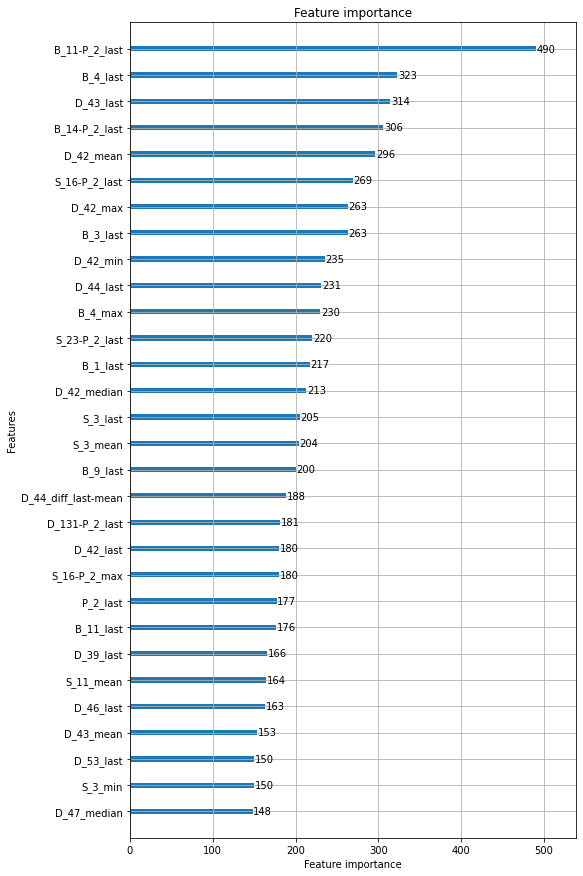

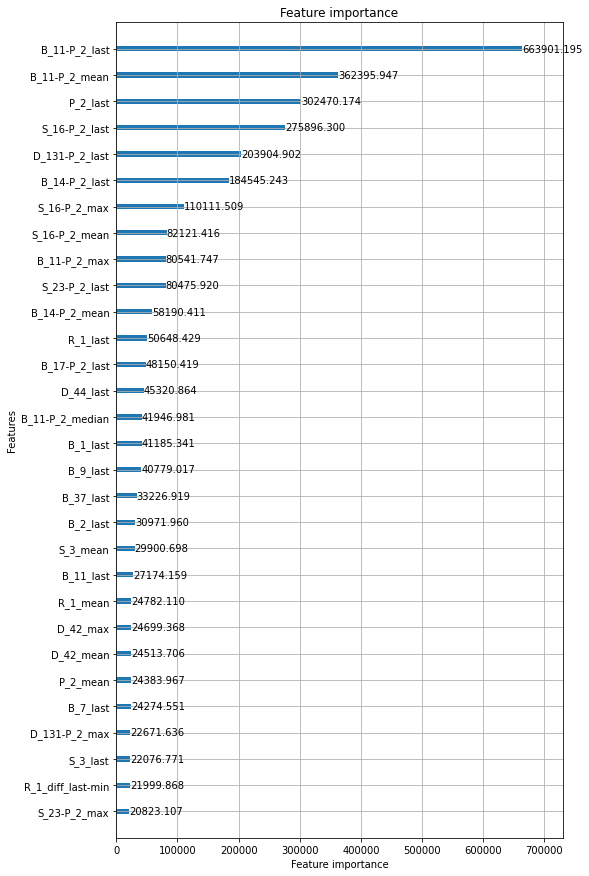

######################################## training model 4/5 ########################################
seed: 18


[50]	valid_0's amex_metric: 0.752486	valid_0's recall_at4: 0.603156	valid_0's norm_gini: 0.901816


[100]	valid_0's amex_metric: 0.766157	valid_0's recall_at4: 0.623269	valid_0's norm_gini: 0.909044


[150]	valid_0's amex_metric: 0.771213	valid_0's recall_at4: 0.630844	valid_0's norm_gini: 0.911581


[200]	valid_0's amex_metric: 0.775289	valid_0's recall_at4: 0.636314	valid_0's norm_gini: 0.914263


[250]	valid_0's amex_metric: 0.779281	valid_0's recall_at4: 0.642247	valid_0's norm_gini: 0.916315


[300]	valid_0's amex_metric: 0.781331	valid_0's recall_at4: 0.645361	valid_0's norm_gini: 0.917302


[350]	valid_0's amex_metric: 0.783312	valid_0's recall_at4: 0.648348	valid_0's norm_gini: 0.918277


[400]	valid_0's amex_metric: 0.786023	valid_0's recall_at4: 0.652767	valid_0's norm_gini: 0.91928


[450]	valid_0's amex_metric: 0.786869	valid_0's recall_at4: 0.653735	valid_0's norm_gini: 0.920003


[500]	valid_0's amex_metric: 0.788174	valid_0's recall_at4: 0.655544	valid_0's norm_gini: 0.920805


[550]	valid_0's amex_metric: 0.789514	valid_0's recall_at4: 0.657774	valid_0's norm_gini: 0.921254


[600]	valid_0's amex_metric: 0.790384	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.921648


[650]	valid_0's amex_metric: 0.791487	valid_0's recall_at4: 0.660972	valid_0's norm_gini: 0.922001


[700]	valid_0's amex_metric: 0.791571	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.922338


[750]	valid_0's amex_metric: 0.792005	valid_0's recall_at4: 0.661351	valid_0's norm_gini: 0.92266


[800]	valid_0's amex_metric: 0.792647	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.923017


[850]	valid_0's amex_metric: 0.793378	valid_0's recall_at4: 0.663497	valid_0's norm_gini: 0.923259


[900]	valid_0's amex_metric: 0.794118	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.923476


[950]	valid_0's amex_metric: 0.794403	valid_0's recall_at4: 0.665138	valid_0's norm_gini: 0.923669


[1000]	valid_0's amex_metric: 0.794121	valid_0's recall_at4: 0.66438	valid_0's norm_gini: 0.923862


[1050]	valid_0's amex_metric: 0.794829	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924015


[1100]	valid_0's amex_metric: 0.795298	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.924197


[1150]	valid_0's amex_metric: 0.795836	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.924345


[1200]	valid_0's amex_metric: 0.795772	valid_0's recall_at4: 0.667073	valid_0's norm_gini: 0.924471


[1250]	valid_0's amex_metric: 0.795695	valid_0's recall_at4: 0.666779	valid_0's norm_gini: 0.924611


[1300]	valid_0's amex_metric: 0.796062	valid_0's recall_at4: 0.66741	valid_0's norm_gini: 0.924713


[1350]	valid_0's amex_metric: 0.79603	valid_0's recall_at4: 0.667284	valid_0's norm_gini: 0.924776


[1400]	valid_0's amex_metric: 0.796097	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.924869


[1450]	valid_0's amex_metric: 0.796191	valid_0's recall_at4: 0.667452	valid_0's norm_gini: 0.92493


[1500]	valid_0's amex_metric: 0.795644	valid_0's recall_at4: 0.666274	valid_0's norm_gini: 0.925013


[1550]	valid_0's amex_metric: 0.796031	valid_0's recall_at4: 0.666989	valid_0's norm_gini: 0.925073


[1600]	valid_0's amex_metric: 0.796334	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.925131


[1650]	valid_0's amex_metric: 0.796721	valid_0's recall_at4: 0.668252	valid_0's norm_gini: 0.925191


[1700]	valid_0's amex_metric: 0.797099	valid_0's recall_at4: 0.668925	valid_0's norm_gini: 0.925273


[1750]	valid_0's amex_metric: 0.797185	valid_0's recall_at4: 0.669051	valid_0's norm_gini: 0.925319


[1800]	valid_0's amex_metric: 0.797433	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.925394


[1850]	valid_0's amex_metric: 0.797318	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925416


[1900]	valid_0's amex_metric: 0.797329	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925438


[1950]	valid_0's amex_metric: 0.797223	valid_0's recall_at4: 0.668967	valid_0's norm_gini: 0.925479


[2000]	valid_0's amex_metric: 0.797409	valid_0's recall_at4: 0.669262	valid_0's norm_gini: 0.925557


[2050]	valid_0's amex_metric: 0.797818	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.925617


[2100]	valid_0's amex_metric: 0.797543	valid_0's recall_at4: 0.66943	valid_0's norm_gini: 0.925657


[2150]	valid_0's amex_metric: 0.797621	valid_0's recall_at4: 0.669556	valid_0's norm_gini: 0.925686


[2200]	valid_0's amex_metric: 0.797598	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.925723


[2250]	valid_0's amex_metric: 0.797775	valid_0's recall_at4: 0.669809	valid_0's norm_gini: 0.925741


[2300]	valid_0's amex_metric: 0.797482	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925744


[2350]	valid_0's amex_metric: 0.797728	valid_0's recall_at4: 0.669682	valid_0's norm_gini: 0.925775


[2400]	valid_0's amex_metric: 0.797874	valid_0's recall_at4: 0.669935	valid_0's norm_gini: 0.925813


[2450]	valid_0's amex_metric: 0.798002	valid_0's recall_at4: 0.670187	valid_0's norm_gini: 0.925816


[2500]	valid_0's amex_metric: 0.797528	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925836


[2550]	valid_0's amex_metric: 0.797972	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.92584


[2600]	valid_0's amex_metric: 0.798399	valid_0's recall_at4: 0.670945	valid_0's norm_gini: 0.925854


[2650]	valid_0's amex_metric: 0.798681	valid_0's recall_at4: 0.671492	valid_0's norm_gini: 0.925871


[2700]	valid_0's amex_metric: 0.798481	valid_0's recall_at4: 0.671071	valid_0's norm_gini: 0.92589


[2750]	valid_0's amex_metric: 0.798099	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.925884


[2800]	valid_0's amex_metric: 0.798315	valid_0's recall_at4: 0.670734	valid_0's norm_gini: 0.925896


[2850]	valid_0's amex_metric: 0.798603	valid_0's recall_at4: 0.671281	valid_0's norm_gini: 0.925925


[2900]	valid_0's amex_metric: 0.798131	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.925949


[2950]	valid_0's amex_metric: 0.798831	valid_0's recall_at4: 0.671702	valid_0's norm_gini: 0.92596


[3000]	valid_0's amex_metric: 0.79785	valid_0's recall_at4: 0.669724	valid_0's norm_gini: 0.925975


[3050]	valid_0's amex_metric: 0.798483	valid_0's recall_at4: 0.670987	valid_0's norm_gini: 0.925978


[3100]	valid_0's amex_metric: 0.798849	valid_0's recall_at4: 0.671702	valid_0's norm_gini: 0.925997


[3150]	valid_0's amex_metric: 0.797752	valid_0's recall_at4: 0.669514	valid_0's norm_gini: 0.92599


[3200]	valid_0's amex_metric: 0.798351	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.92601


[3250]	valid_0's amex_metric: 0.798356	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.92602


[3300]	valid_0's amex_metric: 0.798452	valid_0's recall_at4: 0.670861	valid_0's norm_gini: 0.926043


[3350]	valid_0's amex_metric: 0.798693	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.926062


[3400]	valid_0's amex_metric: 0.79825	valid_0's recall_at4: 0.67044	valid_0's norm_gini: 0.926059


[3450]	valid_0's amex_metric: 0.798457	valid_0's recall_at4: 0.670861	valid_0's norm_gini: 0.926054


[3500]	valid_0's amex_metric: 0.798422	valid_0's recall_at4: 0.670776	valid_0's norm_gini: 0.926067


[3550]	valid_0's amex_metric: 0.798417	valid_0's recall_at4: 0.670776	valid_0's norm_gini: 0.926058


[3600]	valid_0's amex_metric: 0.798793	valid_0's recall_at4: 0.671534	valid_0's norm_gini: 0.926052


[3650]	valid_0's amex_metric: 0.79849	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.926077


[3700]	valid_0's amex_metric: 0.798621	valid_0's recall_at4: 0.671155	valid_0's norm_gini: 0.926087


[3750]	valid_0's amex_metric: 0.79841	valid_0's recall_at4: 0.670734	valid_0's norm_gini: 0.926086


[3800]	valid_0's amex_metric: 0.798215	valid_0's recall_at4: 0.670356	valid_0's norm_gini: 0.926075


[3850]	valid_0's amex_metric: 0.797951	valid_0's recall_at4: 0.669809	valid_0's norm_gini: 0.926094


[3900]	valid_0's amex_metric: 0.798303	valid_0's recall_at4: 0.670524	valid_0's norm_gini: 0.926082


[3950]	valid_0's amex_metric: 0.798466	valid_0's recall_at4: 0.670818	valid_0's norm_gini: 0.926113


[4000]	valid_0's amex_metric: 0.798513	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.926124


[4050]	valid_0's amex_metric: 0.798843	valid_0's recall_at4: 0.671534	valid_0's norm_gini: 0.926153


[4100]	valid_0's amex_metric: 0.798877	valid_0's recall_at4: 0.671576	valid_0's norm_gini: 0.926178


[4150]	valid_0's amex_metric: 0.798841	valid_0's recall_at4: 0.671492	valid_0's norm_gini: 0.926189


[4200]	valid_0's amex_metric: 0.799133	valid_0's recall_at4: 0.672081	valid_0's norm_gini: 0.926186


[4250]	valid_0's amex_metric: 0.798839	valid_0's recall_at4: 0.671492	valid_0's norm_gini: 0.926186


[4300]	valid_0's amex_metric: 0.798779	valid_0's recall_at4: 0.671365	valid_0's norm_gini: 0.926192


[4350]	valid_0's amex_metric: 0.798796	valid_0's recall_at4: 0.671408	valid_0's norm_gini: 0.926184


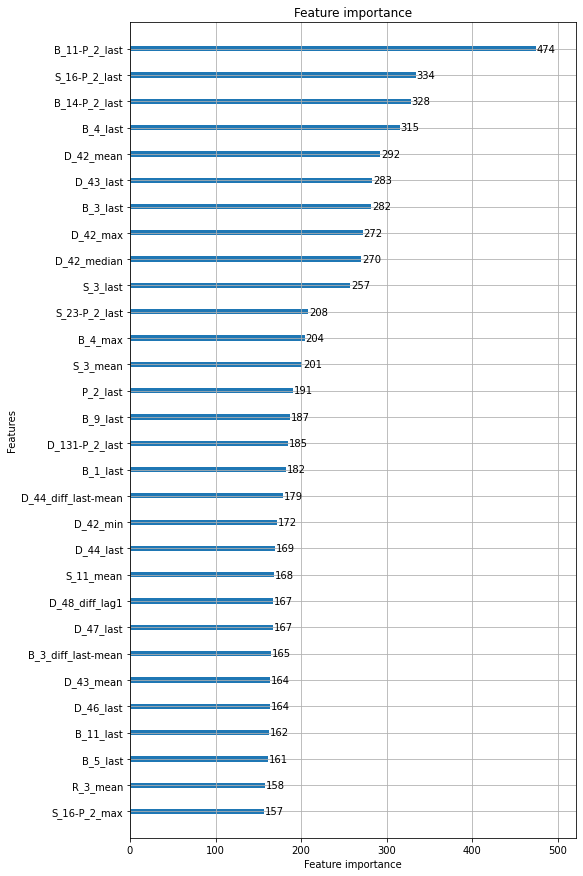

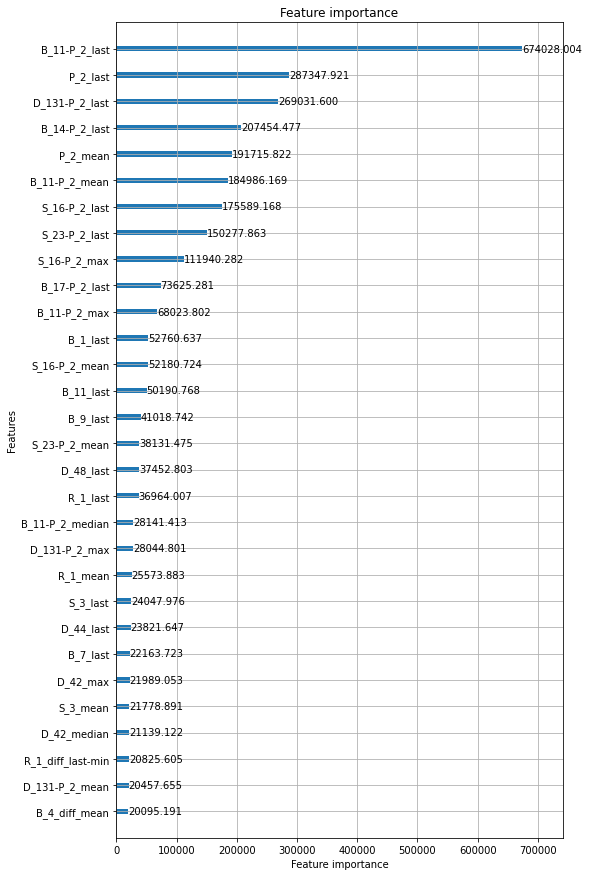

######################################## training model 5/5 ########################################
seed: 19


[50]	valid_0's amex_metric: 0.752582	valid_0's recall_at4: 0.60446	valid_0's norm_gini: 0.900704


[100]	valid_0's amex_metric: 0.760855	valid_0's recall_at4: 0.615527	valid_0's norm_gini: 0.906183


[150]	valid_0's amex_metric: 0.767699	valid_0's recall_at4: 0.625121	valid_0's norm_gini: 0.910276


[200]	valid_0's amex_metric: 0.772741	valid_0's recall_at4: 0.632064	valid_0's norm_gini: 0.913418


[250]	valid_0's amex_metric: 0.777216	valid_0's recall_at4: 0.638923	valid_0's norm_gini: 0.915508


[300]	valid_0's amex_metric: 0.779809	valid_0's recall_at4: 0.642626	valid_0's norm_gini: 0.916992


[350]	valid_0's amex_metric: 0.782412	valid_0's recall_at4: 0.646792	valid_0's norm_gini: 0.918032


[400]	valid_0's amex_metric: 0.784165	valid_0's recall_at4: 0.649232	valid_0's norm_gini: 0.919099


[450]	valid_0's amex_metric: 0.786096	valid_0's recall_at4: 0.65243	valid_0's norm_gini: 0.919762


[500]	valid_0's amex_metric: 0.78673	valid_0's recall_at4: 0.652977	valid_0's norm_gini: 0.920484


[550]	valid_0's amex_metric: 0.788072	valid_0's recall_at4: 0.655207	valid_0's norm_gini: 0.920937


[600]	valid_0's amex_metric: 0.788561	valid_0's recall_at4: 0.655838	valid_0's norm_gini: 0.921283


[650]	valid_0's amex_metric: 0.788736	valid_0's recall_at4: 0.655881	valid_0's norm_gini: 0.921591


[700]	valid_0's amex_metric: 0.78928	valid_0's recall_at4: 0.656764	valid_0's norm_gini: 0.921796


[750]	valid_0's amex_metric: 0.789661	valid_0's recall_at4: 0.657353	valid_0's norm_gini: 0.921969


[800]	valid_0's amex_metric: 0.789775	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.922112


[850]	valid_0's amex_metric: 0.789931	valid_0's recall_at4: 0.657564	valid_0's norm_gini: 0.922299


[900]	valid_0's amex_metric: 0.790349	valid_0's recall_at4: 0.658237	valid_0's norm_gini: 0.92246


[950]	valid_0's amex_metric: 0.790744	valid_0's recall_at4: 0.658784	valid_0's norm_gini: 0.922704


[1000]	valid_0's amex_metric: 0.791179	valid_0's recall_at4: 0.659457	valid_0's norm_gini: 0.922901


[1050]	valid_0's amex_metric: 0.792389	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.923134


[1100]	valid_0's amex_metric: 0.79249	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.923335


[1150]	valid_0's amex_metric: 0.792921	valid_0's recall_at4: 0.662319	valid_0's norm_gini: 0.923524


[1200]	valid_0's amex_metric: 0.792901	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.923652


[1250]	valid_0's amex_metric: 0.793241	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.923743


[1300]	valid_0's amex_metric: 0.792872	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.923846


[1350]	valid_0's amex_metric: 0.793119	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.923962


[1400]	valid_0's amex_metric: 0.793711	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924093


[1450]	valid_0's amex_metric: 0.793445	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.924193


[1500]	valid_0's amex_metric: 0.793623	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.924295


[1550]	valid_0's amex_metric: 0.79378	valid_0's recall_at4: 0.66316	valid_0's norm_gini: 0.924399


[1600]	valid_0's amex_metric: 0.794167	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.924459


[1650]	valid_0's amex_metric: 0.794023	valid_0's recall_at4: 0.663539	valid_0's norm_gini: 0.924507


[1700]	valid_0's amex_metric: 0.794281	valid_0's recall_at4: 0.664002	valid_0's norm_gini: 0.92456


[1750]	valid_0's amex_metric: 0.794166	valid_0's recall_at4: 0.663707	valid_0's norm_gini: 0.924625


[1800]	valid_0's amex_metric: 0.794437	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.924661


[1850]	valid_0's amex_metric: 0.794446	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924722


[1900]	valid_0's amex_metric: 0.794558	valid_0's recall_at4: 0.664338	valid_0's norm_gini: 0.924778


[1950]	valid_0's amex_metric: 0.794132	valid_0's recall_at4: 0.663455	valid_0's norm_gini: 0.924808


[2000]	valid_0's amex_metric: 0.794228	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.924832


[2050]	valid_0's amex_metric: 0.794194	valid_0's recall_at4: 0.663497	valid_0's norm_gini: 0.924891


[2100]	valid_0's amex_metric: 0.794543	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924916


[2150]	valid_0's amex_metric: 0.794991	valid_0's recall_at4: 0.665054	valid_0's norm_gini: 0.924929


[2200]	valid_0's amex_metric: 0.794572	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924974


[2250]	valid_0's amex_metric: 0.794908	valid_0's recall_at4: 0.664843	valid_0's norm_gini: 0.924972


[2300]	valid_0's amex_metric: 0.794853	valid_0's recall_at4: 0.664717	valid_0's norm_gini: 0.924988


[2350]	valid_0's amex_metric: 0.795206	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.925022


[2400]	valid_0's amex_metric: 0.795525	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.92507


[2450]	valid_0's amex_metric: 0.795948	valid_0's recall_at4: 0.666821	valid_0's norm_gini: 0.925076


[2500]	valid_0's amex_metric: 0.795165	valid_0's recall_at4: 0.665222	valid_0's norm_gini: 0.925108


[2550]	valid_0's amex_metric: 0.795402	valid_0's recall_at4: 0.665685	valid_0's norm_gini: 0.925118


[2600]	valid_0's amex_metric: 0.795509	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.925122


[2650]	valid_0's amex_metric: 0.795505	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.925157


[2700]	valid_0's amex_metric: 0.795467	valid_0's recall_at4: 0.665769	valid_0's norm_gini: 0.925165


[2750]	valid_0's amex_metric: 0.795621	valid_0's recall_at4: 0.666064	valid_0's norm_gini: 0.925178


[2800]	valid_0's amex_metric: 0.795239	valid_0's recall_at4: 0.665306	valid_0's norm_gini: 0.925172


[2850]	valid_0's amex_metric: 0.795498	valid_0's recall_at4: 0.665811	valid_0's norm_gini: 0.925184


[2900]	valid_0's amex_metric: 0.795569	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.925242


[2950]	valid_0's amex_metric: 0.79532	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.925249


[3000]	valid_0's amex_metric: 0.795342	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.925252


[3050]	valid_0's amex_metric: 0.795456	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.92527


[3100]	valid_0's amex_metric: 0.795627	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.925275


[3150]	valid_0's amex_metric: 0.795491	valid_0's recall_at4: 0.665685	valid_0's norm_gini: 0.925296


[3200]	valid_0's amex_metric: 0.795376	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.92532


[3250]	valid_0's amex_metric: 0.795446	valid_0's recall_at4: 0.665559	valid_0's norm_gini: 0.925333


[3300]	valid_0's amex_metric: 0.795784	valid_0's recall_at4: 0.666232	valid_0's norm_gini: 0.925337


[3350]	valid_0's amex_metric: 0.79581	valid_0's recall_at4: 0.666274	valid_0's norm_gini: 0.925345


[3400]	valid_0's amex_metric: 0.796172	valid_0's recall_at4: 0.666989	valid_0's norm_gini: 0.925355


[3450]	valid_0's amex_metric: 0.795733	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.925359


[3500]	valid_0's amex_metric: 0.7956	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.925347


[3550]	valid_0's amex_metric: 0.795911	valid_0's recall_at4: 0.666442	valid_0's norm_gini: 0.925379


[3600]	valid_0's amex_metric: 0.795644	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.925393


[3650]	valid_0's amex_metric: 0.795931	valid_0's recall_at4: 0.666442	valid_0's norm_gini: 0.92542


[3700]	valid_0's amex_metric: 0.796059	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.925424


[3750]	valid_0's amex_metric: 0.795975	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.925424


[3800]	valid_0's amex_metric: 0.795774	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.925442


[3850]	valid_0's amex_metric: 0.795902	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.925446


[3900]	valid_0's amex_metric: 0.795802	valid_0's recall_at4: 0.666148	valid_0's norm_gini: 0.925456


[3950]	valid_0's amex_metric: 0.795846	valid_0's recall_at4: 0.666232	valid_0's norm_gini: 0.92546


[4000]	valid_0's amex_metric: 0.795835	valid_0's recall_at4: 0.66619	valid_0's norm_gini: 0.92548


[4050]	valid_0's amex_metric: 0.795541	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.925482


[4100]	valid_0's amex_metric: 0.795478	valid_0's recall_at4: 0.665474	valid_0's norm_gini: 0.925481


[4150]	valid_0's amex_metric: 0.795704	valid_0's recall_at4: 0.665937	valid_0's norm_gini: 0.925471


[4200]	valid_0's amex_metric: 0.795304	valid_0's recall_at4: 0.665138	valid_0's norm_gini: 0.92547


[4250]	valid_0's amex_metric: 0.795491	valid_0's recall_at4: 0.665516	valid_0's norm_gini: 0.925466


[4300]	valid_0's amex_metric: 0.795548	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.925452


[4350]	valid_0's amex_metric: 0.795398	valid_0's recall_at4: 0.665348	valid_0's norm_gini: 0.925448


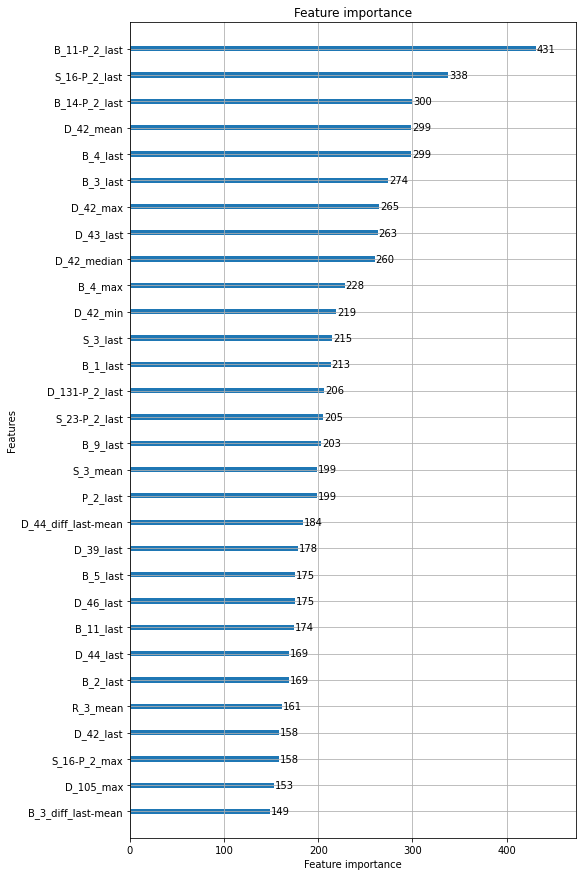

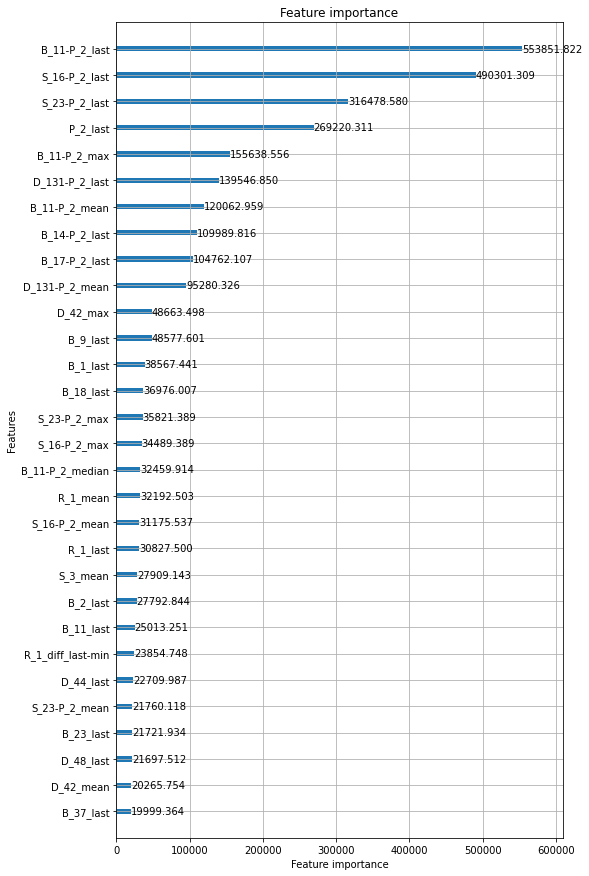

Training time: 39.09614608685175 min.
OOF recall_at4: 0.6703723028242502
OOF normalized_gini: 0.9259906146557065
OOF competition metric: 0.7981814587399784


############################### repeated cross-validation step: 5/5 ################################


######################################## training model 1/5 ########################################
seed: 20


[50]	valid_0's amex_metric: 0.749671	valid_0's recall_at4: 0.59968	valid_0's norm_gini: 0.899663


[100]	valid_0's amex_metric: 0.759195	valid_0's recall_at4: 0.613019	valid_0's norm_gini: 0.90537


[150]	valid_0's amex_metric: 0.764249	valid_0's recall_at4: 0.620003	valid_0's norm_gini: 0.908495


[200]	valid_0's amex_metric: 0.767763	valid_0's recall_at4: 0.624842	valid_0's norm_gini: 0.910683


[250]	valid_0's amex_metric: 0.773365	valid_0's recall_at4: 0.633089	valid_0's norm_gini: 0.91364


[300]	valid_0's amex_metric: 0.778082	valid_0's recall_at4: 0.640242	valid_0's norm_gini: 0.915921


[350]	valid_0's amex_metric: 0.781436	valid_0's recall_at4: 0.645544	valid_0's norm_gini: 0.917328


[400]	valid_0's amex_metric: 0.784084	valid_0's recall_at4: 0.649289	valid_0's norm_gini: 0.918878


[450]	valid_0's amex_metric: 0.786238	valid_0's recall_at4: 0.652781	valid_0's norm_gini: 0.919694


[500]	valid_0's amex_metric: 0.788601	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.920676


[550]	valid_0's amex_metric: 0.789513	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.921279


[600]	valid_0's amex_metric: 0.790963	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.921949


[650]	valid_0's amex_metric: 0.791426	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.922244


[700]	valid_0's amex_metric: 0.792422	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.922554


[750]	valid_0's amex_metric: 0.793583	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.922898


[800]	valid_0's amex_metric: 0.794584	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.923216


[850]	valid_0's amex_metric: 0.794653	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.923523


[900]	valid_0's amex_metric: 0.795178	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.923774


[950]	valid_0's amex_metric: 0.795575	valid_0's recall_at4: 0.667172	valid_0's norm_gini: 0.923978


[1000]	valid_0's amex_metric: 0.796455	valid_0's recall_at4: 0.668728	valid_0's norm_gini: 0.924182


[1050]	valid_0's amex_metric: 0.796946	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.924365


[1100]	valid_0's amex_metric: 0.797242	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.924536


[1150]	valid_0's amex_metric: 0.797164	valid_0's recall_at4: 0.669654	valid_0's norm_gini: 0.924675


[1200]	valid_0's amex_metric: 0.797676	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.924856


[1250]	valid_0's amex_metric: 0.79813	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.925007


[1300]	valid_0's amex_metric: 0.798213	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.925089


[1350]	valid_0's amex_metric: 0.798415	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.925199


[1400]	valid_0's amex_metric: 0.798503	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925291


[1450]	valid_0's amex_metric: 0.798506	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.925381


[1500]	valid_0's amex_metric: 0.799194	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.925493


[1550]	valid_0's amex_metric: 0.798915	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.925567


[1600]	valid_0's amex_metric: 0.799086	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.925656


[1650]	valid_0's amex_metric: 0.799503	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.925732


[1700]	valid_0's amex_metric: 0.799222	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.925801


[1750]	valid_0's amex_metric: 0.79923	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.925861


[1800]	valid_0's amex_metric: 0.79897	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.925929


[1850]	valid_0's amex_metric: 0.799132	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.92596


[1900]	valid_0's amex_metric: 0.799614	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.925997


[1950]	valid_0's amex_metric: 0.799127	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926034


[2000]	valid_0's amex_metric: 0.799308	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926059


[2050]	valid_0's amex_metric: 0.799857	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.926062


[2100]	valid_0's amex_metric: 0.799968	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.926117


[2150]	valid_0's amex_metric: 0.800189	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926137


[2200]	valid_0's amex_metric: 0.799947	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.926158


[2250]	valid_0's amex_metric: 0.800388	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.926199


[2300]	valid_0's amex_metric: 0.799863	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.926242


[2350]	valid_0's amex_metric: 0.800192	valid_0's recall_at4: 0.674114	valid_0's norm_gini: 0.92627


[2400]	valid_0's amex_metric: 0.800225	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926293


[2450]	valid_0's amex_metric: 0.800293	valid_0's recall_at4: 0.674283	valid_0's norm_gini: 0.926303


[2500]	valid_0's amex_metric: 0.800277	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926313


[2550]	valid_0's amex_metric: 0.799852	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926305


[2600]	valid_0's amex_metric: 0.800289	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926338


[2650]	valid_0's amex_metric: 0.800405	valid_0's recall_at4: 0.674451	valid_0's norm_gini: 0.926358


[2700]	valid_0's amex_metric: 0.800127	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.926392


[2750]	valid_0's amex_metric: 0.800322	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926403


[2800]	valid_0's amex_metric: 0.800046	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.926398


[2850]	valid_0's amex_metric: 0.800537	valid_0's recall_at4: 0.674703	valid_0's norm_gini: 0.92637


[2900]	valid_0's amex_metric: 0.800323	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926405


[2950]	valid_0's amex_metric: 0.800418	valid_0's recall_at4: 0.674409	valid_0's norm_gini: 0.926426


[3000]	valid_0's amex_metric: 0.80043	valid_0's recall_at4: 0.674409	valid_0's norm_gini: 0.926452


[3050]	valid_0's amex_metric: 0.800476	valid_0's recall_at4: 0.674493	valid_0's norm_gini: 0.926458


[3100]	valid_0's amex_metric: 0.80073	valid_0's recall_at4: 0.674998	valid_0's norm_gini: 0.926462


[3150]	valid_0's amex_metric: 0.800816	valid_0's recall_at4: 0.675166	valid_0's norm_gini: 0.926465


[3200]	valid_0's amex_metric: 0.800875	valid_0's recall_at4: 0.675292	valid_0's norm_gini: 0.926457


[3250]	valid_0's amex_metric: 0.800624	valid_0's recall_at4: 0.674788	valid_0's norm_gini: 0.92646


[3300]	valid_0's amex_metric: 0.800715	valid_0's recall_at4: 0.674956	valid_0's norm_gini: 0.926474


[3350]	valid_0's amex_metric: 0.800977	valid_0's recall_at4: 0.675461	valid_0's norm_gini: 0.926493


[3400]	valid_0's amex_metric: 0.801199	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926475


[3450]	valid_0's amex_metric: 0.80107	valid_0's recall_at4: 0.675671	valid_0's norm_gini: 0.926469


[3500]	valid_0's amex_metric: 0.801031	valid_0's recall_at4: 0.675587	valid_0's norm_gini: 0.926476


[3550]	valid_0's amex_metric: 0.801318	valid_0's recall_at4: 0.676134	valid_0's norm_gini: 0.926502


[3600]	valid_0's amex_metric: 0.80052	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.926505


[3650]	valid_0's amex_metric: 0.800491	valid_0's recall_at4: 0.674493	valid_0's norm_gini: 0.926489


[3700]	valid_0's amex_metric: 0.801085	valid_0's recall_at4: 0.675671	valid_0's norm_gini: 0.9265


[3750]	valid_0's amex_metric: 0.800836	valid_0's recall_at4: 0.675166	valid_0's norm_gini: 0.926506


[3800]	valid_0's amex_metric: 0.801191	valid_0's recall_at4: 0.675882	valid_0's norm_gini: 0.9265


[3850]	valid_0's amex_metric: 0.80062	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.926495


[3900]	valid_0's amex_metric: 0.800961	valid_0's recall_at4: 0.675419	valid_0's norm_gini: 0.926504


[3950]	valid_0's amex_metric: 0.800453	valid_0's recall_at4: 0.674409	valid_0's norm_gini: 0.926498


[4000]	valid_0's amex_metric: 0.800374	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926507


[4050]	valid_0's amex_metric: 0.80056	valid_0's recall_at4: 0.674619	valid_0's norm_gini: 0.926502


[4100]	valid_0's amex_metric: 0.800983	valid_0's recall_at4: 0.675461	valid_0's norm_gini: 0.926506


[4150]	valid_0's amex_metric: 0.801411	valid_0's recall_at4: 0.676302	valid_0's norm_gini: 0.92652


[4200]	valid_0's amex_metric: 0.801221	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926519


[4250]	valid_0's amex_metric: 0.801607	valid_0's recall_at4: 0.676681	valid_0's norm_gini: 0.926534


[4300]	valid_0's amex_metric: 0.801152	valid_0's recall_at4: 0.675755	valid_0's norm_gini: 0.926548


[4350]	valid_0's amex_metric: 0.801463	valid_0's recall_at4: 0.676386	valid_0's norm_gini: 0.92654


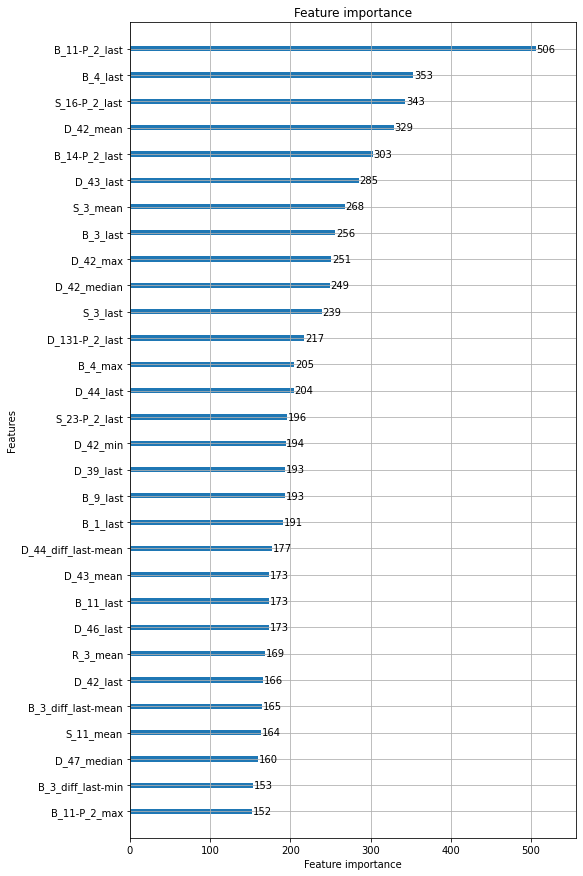

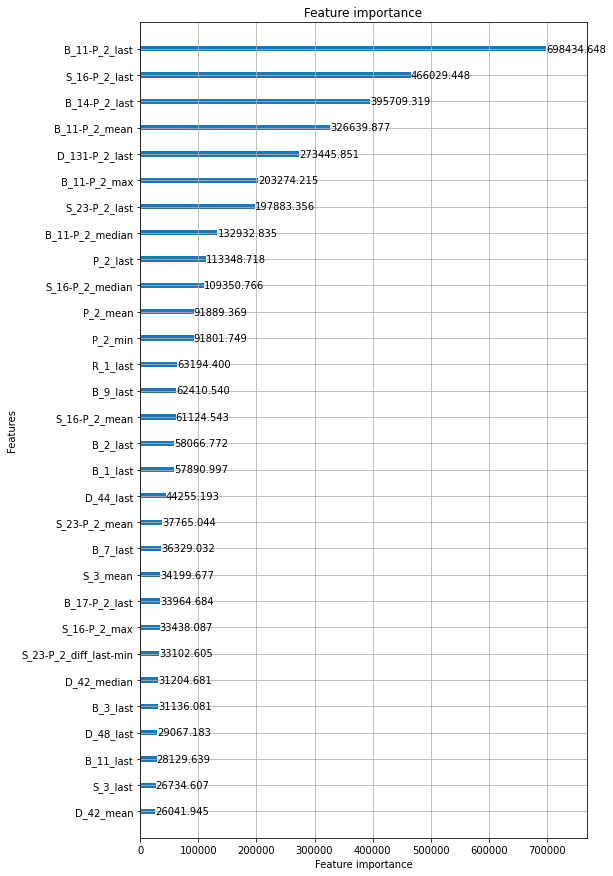

######################################## training model 2/5 ########################################
seed: 21


[50]	valid_0's amex_metric: 0.753575	valid_0's recall_at4: 0.606623	valid_0's norm_gini: 0.900528


[100]	valid_0's amex_metric: 0.768707	valid_0's recall_at4: 0.62825	valid_0's norm_gini: 0.909164


[150]	valid_0's amex_metric: 0.774213	valid_0's recall_at4: 0.636245	valid_0's norm_gini: 0.912181


[200]	valid_0's amex_metric: 0.779508	valid_0's recall_at4: 0.643693	valid_0's norm_gini: 0.915324


[250]	valid_0's amex_metric: 0.782599	valid_0's recall_at4: 0.648027	valid_0's norm_gini: 0.917172


[300]	valid_0's amex_metric: 0.78551	valid_0's recall_at4: 0.651603	valid_0's norm_gini: 0.919417


[350]	valid_0's amex_metric: 0.78791	valid_0's recall_at4: 0.655558	valid_0's norm_gini: 0.920262


[400]	valid_0's amex_metric: 0.789671	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.921091


[450]	valid_0's amex_metric: 0.790486	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.921963


[500]	valid_0's amex_metric: 0.792068	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.922687


[550]	valid_0's amex_metric: 0.793336	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.923329


[600]	valid_0's amex_metric: 0.793121	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.923784


[650]	valid_0's amex_metric: 0.79383	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.924275


[700]	valid_0's amex_metric: 0.794098	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.924558


[750]	valid_0's amex_metric: 0.794679	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.924837


[800]	valid_0's amex_metric: 0.795276	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.925022


[850]	valid_0's amex_metric: 0.79612	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.925236


[900]	valid_0's amex_metric: 0.796162	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.925406


[950]	valid_0's amex_metric: 0.796673	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.925585


[1000]	valid_0's amex_metric: 0.796272	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.925793


[1050]	valid_0's amex_metric: 0.796824	valid_0's recall_at4: 0.667719	valid_0's norm_gini: 0.925929


[1100]	valid_0's amex_metric: 0.797387	valid_0's recall_at4: 0.668686	valid_0's norm_gini: 0.926087


[1150]	valid_0's amex_metric: 0.79798	valid_0's recall_at4: 0.66978	valid_0's norm_gini: 0.926181


[1200]	valid_0's amex_metric: 0.797793	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.926311


[1250]	valid_0's amex_metric: 0.798222	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.926412


[1300]	valid_0's amex_metric: 0.798149	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.926475


[1350]	valid_0's amex_metric: 0.798476	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.926541


[1400]	valid_0's amex_metric: 0.798501	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.92659


[1450]	valid_0's amex_metric: 0.798759	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926644


[1500]	valid_0's amex_metric: 0.798304	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.926702


[1550]	valid_0's amex_metric: 0.798963	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.926758


[1600]	valid_0's amex_metric: 0.799494	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926851


[1650]	valid_0's amex_metric: 0.799603	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926901


[1700]	valid_0's amex_metric: 0.799568	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926957


[1750]	valid_0's amex_metric: 0.800068	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.927032


[1800]	valid_0's amex_metric: 0.800159	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.927088


[1850]	valid_0's amex_metric: 0.800144	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.927142


[1900]	valid_0's amex_metric: 0.800531	valid_0's recall_at4: 0.673904	valid_0's norm_gini: 0.927159


[1950]	valid_0's amex_metric: 0.801038	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.927204


[2000]	valid_0's amex_metric: 0.801284	valid_0's recall_at4: 0.675335	valid_0's norm_gini: 0.927234


[2050]	valid_0's amex_metric: 0.801209	valid_0's recall_at4: 0.675166	valid_0's norm_gini: 0.927251


[2100]	valid_0's amex_metric: 0.801311	valid_0's recall_at4: 0.675335	valid_0's norm_gini: 0.927288


[2150]	valid_0's amex_metric: 0.801203	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.927324


[2200]	valid_0's amex_metric: 0.801596	valid_0's recall_at4: 0.675839	valid_0's norm_gini: 0.927352


[2250]	valid_0's amex_metric: 0.801781	valid_0's recall_at4: 0.676176	valid_0's norm_gini: 0.927387


[2300]	valid_0's amex_metric: 0.801596	valid_0's recall_at4: 0.675797	valid_0's norm_gini: 0.927395


[2350]	valid_0's amex_metric: 0.801756	valid_0's recall_at4: 0.676092	valid_0's norm_gini: 0.92742


[2400]	valid_0's amex_metric: 0.801812	valid_0's recall_at4: 0.676176	valid_0's norm_gini: 0.927448


[2450]	valid_0's amex_metric: 0.80198	valid_0's recall_at4: 0.676471	valid_0's norm_gini: 0.927489


[2500]	valid_0's amex_metric: 0.802107	valid_0's recall_at4: 0.676723	valid_0's norm_gini: 0.927491


[2550]	valid_0's amex_metric: 0.80178	valid_0's recall_at4: 0.67605	valid_0's norm_gini: 0.927511


[2600]	valid_0's amex_metric: 0.801893	valid_0's recall_at4: 0.67626	valid_0's norm_gini: 0.927526


[2650]	valid_0's amex_metric: 0.802401	valid_0's recall_at4: 0.67727	valid_0's norm_gini: 0.927533


[2700]	valid_0's amex_metric: 0.802474	valid_0's recall_at4: 0.677396	valid_0's norm_gini: 0.927553


[2750]	valid_0's amex_metric: 0.802167	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.927568


[2800]	valid_0's amex_metric: 0.802157	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.92755


[2850]	valid_0's amex_metric: 0.802285	valid_0's recall_at4: 0.677018	valid_0's norm_gini: 0.927553


[2900]	valid_0's amex_metric: 0.802168	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.92757


[2950]	valid_0's amex_metric: 0.802038	valid_0's recall_at4: 0.676513	valid_0's norm_gini: 0.927563


[3000]	valid_0's amex_metric: 0.802671	valid_0's recall_at4: 0.677775	valid_0's norm_gini: 0.927566


[3050]	valid_0's amex_metric: 0.802072	valid_0's recall_at4: 0.676555	valid_0's norm_gini: 0.92759


[3100]	valid_0's amex_metric: 0.802209	valid_0's recall_at4: 0.676807	valid_0's norm_gini: 0.927612


[3150]	valid_0's amex_metric: 0.802607	valid_0's recall_at4: 0.677607	valid_0's norm_gini: 0.927607


[3200]	valid_0's amex_metric: 0.802789	valid_0's recall_at4: 0.677985	valid_0's norm_gini: 0.927592


[3250]	valid_0's amex_metric: 0.802792	valid_0's recall_at4: 0.677985	valid_0's norm_gini: 0.927598


[3300]	valid_0's amex_metric: 0.802525	valid_0's recall_at4: 0.677438	valid_0's norm_gini: 0.927612


[3350]	valid_0's amex_metric: 0.802581	valid_0's recall_at4: 0.677523	valid_0's norm_gini: 0.92764


[3400]	valid_0's amex_metric: 0.802381	valid_0's recall_at4: 0.677102	valid_0's norm_gini: 0.92766


[3450]	valid_0's amex_metric: 0.802728	valid_0's recall_at4: 0.677775	valid_0's norm_gini: 0.92768


[3500]	valid_0's amex_metric: 0.802619	valid_0's recall_at4: 0.677565	valid_0's norm_gini: 0.927674


[3550]	valid_0's amex_metric: 0.802269	valid_0's recall_at4: 0.676849	valid_0's norm_gini: 0.927688


[3600]	valid_0's amex_metric: 0.802904	valid_0's recall_at4: 0.678112	valid_0's norm_gini: 0.927696


[3650]	valid_0's amex_metric: 0.802272	valid_0's recall_at4: 0.676849	valid_0's norm_gini: 0.927696


[3700]	valid_0's amex_metric: 0.802125	valid_0's recall_at4: 0.676555	valid_0's norm_gini: 0.927696


[3750]	valid_0's amex_metric: 0.802232	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.927699


[3800]	valid_0's amex_metric: 0.802282	valid_0's recall_at4: 0.676849	valid_0's norm_gini: 0.927716


[3850]	valid_0's amex_metric: 0.801902	valid_0's recall_at4: 0.676092	valid_0's norm_gini: 0.927711


[3900]	valid_0's amex_metric: 0.801707	valid_0's recall_at4: 0.675713	valid_0's norm_gini: 0.927701


[3950]	valid_0's amex_metric: 0.80195	valid_0's recall_at4: 0.676176	valid_0's norm_gini: 0.927724


[4000]	valid_0's amex_metric: 0.802055	valid_0's recall_at4: 0.676386	valid_0's norm_gini: 0.927723


[4050]	valid_0's amex_metric: 0.801778	valid_0's recall_at4: 0.675839	valid_0's norm_gini: 0.927716


[4100]	valid_0's amex_metric: 0.801823	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.927721


[4150]	valid_0's amex_metric: 0.802166	valid_0's recall_at4: 0.676597	valid_0's norm_gini: 0.927735


[4200]	valid_0's amex_metric: 0.802331	valid_0's recall_at4: 0.676933	valid_0's norm_gini: 0.927728


[4250]	valid_0's amex_metric: 0.802225	valid_0's recall_at4: 0.676723	valid_0's norm_gini: 0.927726


[4300]	valid_0's amex_metric: 0.802226	valid_0's recall_at4: 0.676723	valid_0's norm_gini: 0.927729


[4350]	valid_0's amex_metric: 0.801872	valid_0's recall_at4: 0.676008	valid_0's norm_gini: 0.927737


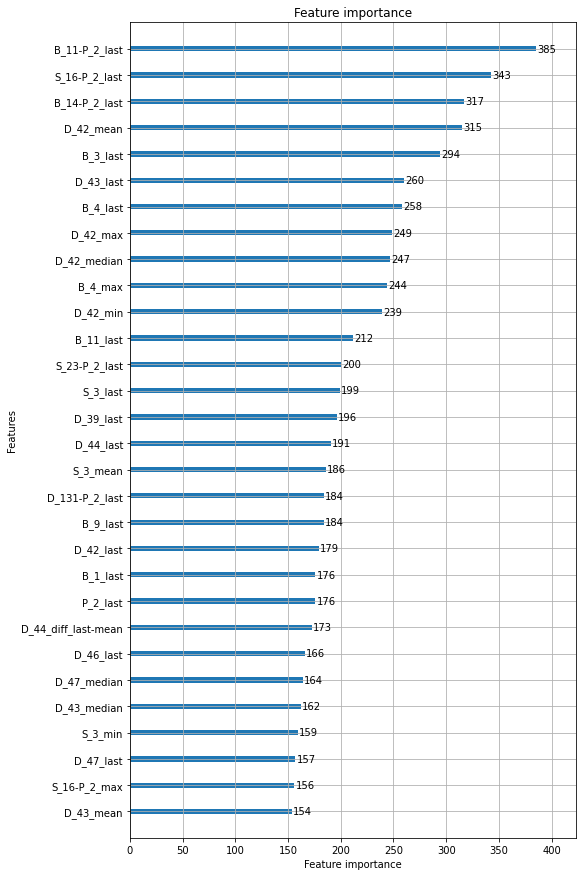

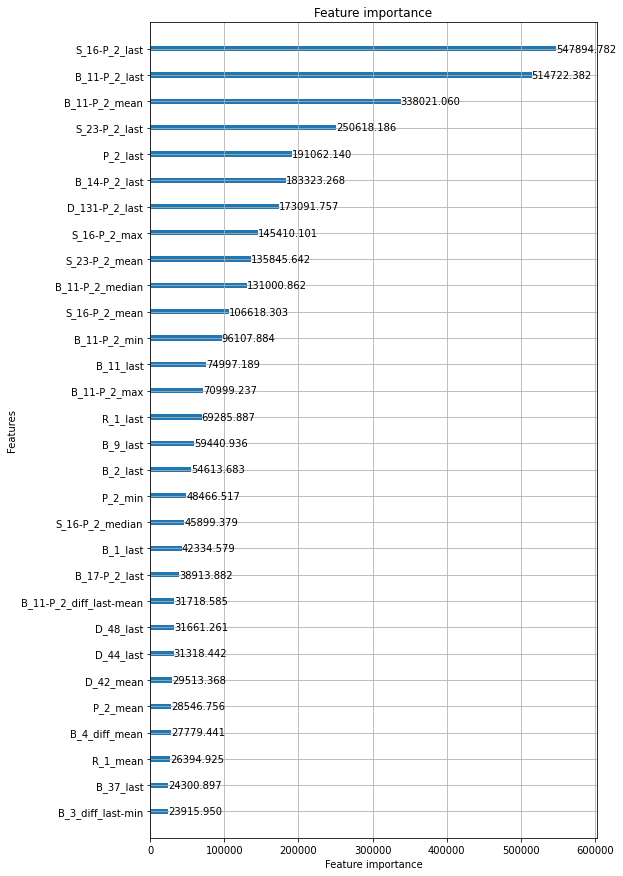

######################################## training model 3/5 ########################################
seed: 22


[50]	valid_0's amex_metric: 0.754648	valid_0's recall_at4: 0.606623	valid_0's norm_gini: 0.902674


[100]	valid_0's amex_metric: 0.761575	valid_0's recall_at4: 0.616343	valid_0's norm_gini: 0.906807


[150]	valid_0's amex_metric: 0.769681	valid_0's recall_at4: 0.628082	valid_0's norm_gini: 0.911281


[200]	valid_0's amex_metric: 0.774374	valid_0's recall_at4: 0.634941	valid_0's norm_gini: 0.913806


[250]	valid_0's amex_metric: 0.777597	valid_0's recall_at4: 0.639359	valid_0's norm_gini: 0.915836


[300]	valid_0's amex_metric: 0.781037	valid_0's recall_at4: 0.644366	valid_0's norm_gini: 0.917709


[350]	valid_0's amex_metric: 0.782534	valid_0's recall_at4: 0.646638	valid_0's norm_gini: 0.91843


[400]	valid_0's amex_metric: 0.783804	valid_0's recall_at4: 0.648153	valid_0's norm_gini: 0.919455


[450]	valid_0's amex_metric: 0.78528	valid_0's recall_at4: 0.650299	valid_0's norm_gini: 0.920261


[500]	valid_0's amex_metric: 0.786077	valid_0's recall_at4: 0.651435	valid_0's norm_gini: 0.920719


[550]	valid_0's amex_metric: 0.787545	valid_0's recall_at4: 0.653833	valid_0's norm_gini: 0.921257


[600]	valid_0's amex_metric: 0.787803	valid_0's recall_at4: 0.653917	valid_0's norm_gini: 0.921689


[650]	valid_0's amex_metric: 0.788635	valid_0's recall_at4: 0.655138	valid_0's norm_gini: 0.922133


[700]	valid_0's amex_metric: 0.789199	valid_0's recall_at4: 0.655937	valid_0's norm_gini: 0.922461


[750]	valid_0's amex_metric: 0.78993	valid_0's recall_at4: 0.657073	valid_0's norm_gini: 0.922787


[800]	valid_0's amex_metric: 0.790024	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.92306


[850]	valid_0's amex_metric: 0.790494	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.923284


[900]	valid_0's amex_metric: 0.790707	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.923456


[950]	valid_0's amex_metric: 0.792224	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923671


[1000]	valid_0's amex_metric: 0.792642	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.923877


[1050]	valid_0's amex_metric: 0.793246	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924032


[1100]	valid_0's amex_metric: 0.793866	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.924179


[1150]	valid_0's amex_metric: 0.794195	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.92429


[1200]	valid_0's amex_metric: 0.794104	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.92436


[1250]	valid_0's amex_metric: 0.794138	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.92447


[1300]	valid_0's amex_metric: 0.794787	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.924548


[1350]	valid_0's amex_metric: 0.794792	valid_0's recall_at4: 0.664941	valid_0's norm_gini: 0.924642


[1400]	valid_0's amex_metric: 0.795193	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.92473


[1450]	valid_0's amex_metric: 0.795395	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.92484


[1500]	valid_0's amex_metric: 0.795318	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.924937


[1550]	valid_0's amex_metric: 0.795299	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.924983


[1600]	valid_0's amex_metric: 0.795646	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.925045


[1650]	valid_0's amex_metric: 0.79588	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.925093


[1700]	valid_0's amex_metric: 0.795992	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.925149


[1750]	valid_0's amex_metric: 0.796369	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.925187


[1800]	valid_0's amex_metric: 0.796227	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.925241


[1850]	valid_0's amex_metric: 0.79664	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.925309


[1900]	valid_0's amex_metric: 0.796336	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.925374


[1950]	valid_0's amex_metric: 0.796443	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.925419


[2000]	valid_0's amex_metric: 0.796229	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.925454


[2050]	valid_0's amex_metric: 0.796103	valid_0's recall_at4: 0.666709	valid_0's norm_gini: 0.925496


[2100]	valid_0's amex_metric: 0.796465	valid_0's recall_at4: 0.667424	valid_0's norm_gini: 0.925507


[2150]	valid_0's amex_metric: 0.796529	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.925549


[2200]	valid_0's amex_metric: 0.796457	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.925574


[2250]	valid_0's amex_metric: 0.796569	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.925588


[2300]	valid_0's amex_metric: 0.796637	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.925597


[2350]	valid_0's amex_metric: 0.796833	valid_0's recall_at4: 0.668055	valid_0's norm_gini: 0.925612


[2400]	valid_0's amex_metric: 0.796712	valid_0's recall_at4: 0.667803	valid_0's norm_gini: 0.92562


[2450]	valid_0's amex_metric: 0.796591	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.925633


[2500]	valid_0's amex_metric: 0.796869	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.92564


[2550]	valid_0's amex_metric: 0.796762	valid_0's recall_at4: 0.667887	valid_0's norm_gini: 0.925638


[2600]	valid_0's amex_metric: 0.796592	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.925634


[2650]	valid_0's amex_metric: 0.796575	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.925641


[2700]	valid_0's amex_metric: 0.796404	valid_0's recall_at4: 0.667172	valid_0's norm_gini: 0.925636


[2750]	valid_0's amex_metric: 0.796074	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.92565


[2800]	valid_0's amex_metric: 0.796121	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.92566


[2850]	valid_0's amex_metric: 0.796583	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.925657


[2900]	valid_0's amex_metric: 0.796231	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.925669


[2950]	valid_0's amex_metric: 0.796362	valid_0's recall_at4: 0.667045	valid_0's norm_gini: 0.925679


[3000]	valid_0's amex_metric: 0.796496	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.925695


[3050]	valid_0's amex_metric: 0.796526	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.925712


[3100]	valid_0's amex_metric: 0.796928	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.925717


[3150]	valid_0's amex_metric: 0.797165	valid_0's recall_at4: 0.668602	valid_0's norm_gini: 0.925728


[3200]	valid_0's amex_metric: 0.797041	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925732


[3250]	valid_0's amex_metric: 0.797027	valid_0's recall_at4: 0.668308	valid_0's norm_gini: 0.925746


[3300]	valid_0's amex_metric: 0.797109	valid_0's recall_at4: 0.668476	valid_0's norm_gini: 0.925741


[3350]	valid_0's amex_metric: 0.797077	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.925763


[3400]	valid_0's amex_metric: 0.797055	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925761


[3450]	valid_0's amex_metric: 0.796728	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.92578


[3500]	valid_0's amex_metric: 0.796881	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.925792


[3550]	valid_0's amex_metric: 0.796787	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.925813


[3600]	valid_0's amex_metric: 0.797166	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.925813


[3650]	valid_0's amex_metric: 0.797309	valid_0's recall_at4: 0.668813	valid_0's norm_gini: 0.925805


[3700]	valid_0's amex_metric: 0.797058	valid_0's recall_at4: 0.668308	valid_0's norm_gini: 0.925808


[3750]	valid_0's amex_metric: 0.797014	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.925804


[3800]	valid_0's amex_metric: 0.797225	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.925807


[3850]	valid_0's amex_metric: 0.797072	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925795


[3900]	valid_0's amex_metric: 0.797377	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.925815


[3950]	valid_0's amex_metric: 0.796934	valid_0's recall_at4: 0.668055	valid_0's norm_gini: 0.925813


[4000]	valid_0's amex_metric: 0.79678	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.925799


[4050]	valid_0's amex_metric: 0.796961	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.925784


[4100]	valid_0's amex_metric: 0.796756	valid_0's recall_at4: 0.667719	valid_0's norm_gini: 0.925793


[4150]	valid_0's amex_metric: 0.797073	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925796


[4200]	valid_0's amex_metric: 0.796988	valid_0's recall_at4: 0.668181	valid_0's norm_gini: 0.925795


[4250]	valid_0's amex_metric: 0.796735	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.925794


[4300]	valid_0's amex_metric: 0.796642	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.925819


[4350]	valid_0's amex_metric: 0.796623	valid_0's recall_at4: 0.667424	valid_0's norm_gini: 0.925822


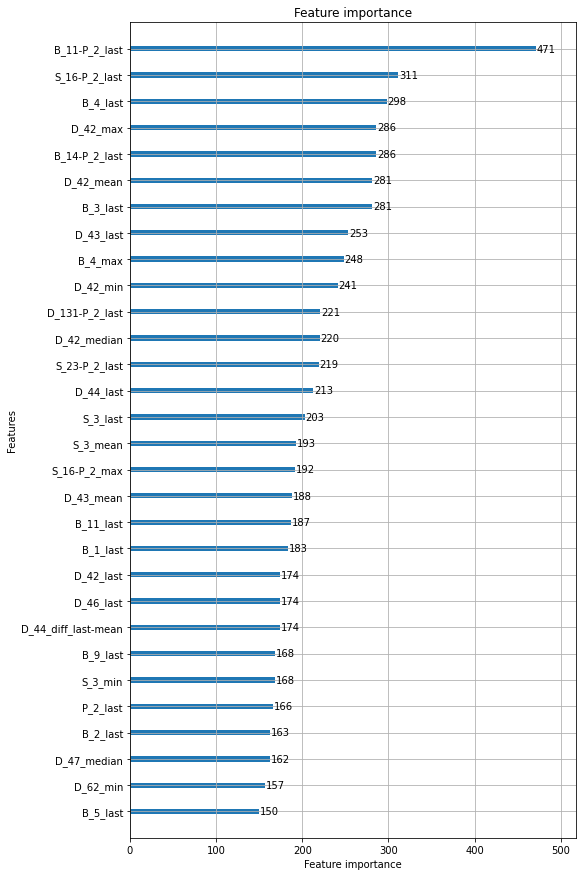

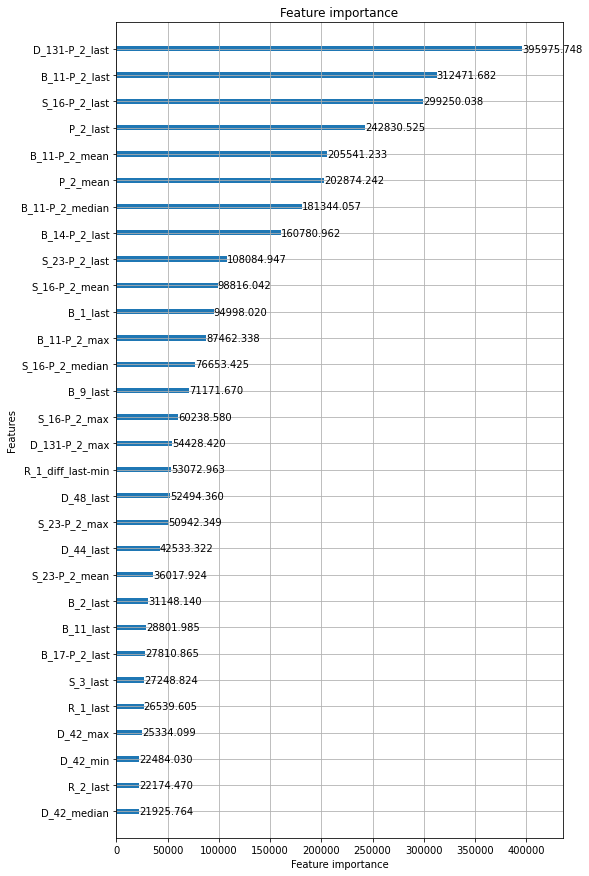

######################################## training model 4/5 ########################################
seed: 23


[50]	valid_0's amex_metric: 0.749794	valid_0's recall_at4: 0.599369	valid_0's norm_gini: 0.900218


[100]	valid_0's amex_metric: 0.762098	valid_0's recall_at4: 0.616537	valid_0's norm_gini: 0.907659


[150]	valid_0's amex_metric: 0.76949	valid_0's recall_at4: 0.626762	valid_0's norm_gini: 0.912219


[200]	valid_0's amex_metric: 0.772861	valid_0's recall_at4: 0.631643	valid_0's norm_gini: 0.914078


[250]	valid_0's amex_metric: 0.777001	valid_0's recall_at4: 0.638376	valid_0's norm_gini: 0.915626


[300]	valid_0's amex_metric: 0.780384	valid_0's recall_at4: 0.643846	valid_0's norm_gini: 0.916923


[350]	valid_0's amex_metric: 0.782029	valid_0's recall_at4: 0.646202	valid_0's norm_gini: 0.917855


[400]	valid_0's amex_metric: 0.784048	valid_0's recall_at4: 0.649316	valid_0's norm_gini: 0.918779


[450]	valid_0's amex_metric: 0.785807	valid_0's recall_at4: 0.652051	valid_0's norm_gini: 0.919562


[500]	valid_0's amex_metric: 0.786709	valid_0's recall_at4: 0.653356	valid_0's norm_gini: 0.920061


[550]	valid_0's amex_metric: 0.788292	valid_0's recall_at4: 0.655881	valid_0's norm_gini: 0.920704


[600]	valid_0's amex_metric: 0.789663	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.921257


[650]	valid_0's amex_metric: 0.790805	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.921648


[700]	valid_0's amex_metric: 0.79137	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.921935


[750]	valid_0's amex_metric: 0.791321	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.922258


[800]	valid_0's amex_metric: 0.792204	valid_0's recall_at4: 0.661856	valid_0's norm_gini: 0.922552


[850]	valid_0's amex_metric: 0.793159	valid_0's recall_at4: 0.663539	valid_0's norm_gini: 0.922779


[900]	valid_0's amex_metric: 0.792733	valid_0's recall_at4: 0.662445	valid_0's norm_gini: 0.92302


[950]	valid_0's amex_metric: 0.792962	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.923185


[1000]	valid_0's amex_metric: 0.79382	valid_0's recall_at4: 0.664296	valid_0's norm_gini: 0.923344


[1050]	valid_0's amex_metric: 0.793545	valid_0's recall_at4: 0.663581	valid_0's norm_gini: 0.923508


[1100]	valid_0's amex_metric: 0.793807	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.923697


[1150]	valid_0's amex_metric: 0.79325	valid_0's recall_at4: 0.662655	valid_0's norm_gini: 0.923845


[1200]	valid_0's amex_metric: 0.794066	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.923961


[1250]	valid_0's amex_metric: 0.79471	valid_0's recall_at4: 0.665306	valid_0's norm_gini: 0.924113


[1300]	valid_0's amex_metric: 0.794381	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.924255


[1350]	valid_0's amex_metric: 0.795357	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.924356


[1400]	valid_0's amex_metric: 0.795378	valid_0's recall_at4: 0.666316	valid_0's norm_gini: 0.92444


[1450]	valid_0's amex_metric: 0.795311	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.924516


[1500]	valid_0's amex_metric: 0.79572	valid_0's recall_at4: 0.666863	valid_0's norm_gini: 0.924577


[1550]	valid_0's amex_metric: 0.796031	valid_0's recall_at4: 0.66741	valid_0's norm_gini: 0.924651


[1600]	valid_0's amex_metric: 0.795995	valid_0's recall_at4: 0.667284	valid_0's norm_gini: 0.924706


[1650]	valid_0's amex_metric: 0.796145	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.924755


[1700]	valid_0's amex_metric: 0.796422	valid_0's recall_at4: 0.668041	valid_0's norm_gini: 0.924803


[1750]	valid_0's amex_metric: 0.796268	valid_0's recall_at4: 0.667705	valid_0's norm_gini: 0.924832


[1800]	valid_0's amex_metric: 0.796175	valid_0's recall_at4: 0.667494	valid_0's norm_gini: 0.924856


[1850]	valid_0's amex_metric: 0.796451	valid_0's recall_at4: 0.667999	valid_0's norm_gini: 0.924903


[1900]	valid_0's amex_metric: 0.796449	valid_0's recall_at4: 0.667957	valid_0's norm_gini: 0.924941


[1950]	valid_0's amex_metric: 0.796984	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.924959


[2000]	valid_0's amex_metric: 0.796768	valid_0's recall_at4: 0.668546	valid_0's norm_gini: 0.92499


[2050]	valid_0's amex_metric: 0.796628	valid_0's recall_at4: 0.66821	valid_0's norm_gini: 0.925046


[2100]	valid_0's amex_metric: 0.796445	valid_0's recall_at4: 0.667789	valid_0's norm_gini: 0.925102


[2150]	valid_0's amex_metric: 0.796446	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.925145


[2200]	valid_0's amex_metric: 0.796359	valid_0's recall_at4: 0.667578	valid_0's norm_gini: 0.92514


[2250]	valid_0's amex_metric: 0.796248	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.92517


[2300]	valid_0's amex_metric: 0.796789	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925201


[2350]	valid_0's amex_metric: 0.796806	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925234


[2400]	valid_0's amex_metric: 0.796812	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925246


[2450]	valid_0's amex_metric: 0.796761	valid_0's recall_at4: 0.668252	valid_0's norm_gini: 0.925271


[2500]	valid_0's amex_metric: 0.796587	valid_0's recall_at4: 0.667873	valid_0's norm_gini: 0.925301


[2550]	valid_0's amex_metric: 0.796536	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.925326


[2600]	valid_0's amex_metric: 0.796826	valid_0's recall_at4: 0.668294	valid_0's norm_gini: 0.925358


[2650]	valid_0's amex_metric: 0.797037	valid_0's recall_at4: 0.668715	valid_0's norm_gini: 0.925359


[2700]	valid_0's amex_metric: 0.797073	valid_0's recall_at4: 0.668757	valid_0's norm_gini: 0.925389


[2750]	valid_0's amex_metric: 0.797168	valid_0's recall_at4: 0.668925	valid_0's norm_gini: 0.925411


[2800]	valid_0's amex_metric: 0.79705	valid_0's recall_at4: 0.668672	valid_0's norm_gini: 0.925428


[2850]	valid_0's amex_metric: 0.797271	valid_0's recall_at4: 0.669093	valid_0's norm_gini: 0.925448


[2900]	valid_0's amex_metric: 0.797383	valid_0's recall_at4: 0.669304	valid_0's norm_gini: 0.925463


[2950]	valid_0's amex_metric: 0.797919	valid_0's recall_at4: 0.670356	valid_0's norm_gini: 0.925483


[3000]	valid_0's amex_metric: 0.797693	valid_0's recall_at4: 0.669893	valid_0's norm_gini: 0.925493


[3050]	valid_0's amex_metric: 0.797144	valid_0's recall_at4: 0.668799	valid_0's norm_gini: 0.92549


[3100]	valid_0's amex_metric: 0.797737	valid_0's recall_at4: 0.669935	valid_0's norm_gini: 0.92554


[3150]	valid_0's amex_metric: 0.798126	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.925561


[3200]	valid_0's amex_metric: 0.797598	valid_0's recall_at4: 0.66964	valid_0's norm_gini: 0.925556


[3250]	valid_0's amex_metric: 0.797388	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925556


[3300]	valid_0's amex_metric: 0.797009	valid_0's recall_at4: 0.668462	valid_0's norm_gini: 0.925556


[3350]	valid_0's amex_metric: 0.797114	valid_0's recall_at4: 0.668672	valid_0's norm_gini: 0.925556


[3400]	valid_0's amex_metric: 0.797498	valid_0's recall_at4: 0.66943	valid_0's norm_gini: 0.925566


[3450]	valid_0's amex_metric: 0.797182	valid_0's recall_at4: 0.668799	valid_0's norm_gini: 0.925565


[3500]	valid_0's amex_metric: 0.79715	valid_0's recall_at4: 0.668715	valid_0's norm_gini: 0.925586


[3550]	valid_0's amex_metric: 0.79767	valid_0's recall_at4: 0.669766	valid_0's norm_gini: 0.925573


[3600]	valid_0's amex_metric: 0.798041	valid_0's recall_at4: 0.670482	valid_0's norm_gini: 0.9256


[3650]	valid_0's amex_metric: 0.798054	valid_0's recall_at4: 0.670482	valid_0's norm_gini: 0.925625


[3700]	valid_0's amex_metric: 0.798498	valid_0's recall_at4: 0.671365	valid_0's norm_gini: 0.92563


[3750]	valid_0's amex_metric: 0.798567	valid_0's recall_at4: 0.671492	valid_0's norm_gini: 0.925643


[3800]	valid_0's amex_metric: 0.798141	valid_0's recall_at4: 0.67065	valid_0's norm_gini: 0.925632


[3850]	valid_0's amex_metric: 0.798166	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.925639


[3900]	valid_0's amex_metric: 0.798269	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.925635


[3950]	valid_0's amex_metric: 0.798648	valid_0's recall_at4: 0.67166	valid_0's norm_gini: 0.925637


[4000]	valid_0's amex_metric: 0.798349	valid_0's recall_at4: 0.671071	valid_0's norm_gini: 0.925627


[4050]	valid_0's amex_metric: 0.798381	valid_0's recall_at4: 0.671155	valid_0's norm_gini: 0.925607


[4100]	valid_0's amex_metric: 0.798674	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.925604


[4150]	valid_0's amex_metric: 0.798634	valid_0's recall_at4: 0.67166	valid_0's norm_gini: 0.925607


[4200]	valid_0's amex_metric: 0.798459	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.925594


[4250]	valid_0's amex_metric: 0.798801	valid_0's recall_at4: 0.671997	valid_0's norm_gini: 0.925605


[4300]	valid_0's amex_metric: 0.798633	valid_0's recall_at4: 0.67166	valid_0's norm_gini: 0.925606


[4350]	valid_0's amex_metric: 0.798382	valid_0's recall_at4: 0.671155	valid_0's norm_gini: 0.92561


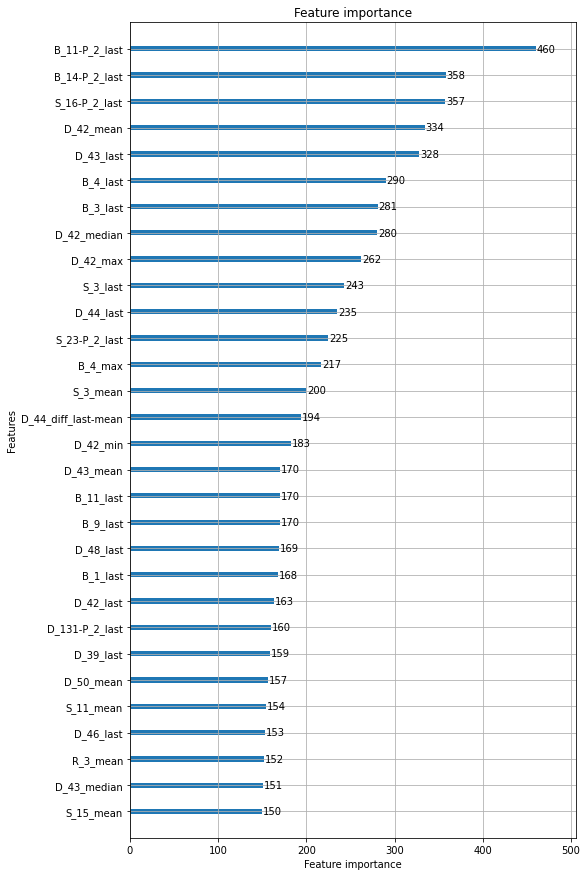

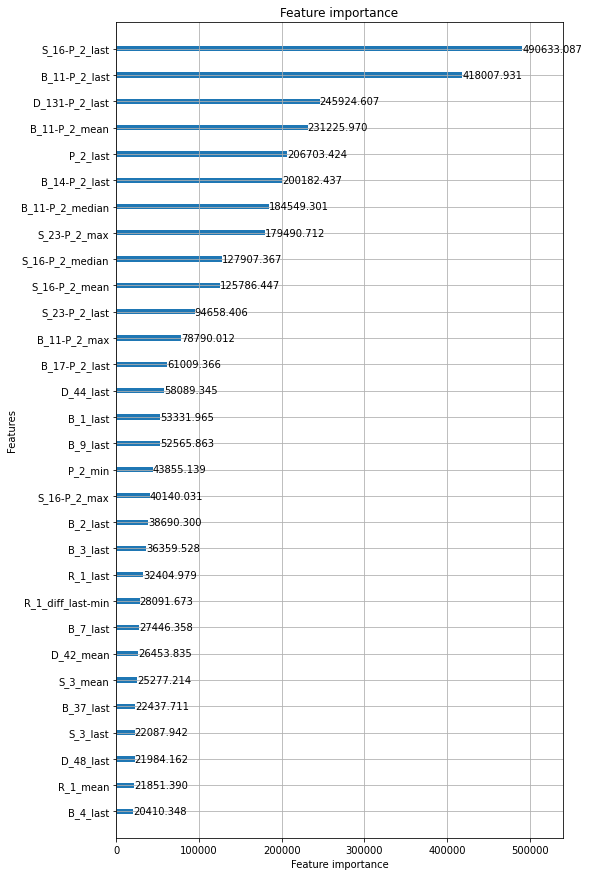

######################################## training model 5/5 ########################################
seed: 24


[50]	valid_0's amex_metric: 0.74907	valid_0's recall_at4: 0.600084	valid_0's norm_gini: 0.898057


[100]	valid_0's amex_metric: 0.758277	valid_0's recall_at4: 0.612539	valid_0's norm_gini: 0.904015


[150]	valid_0's amex_metric: 0.76465	valid_0's recall_at4: 0.620955	valid_0's norm_gini: 0.908345


[200]	valid_0's amex_metric: 0.771211	valid_0's recall_at4: 0.630423	valid_0's norm_gini: 0.911999


[250]	valid_0's amex_metric: 0.774472	valid_0's recall_at4: 0.634841	valid_0's norm_gini: 0.914103


[300]	valid_0's amex_metric: 0.777368	valid_0's recall_at4: 0.639049	valid_0's norm_gini: 0.915687


[350]	valid_0's amex_metric: 0.779933	valid_0's recall_at4: 0.642668	valid_0's norm_gini: 0.917199


[400]	valid_0's amex_metric: 0.781788	valid_0's recall_at4: 0.645445	valid_0's norm_gini: 0.918132


[450]	valid_0's amex_metric: 0.783667	valid_0's recall_at4: 0.648433	valid_0's norm_gini: 0.918902


[500]	valid_0's amex_metric: 0.783998	valid_0's recall_at4: 0.648685	valid_0's norm_gini: 0.91931


[550]	valid_0's amex_metric: 0.785332	valid_0's recall_at4: 0.650789	valid_0's norm_gini: 0.919874


[600]	valid_0's amex_metric: 0.785901	valid_0's recall_at4: 0.65142	valid_0's norm_gini: 0.920383


[650]	valid_0's amex_metric: 0.786668	valid_0's recall_at4: 0.652556	valid_0's norm_gini: 0.920779


[700]	valid_0's amex_metric: 0.787009	valid_0's recall_at4: 0.653019	valid_0's norm_gini: 0.920999


[750]	valid_0's amex_metric: 0.78761	valid_0's recall_at4: 0.653903	valid_0's norm_gini: 0.921317


[800]	valid_0's amex_metric: 0.788201	valid_0's recall_at4: 0.654829	valid_0's norm_gini: 0.921573


[850]	valid_0's amex_metric: 0.78842	valid_0's recall_at4: 0.654997	valid_0's norm_gini: 0.921844


[900]	valid_0's amex_metric: 0.789826	valid_0's recall_at4: 0.657564	valid_0's norm_gini: 0.922089


[950]	valid_0's amex_metric: 0.78969	valid_0's recall_at4: 0.657059	valid_0's norm_gini: 0.922321


[1000]	valid_0's amex_metric: 0.790379	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.922478


[1050]	valid_0's amex_metric: 0.79003	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.922622


[1100]	valid_0's amex_metric: 0.789967	valid_0's recall_at4: 0.657227	valid_0's norm_gini: 0.922707


[1150]	valid_0's amex_metric: 0.790273	valid_0's recall_at4: 0.65769	valid_0's norm_gini: 0.922856


[1200]	valid_0's amex_metric: 0.790512	valid_0's recall_at4: 0.657984	valid_0's norm_gini: 0.92304


[1250]	valid_0's amex_metric: 0.790815	valid_0's recall_at4: 0.658405	valid_0's norm_gini: 0.923224


[1300]	valid_0's amex_metric: 0.791478	valid_0's recall_at4: 0.659583	valid_0's norm_gini: 0.923373


[1350]	valid_0's amex_metric: 0.792132	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.923502


[1400]	valid_0's amex_metric: 0.792386	valid_0's recall_at4: 0.661182	valid_0's norm_gini: 0.92359


[1450]	valid_0's amex_metric: 0.792983	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.923733


[1500]	valid_0's amex_metric: 0.792967	valid_0's recall_at4: 0.662108	valid_0's norm_gini: 0.923825


[1550]	valid_0's amex_metric: 0.793684	valid_0's recall_at4: 0.663455	valid_0's norm_gini: 0.923913


[1600]	valid_0's amex_metric: 0.79339	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.923998


[1650]	valid_0's amex_metric: 0.793081	valid_0's recall_at4: 0.662066	valid_0's norm_gini: 0.924096


[1700]	valid_0's amex_metric: 0.792907	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.924169


[1750]	valid_0's amex_metric: 0.792815	valid_0's recall_at4: 0.661393	valid_0's norm_gini: 0.924236


[1800]	valid_0's amex_metric: 0.793665	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.924296


[1850]	valid_0's amex_metric: 0.793375	valid_0's recall_at4: 0.662403	valid_0's norm_gini: 0.924348


[1900]	valid_0's amex_metric: 0.793625	valid_0's recall_at4: 0.662866	valid_0's norm_gini: 0.924385


[1950]	valid_0's amex_metric: 0.793687	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.924424


[2000]	valid_0's amex_metric: 0.793856	valid_0's recall_at4: 0.663244	valid_0's norm_gini: 0.924467


[2050]	valid_0's amex_metric: 0.793834	valid_0's recall_at4: 0.66316	valid_0's norm_gini: 0.924508


[2100]	valid_0's amex_metric: 0.793456	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.924551


[2150]	valid_0's amex_metric: 0.794	valid_0's recall_at4: 0.663413	valid_0's norm_gini: 0.924587


[2200]	valid_0's amex_metric: 0.794167	valid_0's recall_at4: 0.663707	valid_0's norm_gini: 0.924627


[2250]	valid_0's amex_metric: 0.794386	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.924644


[2300]	valid_0's amex_metric: 0.794243	valid_0's recall_at4: 0.663791	valid_0's norm_gini: 0.924695


[2350]	valid_0's amex_metric: 0.793487	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924697


[2400]	valid_0's amex_metric: 0.793873	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.924713


[2450]	valid_0's amex_metric: 0.793694	valid_0's recall_at4: 0.662655	valid_0's norm_gini: 0.924733


[2500]	valid_0's amex_metric: 0.79415	valid_0's recall_at4: 0.663539	valid_0's norm_gini: 0.924762


[2550]	valid_0's amex_metric: 0.79365	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.924813


[2600]	valid_0's amex_metric: 0.793956	valid_0's recall_at4: 0.663076	valid_0's norm_gini: 0.924836


[2650]	valid_0's amex_metric: 0.793983	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.924848


[2700]	valid_0's amex_metric: 0.79409	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924851


[2750]	valid_0's amex_metric: 0.794526	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924882


[2800]	valid_0's amex_metric: 0.794283	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.924901


[2850]	valid_0's amex_metric: 0.794267	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.924911


[2900]	valid_0's amex_metric: 0.794547	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924923


[2950]	valid_0's amex_metric: 0.794642	valid_0's recall_at4: 0.664338	valid_0's norm_gini: 0.924946


[3000]	valid_0's amex_metric: 0.794205	valid_0's recall_at4: 0.663455	valid_0's norm_gini: 0.924956


[3050]	valid_0's amex_metric: 0.794339	valid_0's recall_at4: 0.663707	valid_0's norm_gini: 0.924971


[3100]	valid_0's amex_metric: 0.794392	valid_0's recall_at4: 0.663833	valid_0's norm_gini: 0.924951


[3150]	valid_0's amex_metric: 0.793896	valid_0's recall_at4: 0.662823	valid_0's norm_gini: 0.924969


[3200]	valid_0's amex_metric: 0.794267	valid_0's recall_at4: 0.663539	valid_0's norm_gini: 0.924995


[3250]	valid_0's amex_metric: 0.794595	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.925019


[3300]	valid_0's amex_metric: 0.794373	valid_0's recall_at4: 0.663707	valid_0's norm_gini: 0.925039


[3350]	valid_0's amex_metric: 0.794474	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.925031


[3400]	valid_0's amex_metric: 0.79446	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.925044


[3450]	valid_0's amex_metric: 0.794467	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.925058


[3500]	valid_0's amex_metric: 0.794641	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.925071


[3550]	valid_0's amex_metric: 0.795044	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.925076


[3600]	valid_0's amex_metric: 0.79504	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.925068


[3650]	valid_0's amex_metric: 0.79483	valid_0's recall_at4: 0.664591	valid_0's norm_gini: 0.925068


[3700]	valid_0's amex_metric: 0.794967	valid_0's recall_at4: 0.664843	valid_0's norm_gini: 0.925091


[3750]	valid_0's amex_metric: 0.795119	valid_0's recall_at4: 0.665138	valid_0's norm_gini: 0.9251


[3800]	valid_0's amex_metric: 0.794814	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.925079


[3850]	valid_0's amex_metric: 0.795118	valid_0's recall_at4: 0.665138	valid_0's norm_gini: 0.925098


[3900]	valid_0's amex_metric: 0.795247	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.925104


[3950]	valid_0's amex_metric: 0.794912	valid_0's recall_at4: 0.664717	valid_0's norm_gini: 0.925106


[4000]	valid_0's amex_metric: 0.795176	valid_0's recall_at4: 0.665222	valid_0's norm_gini: 0.925129


[4050]	valid_0's amex_metric: 0.795516	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.925138


[4100]	valid_0's amex_metric: 0.795333	valid_0's recall_at4: 0.665516	valid_0's norm_gini: 0.925149


[4150]	valid_0's amex_metric: 0.795147	valid_0's recall_at4: 0.665138	valid_0's norm_gini: 0.925157


[4200]	valid_0's amex_metric: 0.795797	valid_0's recall_at4: 0.666442	valid_0's norm_gini: 0.925152


[4250]	valid_0's amex_metric: 0.795504	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.925155


[4300]	valid_0's amex_metric: 0.795595	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.925169


[4350]	valid_0's amex_metric: 0.795227	valid_0's recall_at4: 0.665306	valid_0's norm_gini: 0.925148


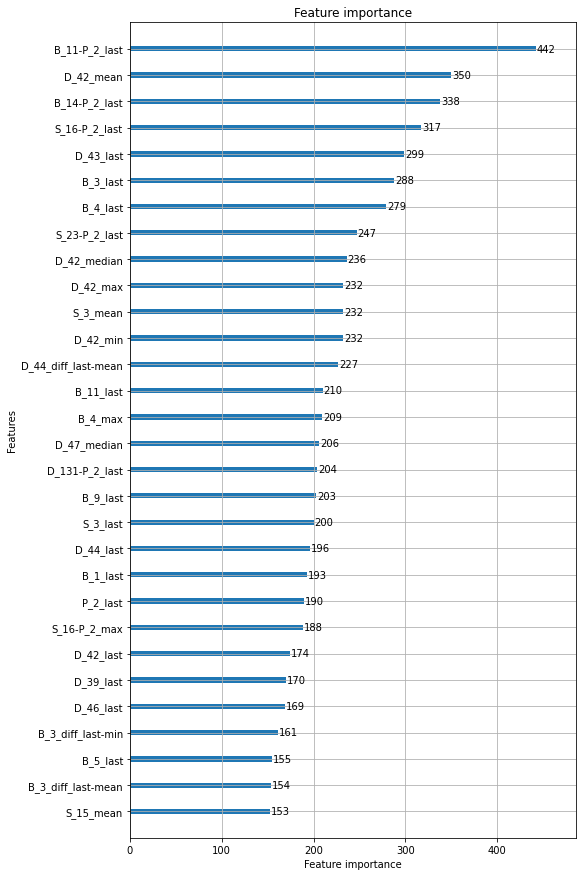

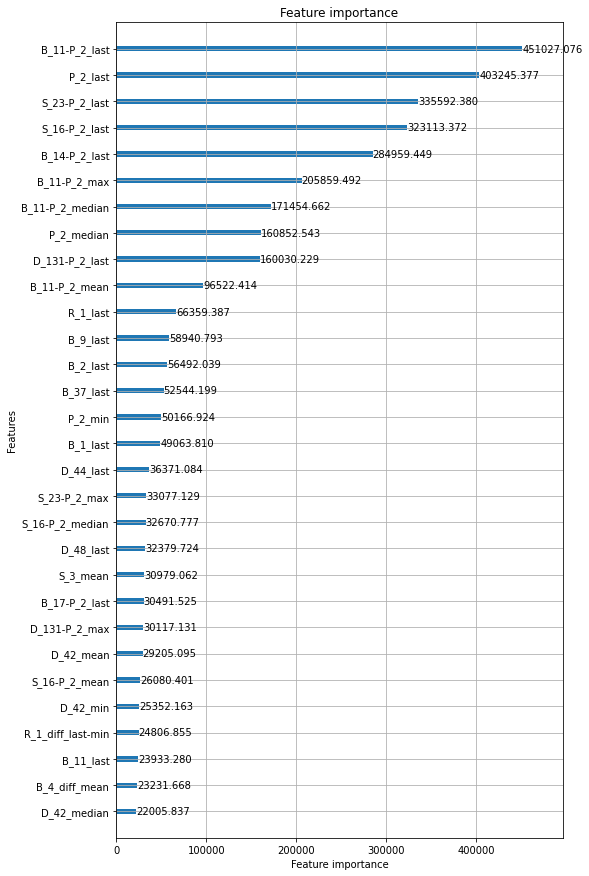

Training time: 39.38720275163651 min.
OOF recall_at4: 0.6711633621705322
OOF normalized_gini: 0.9260301701690375
OOF competition metric: 0.7985967661697848


CPU times: user 2d 9h 34s, sys: 2min 4s, total: 2d 9h 2min 38s
Wall time: 3h 15min 45s


In [11]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
    
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

recall_at4      gini    metric
0    0.669968  0.926012  0.797990
1    0.671525  0.926046  0.798785
2    0.670785  0.926090  0.798437
3    0.670372  0.925991  0.798181
4    0.671163  0.926030  0.798597


mean:


recall_at4    0.670763
gini          0.926034
metric        0.798398
dtype: float64


std:


recall_at4    0.000618
gini          0.000038
metric        0.000318
dtype: float64

In [13]:
del train
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 2h 54min 56s, sys: 1min 10s, total: 2h 56min 7s
Wall time: 10min 37s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.88 s, sys: 91 ms, total: 3.98 s
Wall time: 4.28 s


***